  # Apply encoder to morphological profiles to get latent space representations :

# Setup

In [2]:
%load_ext autoreload  
%autoreload 2
from IPython.display import display, HTML, Image
from IPython.core.interactiveshell import InteractiveShell
display(HTML("<style>.container { width:98% !important; }</style>"))
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import os
import sys
import csv
import json
import time
import types
import copy
import pprint
import logging
from datetime import datetime
for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)

import numpy as np
import pandas as pd
import scipy
import torch
import torch.nn.functional as F
from torchinfo import summary

torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)


pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "AE-MAIN-SNNL.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

insert ./src
insert ../..
['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


In [4]:
# import snnl.utils as utils
# from snnl.utils import parse_args, load_configuration, set_global_seed, get_device, set_device
from KevinsRoutines.utils.utils_general import list_namespace, save_to_pickle, load_from_pickle

In [5]:
import seaborn as sb
import matplotlib.pyplot as plt
import scipy.stats as sps

from scipy.spatial.distance import pdist, squareform, euclidean

# from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_fscore_support
# from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, roc_curve, RocCurveDisplay
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Models
from xgboost import XGBClassifier, XGBRegressor

import sklearn.metrics as skm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sklearn.utils.random as skr


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# utility class to help normalize labels such that they contain only values between 0 and n_classes-1.
from sklearn.preprocessing import LabelEncoder

# K-Folds cross-validator - Provides train/test indices to split data in train/test sets. Split dataset into k consecutive folds (without shuffling by default).
# Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GroupKFold, StratifiedGroupKFold
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit, StratifiedShuffleSplit, TimeSeriesSplit

# Evaluate metric(s) by cross-validation and also record fit/score times.
from sklearn.model_selection import cross_validate, cross_val_score

# Generate cross-validated estimates for each input data point.
# The data is split according to the cv parameter. Each sample belongs to exactly one test set,
# and its prediction is computed with an estimator fitted on the corresponding training set.
from sklearn.model_selection import cross_val_predict

# Exhaustive search over specified parameter values for an estimator.
# Randomized search on hyper parameters.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Input checker utility for building a cross-validator.(?)
from sklearn.model_selection._split import check_cv

from sklearn.pipeline import Pipeline

# Make a scorer from a performance metric or loss function. This factory function wraps scoring
# functions for use in GridSearchCV and cross_val_score. It takes a score function, such as accuracy_score,
# mean_squared_error, adjusted_rand_score or average_precision_score and returns a callable that
# scores an estimator’s output. The signature of the call is (estimator, X, y) where estimator
# is the model to be evaluated, X is the data and y is the ground truth labeling (or None in the
# case of unsupervised models).
from sklearn.metrics import make_scorer

# regression matrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# classification metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# from sklearn.base import BaseEstimator
# from sklearn.base import ClassifierMixin
# from sklearn.base import TransformerMixin

# Construct a new unfitted estimator with the same parameters. Clone does a deep copy of the model
# in an estimator without actually copying attached data. It returns a new estimator with the same
# parameters that has not been fitted on any data.
# from sklearn.base import clone
from sklearn.preprocessing import StandardScaler


In [7]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
logger.info(f" Pytorch version  : {torch.__version__}")
logger.info(f" Scipy version    : {scipy.__version__}  \t\t Numpy version : {np.__version__}")
logger.info(f" Pandas version: {pd.__version__}  ")


2024-11-13 22:45:04,018 - __main__ - INFO: -  Excution started : 2024_11_13_22:45:04 
2024-11-13 22:45:04,019 - __main__ - INFO: -  Pytorch version  : 2.2.0
2024-11-13 22:45:04,020 - __main__ - INFO: -  Scipy version    : 1.11.4  		 Numpy version : 1.26.2
2024-11-13 22:45:04,021 - __main__ - INFO: -  Pandas version: 2.2.0  


In [8]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = './output_10162023/')
display_project_datasets(ds)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_10162023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_10162023/compound_metadata_smiles.csv
          + TPSA                             : ./output_10162023/compound_metadata_tpsa.csv
          + TPSA Cl

In [9]:
WANDB_ACTIVE  = False
DATE          = 'yyyymmdd-hhmm'
# CHECKPT       = "AE_snnl_dcpb200_150Ltnt_512_240709_2235_LAST_ep_705.pt"
# RUN_ID        = "jzt6ecjz"
EMBEDDING_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/"
FINGERPRINT_INPUT_PATH = f"/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/"
MODEL_SAVE_PATH = f"./saved_fingerprint_models/embedded_models"

LATENT_DIM    = 250
LATENT_DIM = 250
METADATA_COLS = ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well'  , 'Metadata_JCP2022', 
                 'Metadata_Hash'  , 'Metadata_Bin'  , 'Metadata_TPSA' , 'Metadata_lnTPSA', 'Metadata_log10TPSA', 
                 'Metadata_Permiation']

# METADATA_COLS += [f'Feature_{x:03d}' for x in range(LATENT_DIM)]
INPUT_COLS = LATENT_DIM + len(METADATA_COLS)
print(len(METADATA_COLS))
print(INPUT_COLS)


## AUTOENCODER RUNMODE 
AE_RUNMODE = "snnl"
# AE_RUNMODE = 'base'
## 
# AE_DATETIME = "20240906_2201"     # SNNL, CPB = 600, Latent 150, WD = 0.001, SNN Factor 3
AE_DATETIME = "20240917_2004"     # SNNL, CPB = 600, Latent 250, WD = 0.001, SNN Factor 3
##
# AE_CKPTTYPE = "BEST"
AE_CKPTTYPE = "LAST"
# df_header = pd.read_csv(HEADER_FILE).columns.to_list()
# header_cols

11
261


In [10]:
# = utils.load_model_from_ckpt(model, ex_mode, ex_timestamp, ex_title, epochs, ex_cpb, ex_factor )

FINGERPRINT_TRAINING_FILE = f"3sample_pharmacophores_1482_HashOrder_training.csv"
FINGERPRINT_TEST_FILE = f"3sample_pharmacophores_1482_HashOrder_test.csv"

print(FINGERPRINT_TRAINING_FILE)
print(FINGERPRINT_TEST_FILE)

EMBEDDING_TRAINING_FILE   = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_training.csv'
EMBEDDING_VALIDATION_FILE = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_validation.csv'
EMBEDDING_TEST_FILE       = f'3smpl_prfl_embedding_{INPUT_COLS}_HashOrder_{AE_RUNMODE}_{AE_DATETIME}_LAST_test.csv'

print()
print(EMBEDDING_TRAINING_FILE)
print(EMBEDDING_VALIDATION_FILE)
print(EMBEDDING_TEST_FILE)


3sample_pharmacophores_1482_HashOrder_training.csv
3sample_pharmacophores_1482_HashOrder_test.csv

3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_validation.csv
3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv


In [11]:
TRAIN_INPUT_X = os.path.join(EMBEDDING_INPUT_PATH, EMBEDDING_TRAINING_FILE)
TRAIN_INPUT_Y = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TRAINING_FILE)
TRAIN_INPUT_X
TRAIN_INPUT_Y

TEST_INPUT_X  = os.path.join(EMBEDDING_INPUT_PATH, EMBEDDING_TEST_FILE)
TEST_INPUT_Y  = os.path.join(FINGERPRINT_INPUT_PATH, FINGERPRINT_TEST_FILE)
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_training.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

## Helper routines

In [12]:
# sample_idxs = skr.sample_without_replacement(n_population=100, n_samples= 10 )
# rng = np.random.default_rng()
# indxs = rng.choice(100, [10,10], replace = False)
# indxs

In [13]:
from src.utils.utils_cellpainting import (model_selection, balance_datasets, label_counts, compute_metrics,
                                          plots_from_estimator, plots_from_predictions)

# Load Datasets - Embedded Features CSV files

## Training Data

In [298]:
df_train_x = pd.read_csv(TRAIN_INPUT_X)
# df_train = pd.read_csv(TRAIN_INPUT, nrows = 100 )
# df_train = pd.read_csv(TRAIN_INPUT, usecols = ['Metadata_Batch'])

In [299]:
df_train_x.shape
df_train_x.info()
# df_train_x.iloc[:5,4:16]
# df_train_x.head(10)
# df_train_x.tail(10)

(277200, 261)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 552.0+ MB


In [300]:
df_train_y = pd.read_csv(TRAIN_INPUT_Y)

df_train_y.shape
df_train_y.info()
df_train_y.iloc[ :10,:14]
df_train_y.iloc[-10:,:14]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


Metadata_JCP2022        Metadata_Hash  Metadata_Bin  0  1  2  3  4  5  6  7  8  9  10
0   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
1   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
2   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
3   JCP2022_058905 -9223229703754907651            13  1  1  1  1  0  0  1  1  1  0   0
4   JCP2022_058905 -9223229703754907651            13  1  1  1  1  0  0  1  1  1  0   0
5   JCP2022_058905 -9223229703754907651            13  1  1  1  1  0  0  1  1  1  0   0
6   JCP2022_051160 -9223005963369866647             9  0  1  1  1  1  1  1  1  0  1   0
7   JCP2022_051160 -9223005963369866647             9  0  1  1  1  1  1  1  1  0  1   0
8   JCP2022_051160 -9223005963369866647             9  0  1  1  1  1  1  1  1  0  1   0
9   JCP2022_038591 -9222975330808494972             4  0  1  1  1  1  1  1  1  1  1   0

Metadata_JCP2022        Metadata_Hash  Metadata_Bin  0  1  2  3  4  5  6  7  8  9  10
277190   JCP2022_089792  5548393758141673059             3  1  1  1  1  1  1  0  1  0  0   0
277191   JCP2022_054246  5548833810863940256             0  1  0  1  1  1  0  1  1  1  1   0
277192   JCP2022_054246  5548833810863940256             0  1  0  1  1  1  0  1  1  1  1   0
277193   JCP2022_054246  5548833810863940256             0  1  0  1  1  1  0  1  1  1  1   0
277194   JCP2022_040737  5548902807653184645             5  1  1  1  1  0  0  1  1  1  1   0
277195   JCP2022_040737  5548902807653184645             5  1  1  1  1  0  0  1  1  1  1   0
277196   JCP2022_040737  5548902807653184645             5  1  1  1  1  0  0  1  1  1  1   0
277197   JCP2022_100922  5548998150937919747             3  1  1  1  1  1  1  1  1  1  1   0
277198   JCP2022_100922  5548998150937919747             3  1  1  1  1  1  1  1  1  1  1   0
277199   JCP2022_100922  5548998150937919747             3  1  1  1  1  1  1  1  1  1  1   0

## Determine labels with '1' frequncy between 10 and 90 percent

In [301]:
# df_train_y_deduped = df_train_y.drop_duplicates('Metadata_JCP2022' )
# df_train_y_deduped

In [302]:
bit_counter = np.asarray(df_train_y.iloc[:, 3:].sum(axis=0)).squeeze() 
bit_counter
bit_counter // 3

bit_counter_pct = (bit_counter // 3) / 92400
bit_counter_pct

array([141879, 233172, 233271, ...,      0,     12,      3])

array([47293, 77724, 77757, ...,     0,     4,     1])

array([5.11829004e-01, 8.41168831e-01, 8.41525974e-01, ..., 0.00000000e+00, 4.32900433e-05, 1.08225108e-05])

In [303]:
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# bit_counter_select[:20]
bit_counter_select.shape
bit_counter_select.sum()
select_indices = np.arange(0,1032)
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent:")
selected_label_indices = select_indices[bit_counter_select]
selected_label_pct  = bit_counter_pct[bit_counter_select]
# selected_label_indices
# selected_label_pct

print("  BIT       PERCENT")
for bit, pct in zip(selected_label_indices, selected_label_pct):
    print(f" {bit:3d}         {pct*100:.2f}")

 num of bits with < %  5 frequency : 786  
 num of bits with < % 10 frequency : 845  
 num of bits with < % 15 frequency : 884  

 num of bits with > %  5 frequency : 246  
 num of bits with > % 10 frequency : 187  
 num of bits with > % 15 frequency : 148  

 num of bits with > % 85 frequency : 2  
 num of bits with > % 90 frequency : 2  
 num of bits with > % 95 frequency : 0  


(1032,)

185

 Indicies corresponding to bits with a frequency between 10 and 90 percent:
  BIT       PERCENT
   0         51.18
   1         84.12
   2         84.15
   4         53.05
   5         82.04
   6         81.27
   8         71.59
   9         83.91
  13         24.61
  16         38.63
  17         65.21
  18         62.03
  19         78.68
  20         60.38
  21         80.72
  22         39.85
  23         64.19
  26         13.14
  27         20.31
  30         17.68
  31         37.90
  32         63.45
  33         77.17
  34         44.15
  35         67.64
  39         18.79
  42         57.61
  43         61.65
  44         33.67
  45         64.33
  48         16.14
  49         19.80
  52         10.13
  53         34.95
  57         15.67
  78         40.33
  79         32.29
  80         26.91
  83         35.23
  84         37.94
  86         61.82
  87         52.90
  91         32.57
  94         43.68
  95         39.91
  96         28.96
  98         11.65
  99       

In [304]:
# selected_label_indices = np.array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
#         44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
#        127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
#        197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
#        267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
#        433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
#        639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

# selected_label_indices_3 = np.array([  3,   4,   5,   7,   8,   9,  11,  12,  16,  19,  20,  21,  22,  23,  24,  25,  26,  29,  30,  33,  34,  35,  36,  37,  38,  42,  45,  46,
#         47,  48,  51,  52,  55,  56,  60,  81,  82,  83,  86,  87,  89,  90,  94,  97,  98,  99, 101, 102, 103, 105, 106, 107, 110, 111, 113, 114,
#        130, 143, 144, 145, 146, 147, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 165, 166, 167, 168, 169, 170, 182, 186,
#        200, 201, 202, 203, 205, 206, 207, 208, 209, 210, 211, 213, 214, 215, 216, 217, 218, 234, 247, 248, 249, 250, 253, 254, 255, 256, 257, 258,
#        270, 273, 274, 288, 290, 369, 373, 374, 375, 377, 378, 381, 382, 385, 386, 390, 393, 420, 424, 425, 426, 428, 429, 430, 431, 432, 433, 434,
#        436, 437, 438, 440, 441, 442, 467, 468, 471, 472, 473, 474, 476, 478, 480, 481, 482, 512, 598, 601, 602, 606, 609, 610, 636, 639, 640, 641,
#        642, 644, 645, 646, 648, 649, 650, 680, 682, 755, 759, 761, 762, 766, 769, 770, 800])

In [305]:
# try:
#     del train_x
# except Exception as e :
#     pass
# train_x = pd.concat((df_train_x.iloc[:,4], df_train_x.iloc[:,11:]), axis=1)
# train_x

In [306]:
# try:
#     del train_y
# except Exception as e :
#     pass
# # train_y = df_train_y.iloc[:, selected_label_indices_3]
# train_y = df_train_y
# train_y

In [309]:
selected_label_indices
df_train_x.shape, type(df_train_x) 
df_train_y.shape, type(df_train_y)

array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

((277200, 261), pandas.core.frame.DataFrame)

((277200, 1035), pandas.core.frame.DataFrame)

In [30]:
# del train_x, train_y

## Test Data 

In [310]:
TEST_INPUT_X
TEST_INPUT_Y

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_embeddings/3smpl_prfl_embedding_261_HashOrder_snnl_20240917_2004_LAST_test.csv'

'/home/kevin/WSL-shared/cellpainting/cj-datasets/output_11102023/3_sample_profiles/3sample_pharmacophores_1482_HashOrder_test.csv'

In [311]:
df_test_x = pd.read_csv(TEST_INPUT_X )

In [312]:
df_test_x.info()
df_test_x.shape
df_test_x.columns
df_test_x.iloc[:5,:13]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12600 entries, 0 to 12599
Columns: 261 entries, Metadata_Source to Feature_249
dtypes: float64(254), int64(2), object(5)
memory usage: 25.1+ MB


(12600, 261)

Index(['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',
       'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA',
       ...
       'Feature_240', 'Feature_241', 'Feature_242', 'Feature_243', 'Feature_244', 'Feature_245', 'Feature_246', 'Feature_247',
       'Feature_248', 'Feature_249'],
      dtype='object', length=261)

Metadata_Source                  Metadata_Batch Metadata_Plate Metadata_Well Metadata_JCP2022        Metadata_Hash  \
0        source_9                   20210914-Run9     GR00003302           H45   JCP2022_004021  6703456398488902534   
1        source_9                   20210914-Run9     GR00003301           H21   JCP2022_004021  6703456398488902534   
2        source_9                   20210914-Run9     GR00003303           X45   JCP2022_004021  6703456398488902534   
3        source_3               CP_32_all_Phenix1       B40803aW           P21   JCP2022_102146  6704177726803547665   
4        source_6  p210928CPU2OS48hw384exp030JUMP   110000296383           P21   JCP2022_102146  6704177726803547665   

   Metadata_Bin  Metadata_TPSA  Metadata_lnTPSA  Metadata_log10TPSA  Metadata_Permiation  Feature_000  Feature_001  
0             6          58.04         4.061132            1.763727                  0.0     0.916451     0.872596  
1             6          58.04         4.061132            1.763727                  0.0     0.719237     0.682143  
2             6          58.04         4.061132            1.763727                  0.0     0.798004     0.805205  
3             1          86.51         4.460260            1.937066                  0.0    -0.134616    -0.200266  
4             1          86.51         4.460260            1.937066                  0.0    -0.031706    -0.148909

In [313]:
df_test_y = pd.read_csv(TEST_INPUT_Y )
df_train_y.shape
df_train_y.info()
df_train_y.iloc[:5,:14]
df_train_y.iloc[:5, 13:33]

(277200, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277200 entries, 0 to 277199
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 2.1+ GB


Metadata_JCP2022        Metadata_Hash  Metadata_Bin  0  1  2  3  4  5  6  7  8  9  10
0   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
1   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
2   JCP2022_006020 -9223347314827979542            10  1  1  1  1  0  1  1  1  1  1   0
3   JCP2022_058905 -9223229703754907651            13  1  1  1  1  0  0  1  1  1  0   0
4   JCP2022_058905 -9223229703754907651            13  1  1  1  1  0  0  1  1  1  0   0

10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29
0   0   0   0   1   0   0   1   0   1   1   1   1   1   1   0   0   1   1   0   0
1   0   0   0   1   0   0   1   0   1   1   1   1   1   1   0   0   1   1   0   0
2   0   0   0   1   0   0   1   0   1   1   1   1   1   1   0   0   1   1   0   0
3   0   0   0   1   0   0   1   1   0   0   1   1   1   1   0   0   1   0   0   0
4   0   0   0   1   0   0   1   1   0   0   1   1   1   1   0   0   1   0   0   0

In [314]:
# test_y = df_test.iloc[:,10:11].to_numpy().ravel().astype(np.uint8)
# test_y.sum()
# test_y.shape, type(test_y), test_y.dtype
# test_X = df_test.iloc[:,11:].to_numpy()
# test_X.shape,type(test_X), test_X.dtype
df_test_x.shape, type(df_test_x) 
df_test_y.shape, type(df_test_y)
# test_x
# test_y

((12600, 261), pandas.core.frame.DataFrame)

((12600, 1035), pandas.core.frame.DataFrame)

## Other input preprocessing

### Standardize inputs

In [619]:
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

Train_X :  Min: -72.2029    Max: 103.8641   Mean: 0.0527  Std: 2.5164
Test_X  :  Min: -53.3835    Max: 71.4748    Mean: 0.0529  Std: 2.4997


In [620]:
# print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
# print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")

In [621]:
scaler = StandardScaler(copy = True)
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [622]:
print("After Standard Scaler Transformation")
print(f"Train_X :  Min: {train_X.min():.4f}    Max: {train_X.max():.4f}   Mean: {train_X.mean():.4f}  Std: {train_X.std():.4f}")
print(f"Test_X  :  Min: {test_X.min():.4f}    Max: {test_X.max():.4f}    Mean: {test_X.mean():.4f}  Std: {test_X.std():.4f}")


After Standard Scaler Transformation
Train_X :  Min: -33.4514    Max: 27.3319   Mean: -0.0000  Std: 1.0000
Test_X  :  Min: -24.2626    Max: 28.1195    Mean: 0.0003  Std: 0.9889


In [623]:
label_counts([("Training", train_y), ("Test", test_y)])
# for grp_name, labels in [("Training", train_y), ("Test", test_y)]:
#     bcnt = np.bincount(labels.astype(np.int64))
#     print(f" {grp_name}")
#     print(f" Total samples: {bcnt.sum()}")
#     print(f" Label 0: {bcnt[0]:>7d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
#     print(f" Label 0: {bcnt[1]:>7d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
#     print("")

 Training
 Total samples: 312000
 Label 0: 274,836      % 88.09 
 Label 1:  37,164      % 11.91 

 Test
 Total samples: 34542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 



### Stratified CV data splits

In [260]:
def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots(figsize=(10,5))
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

In [261]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    """Create a sample plot for indices of a cross-validation object."""
    use_groups = "Group" in type(cv).__name__
    groups = group if use_groups else None
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=groups)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch


In [ ]:
rng = np.random.RandomState(1338)
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
n_splits = 4

# Generate the class/group data
# n_points = 100
# X = rng.randn(100, 10)

# percentiles_classes = [0.1, 0.3, 0.6]
# y = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

In [ ]:
# Generate uneven groups

# group_prior = rng.dirichlet([2] * 10)
# group_prior.sum()
# group_prior

# groups = np.repeat(np.arange(10), rng.multinomial(100, group_prior))
# groups.shape
# groups

In [ ]:
groups = np.repeat(0, train_X.shape[0])
groups.shape

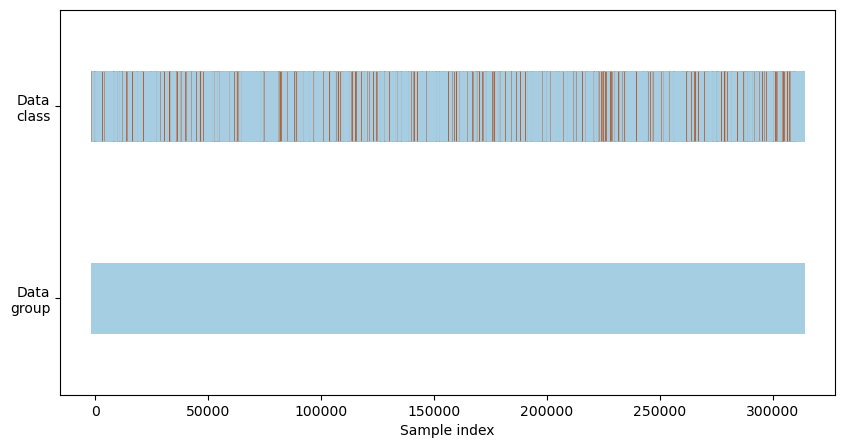

In [84]:
visualize_groups(train_y, groups, "no groups")

In [88]:
n_splits = 5
groups = None

/tmp/ipykernel_4107164/1298143750.py:29: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


<Axes: title={'center': 'KFold'}, xlabel='Sample index', ylabel='CV iteration'>

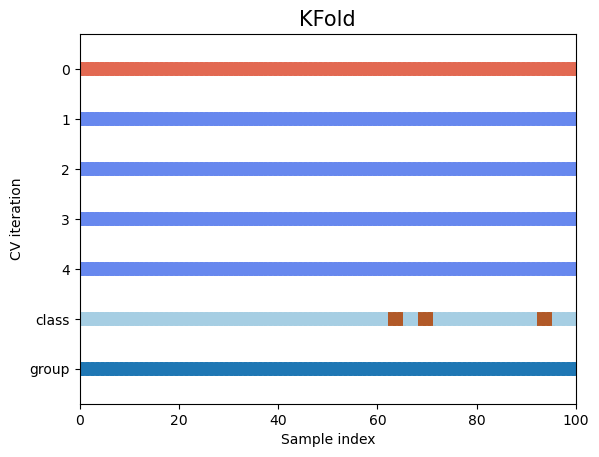

In [89]:
fig, ax = plt.subplots()
cv = KFold(n_splits)
plot_cv_indices(cv, train_X, train_y, groups, ax, n_splits)

### Create balanced datasets

In [635]:
bal_train_X, bal_train_y = balance_datasets(train_X, train_y, ratio = 1)
bal_train_X_2, bal_train_y_2 = balance_datasets(train_X, train_y, ratio = 2)


 Take 12388 samples from total of 12388 negative training samples
 Take 12388 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 37164  Total len: 74328

 X :  Min: -27.6719    Max: 23.7271   Mean: 0.0016  Std: 1.0157
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 12388 samples from total of 12388 negative training samples
 Take 24776 samples from total of 91612 negative training samples

 Balanced Dataset: # pos samples: 37164    # Neg samples: 74328  Total len: 111492

 X :  Min: -27.3326    Max: 26.3826   Mean: 0.0014  Std: 1.0076
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


In [636]:
bal_test_X, bal_test_y = balance_datasets(test_X, test_y, ratio = 1)
bal_test_X_2, bal_test_y_2 = balance_datasets(test_X, test_y, ratio = 2)


 Take 1388 samples from total of 1388 negative training samples
 Take 1388 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 4164  Total len: 8328

 X :  Min: -16.9431    Max: 19.0416   Mean: 0.0030  Std: 1.0028
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.5000  Std: 0.5000

 Take 1388 samples from total of 1388 negative training samples
 Take 2776 samples from total of 10126 negative training samples

 Balanced Dataset: # pos samples: 4164    # Neg samples: 8328  Total len: 12492

 X :  Min: -18.7677    Max: 20.9524   Mean: 0.0015  Std: 0.9780
 y :  Min: 0.0000    Max: 1.0000   Mean: 0.3333  Std: 0.4714


# **[Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

### Setup

In [315]:
try:
    del X_DATA, Y_DATA, X_TEST, Y_TEST
except:
    pass
# train_y.head()

In [316]:
X_DATA = df_train_x.iloc[:, 11:]    ## bal_train_X
X_TEST = df_test_x.iloc[:, 11:] 


In [317]:
Best_Estimators = []
df_metrics = pd.DataFrame()

In [318]:
RANDOM_STATE = 6666
NUM_JOBS = 1
Y_OFFSET = 3
# parm_C = 0.025
# parm_solver = 'lbfgs'

In [319]:
# lr_grid_parameters = {'C': [0.1, 1, 10, 100, 200], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C':  0.125, 'solver': 'lbfgs',}
# lr_grid_parameters = {'C': [1.1e+05, 1.0e+05, 7.5e+04, 5.0e+04, 2.5e+04, 1.25e+04], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+04, 1.0e+04, 7.5e+03, 5.0e+03, 2.5e+03, 1.25e+03], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+03, 1.0e+03, 7.5e+02, 5.0e+02, 2.5e+02, 1.25e+02], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+02, 1.0e+02, 7.5e+01, 5.0e+01, 2.5e+01, 1.25e+01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04], 'solver': ['lbfgs'],}
# lr_grid_parameters = {'C': [1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

# lr_grid_parameters = {'C': [1.1e+01, 1.0e+01, 7.5e+00, 5.0e+00, 2.5e+00, 1.25e+00 ,
#                             1.1e-00, 1.0e-00, 7.5e-01, 5.0e-01, 2.5e-01, 1.25e-01 ,
#                             1.1e-01, 1.0e-01, 7.5e-02, 5.0e-02, 2.5e-02, 1.25e-02 ,
#                             1.1e-02, 1.0e-02, 7.5e-03, 5.0e-03, 2.5e-03, 1.25e-03 ,
#                             1.1e-03, 1.0e-03, 7.5e-04, 5.0e-04, 2.5e-04, 1.25e-04 ,
#                             1.1e-04, 1.0e-04, 7.5e-05, 5.0e-05, 2.5e-05, 1.25e-05], 'solver': ['lbfgs'],}

In [234]:
# PARM_SET = lr_grid_parameters
# PARM_SET
# RANDOM_STATE
len(selected_label_indices)

185

## Training

In [235]:
for i in range(len(selected_label_indices)):
    Y_INDEX = selected_label_indices[i]
    print(f" Index: {i}  -- Bit: {Y_INDEX}")
    Y_DATA = df_train_y.iloc[:, Y_INDEX + Y_OFFSET] ## bal_train_y
    Y_TEST = df_test_y.iloc[:, Y_INDEX + Y_OFFSET] ## bal_train_y

    logreg = LogisticRegression(penalty = 'l2', 
                                C=parm_C, 
                                random_state = RANDOM_STATE, 
                                max_iter = 10000, 
                                tol = 1e-5, 
                                n_jobs = 1, 
                                class_weight=None, 
                                solver = parm_solver,
                                verbose = 1)

    clf = logreg.fit(X_DATA, Y_DATA)
    Y_PRED = clf.predict(X_TEST)
    Y_SCORE = clf.predict_proba(X_TEST) 

    # clf.n_iter_, clf.n_jobs, clf.n_features_in_, clf.penalty, clf.C
    # clf.classes_, clf.coef_.shape, clf.dual, clf.l1_ratio, clf.random_state
    # clf.solver ,clf.tol, clf.fit_intercept, clf.intercept_, clf.intercept_scaling, clf.verbose, clf.warm_start
    # Y_PRED[:10]
    # Y_SCORE[:10]

    compute_metrics(Y_TEST, Y_PRED)
    roc_auc = skm.roc_auc_score(Y_TEST , Y_SCORE[:,1])
    precisions, recalls, f1s, supports = skm.precision_recall_fscore_support(Y_TEST, Y_PRED)
    print(f" roc_auc: {roc_auc:.5f}")

    # reordered_col_names = ['Y_bit','param_C', 'param_solver',  'Y_bit_pct', 'mean_test_score', 
    #                        'precision', 'accuracy', 'recall',  'f1', 'std_test_score',                         
    #                        'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 
    #                        'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
    #                        'params', 'random_seed']
    _tmp_dict = {'Y_bit'             : Y_INDEX, 
                 'param_C'           : parm_C,
                 'param_solver'      : parm_solver,
                 'Y_bit_pct'         : bit_counter_pct[Y_INDEX],
                 'mean_test_score'   : roc_auc,
                 'precision'         : precisions[1],
                 'accuracy'          : skm.accuracy_score(Y_TEST, Y_PRED, ),
                 'recall'            : recalls[1],
                 'f1'                : f1s[1],
                 'std_test_score'    : 0.0,
                 'split0_test_score' : 0.0, 
                 'split1_test_score' : 0.0,  
                 'split2_test_score' : 0.0,
                 'split3_test_score' : 0.0, 
                 'mean_fit_time'     : 0.0,
                 'std_fit_time'      : 0.0,
                 'mean_score_time'   : 0.0,  
                 'std_score_time'    : 0.0,
                 'params'            : "none", 
                 'random_seed'       : RANDOM_STATE}
    _tmp_df = pd.DataFrame(_tmp_dict, index = [Y_INDEX])
    _tmp_df
    # _tmp_dict
    # _tmp_df = _tmp_df[reordered_col_names]
    
    ### Save best estimator and metrics
    
    # Append Best_Estimator
    # Best_Estimators.append((vt_logreg.best_estimator_, vt_logreg.best_params_))
    
    ### Append metrics
    
    df_metrics = pd.concat((df_metrics, _tmp_df))
    df_metrics.shape
    df_metrics
    # df_metrics.sort_values('mean_test_score')
    
    # if i == 5:
    #     print(f" index: {i} Y_INDEX: {Y_INDEX} -- break")
    #     break

 Index: 0  -- Bit: 0


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.04163D+03

At iterate   50    f=  1.91485D+05    |proj g|=  1.61278D+02

At iterate  100    f=  1.91461D+05    |proj g|=  6.74246D+01

At iterate  150    f=  1.91456D+05    |proj g|=  3.20899D+01

At iterate  200    f=  1.91454D+05    |proj g|=  5.23157D+01

At iterate  250    f=  1.91454D+05    |proj g|=  4.53547D+00

At iterate  300    f=  1.91454D+05    |proj g|=  1.04353D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666

(1, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666

 Index: 1  -- Bit: 1
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.45720D+04


 This problem is unconstrained.



At iterate   50    f=  1.20634D+05    |proj g|=  3.00134D+02

At iterate  100    f=  1.20613D+05    |proj g|=  6.47895D+01

At iterate  150    f=  1.20607D+05    |proj g|=  1.36357D+01

At iterate  200    f=  1.20607D+05    |proj g|=  6.69143D+00

At iterate  250    f=  1.20606D+05    |proj g|=  6.39818D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    295    326      1     0     0   5.027D+00   1.206D+05
  F =   120606.01844002021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.83881     Precision: 0.83917     Recall: 0.99943     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
1      1    0.025        lbfgs   0.841169          0.54403   0.839171   0.83881  0.999432  0.912317             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
1             0.0   none         6666

(2, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666

 Index: 2  -- Bit: 2
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.46710D+04


 This problem is unconstrained.



At iterate   50    f=  1.19580D+05    |proj g|=  1.78964D+02

At iterate  100    f=  1.19534D+05    |proj g|=  3.97329D+01

At iterate  150    f=  1.19529D+05    |proj g|=  1.15027D+01

At iterate  200    f=  1.19528D+05    |proj g|=  2.03915D+01

At iterate  250    f=  1.19528D+05    |proj g|=  7.04878D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    252    283      1     0     0   3.807D+00   1.195D+05
  F =   119527.87135342200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.84429     Precision: 0.84474     Recall: 0.99934     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
2             0.0   none         6666

(3, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666

 Index: 3  -- Bit: 4
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.45100D+03


 This problem is unconstrained.



At iterate   50    f=  1.91280D+05    |proj g|=  7.98147D+02

At iterate  100    f=  1.91261D+05    |proj g|=  4.87238D+01

At iterate  150    f=  1.91255D+05    |proj g|=  2.12224D+01

At iterate  200    f=  1.91254D+05    |proj g|=  2.33011D+01

At iterate  250    f=  1.91253D+05    |proj g|=  1.22589D+01

At iterate  300    f=  1.91253D+05    |proj g|=  6.12208D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    301    342      1     0     0   3.814D+00   1.913D+05
  F =   191252.80897819021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
4      4    0.025        lbfgs   0.530487         0.543749   0.525637   0.52746  0.94419  0.675319             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
4             0.0   none         6666

(4, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4      4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666  
4             0.0   none         6666

 Index: 4  -- Bit: 5
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.88240D+04


 This problem is unconstrained.



At iterate   50    f=  1.29802D+05    |proj g|=  1.84054D+02

At iterate  100    f=  1.29753D+05    |proj g|=  8.62396D+01

At iterate  150    f=  1.29736D+05    |proj g|=  3.14564D+01

At iterate  200    f=  1.29733D+05    |proj g|=  2.28721D+01

At iterate  250    f=  1.29732D+05    |proj g|=  1.41242D+01

At iterate  300    f=  1.29732D+05    |proj g|=  4.79233D+00

At iterate  350    f=  1.29732D+05    |proj g|=  7.56790D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    358    396      1     0     0   1.465D+00   1.297D+05
  F =   129731.84465980488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
5      5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.89628             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
5                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
5             0.0   none         6666

(5, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4      4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5      5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666  
4             0.0   none         6666  
5             0.0   none         6666

 Index: 5  -- Bit: 6


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.66700D+04

At iterate   50    f=  1.33486D+05    |proj g|=  1.09158D+02

At iterate  100    f=  1.33460D+05    |proj g|=  3.83408D+01

At iterate  150    f=  1.33453D+05    |proj g|=  5.41881D+01

At iterate  200    f=  1.33452D+05    |proj g|=  1.61279D+01

At iterate  250    f=  1.33451D+05    |proj g|=  5.23256D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    296    339      1     0     0   

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall        f1  std_test_score  \
6      6    0.025        lbfgs   0.812662         0.533952       0.81      0.81     1.0  0.895028             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
6                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
6             0.0   none         6666

(6, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4      4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5      5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6      6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666  
4             0.0   none         6666  
5             0.0   none         6666  
6             0.0   none         6666

 Index: 6  -- Bit: 8


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.98440D+04

At iterate   50    f=  1.63515D+05    |proj g|=  2.22992D+02

At iterate  100    f=  1.63447D+05    |proj g|=  9.19499D+01

At iterate  150    f=  1.63426D+05    |proj g|=  6.71466D+01

At iterate  200    f=  1.63420D+05    |proj g|=  2.54581D+01

At iterate  250    f=  1.63419D+05    |proj g|=  3.99819D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    297    338      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
8      8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.99812  0.835107             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
8                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
8             0.0   none         6666

(7, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4      4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5      5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6      6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8      8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666  
4             0.0   none         6666  
5             0.0   none         6666  
6             0.0   none         6666  
8             0.0   none         6666

 Index: 7  -- Bit: 9
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.39900D+04


 This problem is unconstrained.



At iterate   50    f=  1.19636D+05    |proj g|=  1.58923D+02

At iterate  100    f=  1.19546D+05    |proj g|=  5.96516D+01

At iterate  150    f=  1.19539D+05    |proj g|=  3.78921D+01

At iterate  200    f=  1.19537D+05    |proj g|=  3.22667D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    248    277      1     0     0   1.042D+00   1.195D+05
  F =   119536.75587537877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.84079     Precision: 0.84144     Recall: 0.99906     F1: 0.91350 

 True + labels:         10602     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
9      9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
9                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
9             0.0   none         6666

(8, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1      1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4      4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5      5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6      6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8      8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9      9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

   std_score_time params  random_seed  
0             0.0   none         6666  
1             0.0   none         6666  
2             0.0   none         6666  
4             0.0   none         6666  
5             0.0   none         6666  
6             0.0   none         6666  
8             0.0   none         6666  
9             0.0   none         6666

 Index: 8  -- Bit: 13


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.03890D+04

At iterate   50    f=  1.51884D+05    |proj g|=  2.21109D+02

At iterate  100    f=  1.51829D+05    |proj g|=  3.06090D+01

At iterate  150    f=  1.51822D+05    |proj g|=  4.68877D+01

At iterate  200    f=  1.51819D+05    |proj g|=  1.78776D+01

At iterate  250    f=  1.51819D+05    |proj g|=  4.38598D+00

At iterate  300    f=  1.51819D+05    |proj g|=  5.07777D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
13             0.0   none         6666

(9, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         6666  
8              0.0   none         6666  
9              0.0   none         6666  
13             0.0   none         6666

 Index: 9  -- Bit: 16


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.15270D+04

At iterate   50    f=  1.82307D+05    |proj g|=  3.81337D+02

At iterate  100    f=  1.82220D+05    |proj g|=  9.98450D+01

At iterate  150    f=  1.82169D+05    |proj g|=  1.94883D+02

At iterate  200    f=  1.82153D+05    |proj g|=  4.87648D+01

At iterate  250    f=  1.82147D+05    |proj g|=  2.72060D+01

At iterate  300    f=  1.82146D+05    |proj g|=  8.46231D+00

At iterate  350    f=  1.82145D+05    |proj g|=  1.15930D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
16             0.0   none         6666

(10, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         6666  
8              0.0   none         6666  
9              0.0   none         6666  
13             0.0   none         6666  
16             0.0   none         6666

 Index: 10  -- Bit: 17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.21650D+04


 This problem is unconstrained.



At iterate   50    f=  1.75435D+05    |proj g|=  2.50725D+02

At iterate  100    f=  1.75252D+05    |proj g|=  2.52054D+02

At iterate  150    f=  1.75200D+05    |proj g|=  4.18044D+01

At iterate  200    f=  1.75180D+05    |proj g|=  2.46681D+01

At iterate  250    f=  1.75179D+05    |proj g|=  1.64134D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    297    335      1     0     0   1.110D+01   1.752D+05
  F =   175178.95255697216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.64802     Precision: 0.65190     Recall: 0.98215     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
17     17    0.025        lbfgs    0.65211         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
17             0.0   none         6666

(11, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         6666  
8              0.0   none         6666  
9              0.0   none         6666  
13             0.0   none         6666  
16             0.0   none         6666  
17             0.0   none         6666

 Index: 11  -- Bit: 18


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.33480D+04

At iterate   50    f=  1.83400D+05    |proj g|=  1.30455D+02

At iterate  100    f=  1.83373D+05    |proj g|=  4.60117D+01

At iterate  150    f=  1.83363D+05    |proj g|=  4.05997D+01

At iterate  200    f=  1.83361D+05    |proj g|=  1.08887D+01

At iterate  250    f=  1.83360D+05    |proj g|=  3.27014D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    298    343      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
18             0.0   none         6666

(12, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         6666  
8              0.0   none         6666  
9              0.0   none         6666  
13             0.0   none         6666  
16             0.0   none         6666  
17             0.0   none         6666  
18             0.0   none         6666

 Index: 12  -- Bit: 19
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.95000D+04


 This problem is unconstrained.



At iterate   50    f=  1.42718D+05    |proj g|=  2.43303D+02

At iterate  100    f=  1.42661D+05    |proj g|=  1.25658D+02

At iterate  150    f=  1.42651D+05    |proj g|=  7.10391D+01

At iterate  200    f=  1.42648D+05    |proj g|=  1.34825D+01

At iterate  250    f=  1.42647D+05    |proj g|=  2.33554D+01

At iterate  300    f=  1.42647D+05    |proj g|=  6.13805D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    341    379      1     0     0   3.789D+00   1.426D+05
  F =   142646.75145239529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
19             0.0   none         6666

(13, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         6666  
8              0.0   none         6666  
9              0.0   none         6666  
13             0.0   none         6666  
16             0.0   none         6666  
17             0.0   none         6666  
18             0.0   none         6666

 Index: 13  -- Bit: 20


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.87790D+04

At iterate   50    f=  1.85078D+05    |proj g|=  7.96505D+01

At iterate  100    f=  1.84979D+05    |proj g|=  1.95148D+02

At iterate  150    f=  1.84953D+05    |proj g|=  1.95241D+02

At iterate  200    f=  1.84945D+05    |proj g|=  2.28119D+01

At iterate  250    f=  1.84943D+05    |proj g|=  1.99685D+01

At iterate  300    f=  1.84942D+05    |proj g|=  2.35953D+01

At iterate  350    f=  1.84942D+05    |proj g|=  6.53639D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
20     20    0.025        lbfgs    0.60382         0.561451   0.605395  0.605238  0.998032  0.75364             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
20                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
20             0.0   none         6666

(14, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
20                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
0              0.0   none         6666  
1              0.0   none         6666  
2              0.0   none         6666  
4              0.0   none         6666  
5              0.0   none         6666  
6              0.0   none         66

 Index: 14  -- Bit: 21


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.51670D+04

At iterate   50    f=  1.33037D+05    |proj g|=  1.45099D+02

At iterate  100    f=  1.32944D+05    |proj g|=  1.56123D+01

At iterate  150    f=  1.32933D+05    |proj g|=  4.01016D+01

At iterate  200    f=  1.32932D+05    |proj g|=  6.15205D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    223    268      1     0     0   2.064D+00   1.329D+05
  F =   132932.23904939790     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
21     21    0.025        lbfgs    0.80724         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
21                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
21             0.0   none         6666

(15, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
20                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
21                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_

 Index: 15  -- Bit: 22


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.81370D+04

At iterate   50    f=  1.83973D+05    |proj g|=  2.03859D+02

At iterate  100    f=  1.83883D+05    |proj g|=  3.49395D+02

At iterate  150    f=  1.83853D+05    |proj g|=  1.21755D+02

At iterate  200    f=  1.83838D+05    |proj g|=  5.49948D+01

At iterate  250    f=  1.83835D+05    |proj g|=  1.42269D+01

At iterate  300    f=  1.83835D+05    |proj g|=  1.76551D+01

At iterate  350    f=  1.83834D+05    |proj g|=  4.78908D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall     f1  std_test_score  \
22     22    0.025        lbfgs   0.398496         0.594993   0.662058   0.62127  0.086494  0.153             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
22                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
22             0.0   none         6666

(16, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
20                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
21                0.0                0.0   

 Index: 16  -- Bit: 23
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.93360D+04


 This problem is unconstrained.



At iterate   50    f=  1.76419D+05    |proj g|=  6.28937D+02

At iterate  100    f=  1.76253D+05    |proj g|=  1.75973D+02

At iterate  150    f=  1.76221D+05    |proj g|=  9.51665D+01

At iterate  200    f=  1.76213D+05    |proj g|=  1.50130D+01

At iterate  250    f=  1.76213D+05    |proj g|=  6.15743D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    290    323      1     0     0   1.813D+01   1.762D+05
  F =   176212.76969584194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.64159     Precision: 0.64617     Recall: 0.97525     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
23                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
23             0.0   none         6666

(17, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
20                0.0                0.0           

 Index: 17  -- Bit: 26
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02189D+05


 This problem is unconstrained.



At iterate   50    f=  1.06625D+05    |proj g|=  1.15323D+02

At iterate  100    f=  1.06600D+05    |proj g|=  3.08235D+01

At iterate  150    f=  1.06597D+05    |proj g|=  3.57817D+01

At iterate  200    f=  1.06596D+05    |proj g|=  1.35834D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    244    271      1     0     0   6.619D+00   1.066D+05
  F =   106595.82413811350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87833     Precision: 0.42105     Recall: 0.00523     F1: 0.01033 

 True + labels:          1530     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
26                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
26             0.0   none         6666

(18, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
19                0.0                0.0                0.0

 Index: 18  -- Bit: 27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.23020D+04


 This problem is unconstrained.



At iterate   50    f=  1.37448D+05    |proj g|=  2.94206D+02

At iterate  100    f=  1.37406D+05    |proj g|=  5.29604D+01

At iterate  150    f=  1.37402D+05    |proj g|=  1.85526D+01

At iterate  200    f=  1.37401D+05    |proj g|=  9.25098D+00

At iterate  250    f=  1.37400D+05    |proj g|=  3.16695D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    253    287      1     0     0   1.819D+00   1.374D+05
  F =   137400.26363159847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.80595     Precision: 0.73239     Recall: 0.02098     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall      f1  std_test_score  \
27     27    0.025        lbfgs   0.203095          0.60753   0.732394  0.805952  0.020985  0.0408             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
27                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
27             0.0   none         6666

(19, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
18                0.0                0.0                0.0        

 Index: 19  -- Bit: 30


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.95860D+04

At iterate   50    f=  1.28802D+05    |proj g|=  1.13913D+02

At iterate  100    f=  1.28765D+05    |proj g|=  2.36754D+01

At iterate  150    f=  1.28759D+05    |proj g|=  1.39360D+01

At iterate  200    f=  1.28757D+05    |proj g|=  1.90738D+01

At iterate  250    f=  1.28757D+05    |proj g|=  4.46758D+00

At iterate  300    f=  1.28757D+05    |proj g|=  7.06747D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
30     30    0.025        lbfgs   0.176818         0.566823        0.0  0.827937     0.0  0.0             0.0                0.0   

    split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
30                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

    random_seed  
30         6666

(20, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                0.0                0.0                0.0                

 Index: 20  -- Bit: 31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.35430D+04


 This problem is unconstrained.



At iterate   50    f=  1.82262D+05    |proj g|=  1.68359D+02

At iterate  100    f=  1.82177D+05    |proj g|=  1.57415D+02

At iterate  150    f=  1.82146D+05    |proj g|=  7.74497D+01

At iterate  200    f=  1.82140D+05    |proj g|=  4.23403D+01

At iterate  250    f=  1.82139D+05    |proj g|=  1.06656D+01

At iterate  300    f=  1.82139D+05    |proj g|=  4.01046D+00

At iterate  350    f=  1.82139D+05    |proj g|=  4.51953D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    355    401      1     0     0   6.336D+00   1.821D+05
  F =   182138.63570015648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
31                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
31             0.0   none         6666

(21, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
16                0.0                0.0                0.0                0.0     

 Index: 21  -- Bit: 32
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.72750D+04


 This problem is unconstrained.



At iterate   50    f=  1.81656D+05    |proj g|=  1.63424D+02

At iterate  100    f=  1.81634D+05    |proj g|=  1.02556D+02

At iterate  150    f=  1.81624D+05    |proj g|=  1.37336D+02

At iterate  200    f=  1.81623D+05    |proj g|=  1.34373D+01

At iterate  250    f=  1.81622D+05    |proj g|=  9.18388D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    298    335      1     0     0   6.096D+00   1.816D+05
  F =   181622.14531552617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.63698     Precision: 0.63728     Recall: 0.99863     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
32     32    0.025        lbfgs    0.63447         0.542082   0.637281  0.636984  0.99863  0.778047             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
32                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
32             0.0   none         6666

(22, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
13                0.0                0.0                0.0                0.0            0

 Index: 22  -- Bit: 33
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.53240D+04


 This problem is unconstrained.



At iterate   50    f=  1.48323D+05    |proj g|=  1.91320D+02

At iterate  100    f=  1.48295D+05    |proj g|=  7.45328D+01

At iterate  150    f=  1.48289D+05    |proj g|=  3.23175D+01

At iterate  200    f=  1.48288D+05    |proj g|=  1.96860D+01

At iterate  250    f=  1.48288D+05    |proj g|=  5.06752D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    259    295      1     0     0   3.216D+00   1.483D+05
  F =   148287.81829750584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.76103     Precision: 0.76100     Recall: 0.99990     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
33                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
33             0.0   none         6666

(23, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
9                 0.0                0.0                0.0                0.0            0.0      

 Index: 23  -- Bit: 34


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.62300D+04

At iterate   50    f=  1.89226D+05    |proj g|=  6.65732D+01

At iterate  100    f=  1.89196D+05    |proj g|=  1.08314D+02

At iterate  150    f=  1.89192D+05    |proj g|=  1.71874D+01

At iterate  200    f=  1.89190D+05    |proj g|=  1.64921D+01

At iterate  250    f=  1.89190D+05    |proj g|=  1.48217D+01

At iterate  300    f=  1.89190D+05    |proj g|=  3.66623D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
34     34    0.025        lbfgs    0.44145         0.567127   0.560494  0.568968  0.082112  0.14324             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
34                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
34             0.0   none         6666

(24, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
8                 0.0                0.0                0.0                0.0            0.0           0.0

 Index: 24  -- Bit: 35
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.89090D+04


 This problem is unconstrained.



At iterate   50    f=  1.73451D+05    |proj g|=  5.41895D+02

At iterate  100    f=  1.73379D+05    |proj g|=  1.28803D+02

At iterate  150    f=  1.73365D+05    |proj g|=  2.23220D+01

At iterate  200    f=  1.73363D+05    |proj g|=  1.71641D+01

At iterate  250    f=  1.73361D+05    |proj g|=  1.94476D+01

At iterate  300    f=  1.73361D+05    |proj g|=  6.64416D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    337    377      1     0     0   2.224D+01   1.734D+05
  F =   173360.88210230216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
35     35    0.025        lbfgs   0.676439         0.557074   0.659169   0.65881  0.998675  0.794158             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
35                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
35             0.0   none         6666

(25, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
6                 0.0                0.0                0.0                0.0            0.0           0.0        

 Index: 25  -- Bit: 39


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.65020D+04

At iterate   50    f=  1.31932D+05    |proj g|=  1.41526D+02

At iterate  100    f=  1.31906D+05    |proj g|=  6.00965D+01

At iterate  150    f=  1.31901D+05    |proj g|=  7.28159D+01

At iterate  200    f=  1.31900D+05    |proj g|=  2.89208D+01

At iterate  250    f=  1.31899D+05    |proj g|=  1.11755D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    259    292      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
39     39    0.025        lbfgs   0.187944          0.61892   0.666667  0.818175  0.013871  0.027176             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
39                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
39             0.0   none         6666

(26, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                 0.0                0.0                0.0                0.0            0.0           0.0              0.

 Index: 26  -- Bit: 42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.10900D+04


 This problem is unconstrained.



At iterate   50    f=  1.87815D+05    |proj g|=  1.19586D+02

At iterate  100    f=  1.87767D+05    |proj g|=  9.70088D+01

At iterate  150    f=  1.87750D+05    |proj g|=  7.38745D+01

At iterate  200    f=  1.87743D+05    |proj g|=  2.19256D+01

At iterate  250    f=  1.87742D+05    |proj g|=  8.65622D+00

At iterate  300    f=  1.87742D+05    |proj g|=  1.33237D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    335    373      1     0     0   2.545D+00   1.877D+05
  F =   187741.81404693428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
42                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
42             0.0   none         6666

(27, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5  

 Index: 27  -- Bit: 43
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.22920D+04


 This problem is unconstrained.



At iterate   50    f=  1.83253D+05    |proj g|=  3.83437D+02

At iterate  100    f=  1.83159D+05    |proj g|=  6.94925D+01

At iterate  150    f=  1.83140D+05    |proj g|=  7.30729D+01

At iterate  200    f=  1.83128D+05    |proj g|=  1.33000D+02

At iterate  250    f=  1.83127D+05    |proj g|=  6.67617D+00

At iterate  300    f=  1.83127D+05    |proj g|=  6.62312D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    338    375      1     0     0   3.923D+00   1.831D+05
  F =   183126.39587022396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
43     43    0.025        lbfgs   0.616494          0.57891   0.624112  0.622698  0.99415  0.766824             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
43                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
43             0.0   none         6666

(28, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4          

 Index: 28  -- Bit: 44
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.52760D+04


 This problem is unconstrained.



At iterate   50    f=  1.75782D+05    |proj g|=  3.05901D+02

At iterate  100    f=  1.75730D+05    |proj g|=  7.34480D+01

At iterate  150    f=  1.75712D+05    |proj g|=  5.24994D+01

At iterate  200    f=  1.75704D+05    |proj g|=  5.46808D+01

At iterate  250    f=  1.75703D+05    |proj g|=  4.13588D+01

At iterate  300    f=  1.75703D+05    |proj g|=  3.84380D+01

At iterate  350    f=  1.75703D+05    |proj g|=  6.42367D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    375    417      1     0     0   4.007D+00   1.757D+05
  F =   175702.59270910913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
44     44    0.025        lbfgs   0.336667         0.578314    0.61658  0.659048  0.027413  0.052492             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
44                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
44             0.0   none         6666

(29, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                 0

 Index: 29  -- Bit: 45


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.97110D+04

At iterate   50    f=  1.77188D+05    |proj g|=  4.13882D+02

At iterate  100    f=  1.77030D+05    |proj g|=  8.04559D+01

At iterate  150    f=  1.77011D+05    |proj g|=  1.56650D+02

At iterate  200    f=  1.77002D+05    |proj g|=  1.32289D+01

At iterate  250    f=  1.77002D+05    |proj g|=  3.98504D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    287    327      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
45                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
45             0.0   none         6666

(30, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                 0.0      

 Index: 30  -- Bit: 48
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.38670D+04


 This problem is unconstrained.



At iterate   50    f=  1.20899D+05    |proj g|=  2.36900D+02

At iterate  100    f=  1.20860D+05    |proj g|=  3.34395D+01

At iterate  150    f=  1.20858D+05    |proj g|=  6.60401D+00

At iterate  200    f=  1.20857D+05    |proj g|=  8.50623D+00

At iterate  250    f=  1.20857D+05    |proj g|=  1.35590D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    255    285      1     0     0   7.963D+00   1.209D+05
  F =   120856.99019610106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.84627     Precision: 0.47059     Recall: 0.00827     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
48     48    0.025        lbfgs   0.161374         0.603312   0.470588   0.84627  0.008269  0.016252             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
48                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
48             0.0   none         6666

(31, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                 0.0              

 Index: 31  -- Bit: 49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.37270D+04


 This problem is unconstrained.



At iterate   50    f=  1.35776D+05    |proj g|=  1.65342D+02

At iterate  100    f=  1.35722D+05    |proj g|=  3.55021D+01

At iterate  150    f=  1.35718D+05    |proj g|=  1.14200D+01

At iterate  200    f=  1.35717D+05    |proj g|=  1.06864D+01

At iterate  250    f=  1.35717D+05    |proj g|=  1.99258D+01

At iterate  300    f=  1.35717D+05    |proj g|=  9.48345D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    307    349      1     0     0   6.817D+00   1.357D+05
  F =   135716.85725942068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
49                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
49             0.0   none         6666

(32, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   

    split0_test_score  split1_test_score  s

 Index: 32  -- Bit: 52
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.10514D+05


 This problem is unconstrained.



At iterate   50    f=  8.97191D+04    |proj g|=  7.64643D+01

At iterate  100    f=  8.96955D+04    |proj g|=  7.29210D+01

At iterate  150    f=  8.96873D+04    |proj g|=  1.23251D+02

At iterate  200    f=  8.96855D+04    |proj g|=  1.54016D+01

At iterate  250    f=  8.96853D+04    |proj g|=  2.36217D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    279    312      1     0     0   1.979D+00   8.969D+04
  F =   89685.248960459998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.90040     Precision: 0.30000     Recall: 0.00240     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
52     52    0.025        lbfgs    0.10132         0.625045        0.3  0.900397  0.002398  0.004758             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
52                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
52             0.0   none         6666

(33, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 33  -- Bit: 53


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.17300D+04

At iterate   50    f=  1.74710D+05    |proj g|=  1.11522D+02

At iterate  100    f=  1.74599D+05    |proj g|=  1.80434D+02

At iterate  150    f=  1.74577D+05    |proj g|=  4.65451D+01

At iterate  200    f=  1.74561D+05    |proj g|=  4.05758D+01

At iterate  250    f=  1.74558D+05    |proj g|=  3.92680D+01

At iterate  300    f=  1.74557D+05    |proj g|=  8.78396D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
53     53    0.025        lbfgs   0.349459         0.634332   0.588652  0.659921  0.094104  0.162268             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
53                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
53             0.0   none         6666

(34, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 34  -- Bit: 57


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.51630D+04

At iterate   50    f=  1.18948D+05    |proj g|=  8.50827D+01

At iterate  100    f=  1.18930D+05    |proj g|=  6.18424D+01

At iterate  150    f=  1.18927D+05    |proj g|=  1.66699D+01

At iterate  200    f=  1.18926D+05    |proj g|=  6.57848D+00

At iterate  250    f=  1.18926D+05    |proj g|=  4.99623D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    261    292      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
57     57    0.025        lbfgs   0.156699         0.587804   0.589744  0.847698  0.011942  0.02341             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
57                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
57             0.0   none         6666

(35, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 35  -- Bit: 78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.67960D+04


 This problem is unconstrained.



At iterate   50    f=  1.86226D+05    |proj g|=  1.59877D+02

At iterate  100    f=  1.86194D+05    |proj g|=  7.16234D+01

At iterate  150    f=  1.86188D+05    |proj g|=  8.67591D+01

At iterate  200    f=  1.86186D+05    |proj g|=  3.71336D+01

At iterate  250    f=  1.86185D+05    |proj g|=  3.30394D+01

At iterate  300    f=  1.86185D+05    |proj g|=  5.62083D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    310    348      1     0     0   7.629D+00   1.862D+05
  F =   186184.92304990161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
78     78    0.025        lbfgs   0.403333          0.56019   0.384615  0.606905  0.002021  0.004022             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
78                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
78             0.0   none         6666

(36, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 36  -- Bit: 79
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.90950D+04


 This problem is unconstrained.



At iterate   50    f=  1.73864D+05    |proj g|=  1.68560D+02

At iterate  100    f=  1.73845D+05    |proj g|=  3.13637D+01

At iterate  150    f=  1.73841D+05    |proj g|=  5.30326D+01

At iterate  200    f=  1.73839D+05    |proj g|=  2.41749D+01

At iterate  250    f=  1.73838D+05    |proj g|=  1.58475D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    282    319      1     0     0   6.674D+00   1.738D+05
  F =   173837.95879388758     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.68778     Precision: 0.45455     Recall: 0.00509     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
79     79    0.025        lbfgs    0.32289         0.535196   0.454545  0.687778  0.005089  0.010065             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
79                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
79             0.0   none         6666

(37, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 37  -- Bit: 80
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.39960D+04


 This problem is unconstrained.



At iterate   50    f=  1.60491D+05    |proj g|=  1.59379D+02

At iterate  100    f=  1.60471D+05    |proj g|=  8.98509D+01

At iterate  150    f=  1.60461D+05    |proj g|=  2.19921D+01

At iterate  200    f=  1.60459D+05    |proj g|=  1.06775D+02

At iterate  250    f=  1.60459D+05    |proj g|=  5.20633D+00

At iterate  300    f=  1.60458D+05    |proj g|=  7.54303D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    320    356      1     0     0   7.021D+00   1.605D+05
  F =   160458.45800934618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
80     80    0.025        lbfgs   0.269134         0.555172        0.5  0.734286  0.000597  0.001193             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
80                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
80             0.0   none         6666

(38, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 38  -- Bit: 83
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.09500D+04


 This problem is unconstrained.



At iterate   50    f=  1.79383D+05    |proj g|=  2.26849D+02

At iterate  100    f=  1.79361D+05    |proj g|=  8.77587D+01

At iterate  150    f=  1.79347D+05    |proj g|=  2.15996D+01

At iterate  200    f=  1.79346D+05    |proj g|=  1.51125D+01

At iterate  250    f=  1.79346D+05    |proj g|=  2.15070D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    293    326      1     0     0   1.785D+01   1.793D+05
  F =   179346.01625592509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.65794     Precision: 0.30769     Recall: 0.00093     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
83     83    0.025        lbfgs   0.352273         0.535575   0.307692  0.657937  0.000929  0.001853             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
83                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
83             0.0   none         6666

(39, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 39  -- Bit: 84


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.34230D+04

At iterate   50    f=  1.83398D+05    |proj g|=  3.73742D+02

At iterate  100    f=  1.83375D+05    |proj g|=  1.90490D+01

At iterate  150    f=  1.83373D+05    |proj g|=  3.73910D+01

At iterate  200    f=  1.83372D+05    |proj g|=  3.07880D+01

At iterate  250    f=  1.83372D+05    |proj g|=  4.38131D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    293    320      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
84     84    0.025        lbfgs   0.379426         0.549719   0.598039  0.620159  0.012692  0.024857             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
84                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
84             0.0   none         6666

(40, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 40  -- Bit: 86
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.27720D+04


 This problem is unconstrained.



At iterate   50    f=  1.83365D+05    |proj g|=  2.89645D+02

At iterate  100    f=  1.83306D+05    |proj g|=  2.00105D+02

At iterate  150    f=  1.83294D+05    |proj g|=  3.59701D+01

At iterate  200    f=  1.83292D+05    |proj g|=  9.38966D+00

At iterate  250    f=  1.83290D+05    |proj g|=  1.76072D+01

At iterate  300    f=  1.83290D+05    |proj g|=  1.46365D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    322    364      1     0     0   1.191D+01   1.833D+05
  F =   183289.86884259901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
86     86    0.025        lbfgs   0.618225         0.552377   0.620322  0.618333  0.990911  0.762998             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
86                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
86             0.0   none         6666

(41, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 41  -- Bit: 87
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.03700D+03


 This problem is unconstrained.



At iterate   50    f=  1.90826D+05    |proj g|=  1.82182D+02

At iterate  100    f=  1.90797D+05    |proj g|=  6.22628D+01

At iterate  150    f=  1.90786D+05    |proj g|=  8.18333D+01

At iterate  200    f=  1.90783D+05    |proj g|=  5.02805D+01

At iterate  250    f=  1.90782D+05    |proj g|=  1.13944D+01

At iterate  300    f=  1.90781D+05    |proj g|=  5.49533D+00

At iterate  350    f=  1.90781D+05    |proj g|=  1.43433D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    360    398      1     0     0   7.036D+00   1.908D+05
  F =   190781.21262438718     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
87     87    0.025        lbfgs   0.528994         0.554637   0.529194   0.53373  0.899111  0.66625             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
87                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
87             0.0   none         6666

(42, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 42  -- Bit: 91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.83180D+04


 This problem is unconstrained.



At iterate   50    f=  1.74403D+05    |proj g|=  6.03998D+01

At iterate  100    f=  1.74381D+05    |proj g|=  5.25813D+01

At iterate  150    f=  1.74375D+05    |proj g|=  8.21177D+01

At iterate  200    f=  1.74373D+05    |proj g|=  2.97922D+01

At iterate  250    f=  1.74372D+05    |proj g|=  1.16485D+01

At iterate  300    f=  1.74372D+05    |proj g|=  2.74148D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    300    337      1     0     0   2.741D+00   1.744D+05
  F =   174371.61336847127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
91     91    0.025        lbfgs   0.325693         0.554634        0.0  0.684683     0.0  0.0             0.0                0.0   

    split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
91                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

    random_seed  
91         6666

(43, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 43  -- Bit: 94


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.75200D+04

At iterate   50    f=  1.89435D+05    |proj g|=  1.26772D+02

At iterate  100    f=  1.89427D+05    |proj g|=  5.49733D+01

At iterate  150    f=  1.89421D+05    |proj g|=  4.33564D+01

At iterate  200    f=  1.89420D+05    |proj g|=  1.61404D+01

At iterate  250    f=  1.89419D+05    |proj g|=  5.41906D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    287    319      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
94     94    0.025        lbfgs   0.436797           0.5535   0.471014  0.570159  0.024074  0.045807             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
94                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
94             0.0   none         6666

(44, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 44  -- Bit: 95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.79690D+04


 This problem is unconstrained.



At iterate   50    f=  1.85959D+05    |proj g|=  1.12400D+02

At iterate  100    f=  1.85947D+05    |proj g|=  1.02916D+02

At iterate  150    f=  1.85942D+05    |proj g|=  4.38307D+01

At iterate  200    f=  1.85940D+05    |proj g|=  3.17430D+01

At iterate  250    f=  1.85940D+05    |proj g|=  1.44090D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    279    313      1     0     0   1.393D+01   1.859D+05
  F =   185940.09178266124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.61587     Precision: 0.51701     Recall: 0.01569     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
95     95    0.025        lbfgs   0.399102         0.535986   0.517007  0.615873  0.015686  0.030449             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
95                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
95             0.0   none         6666

(45, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 45  -- Bit: 96
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.83110D+04


 This problem is unconstrained.



At iterate   50    f=  1.66445D+05    |proj g|=  2.28408D+02

At iterate  100    f=  1.66437D+05    |proj g|=  6.57454D+01

At iterate  150    f=  1.66434D+05    |proj g|=  1.44891D+01

At iterate  200    f=  1.66434D+05    |proj g|=  1.83229D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    223    248      1     0     0   2.143D+01   1.664D+05
  F =   166433.86517820068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.71413     Precision: 1.00000     Recall: 0.00028     F1: 0.00055 

 True + labels:          3603     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
96     96    0.025        lbfgs   0.289643          0.54284        1.0  0.714127  0.000278  0.000555             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
96                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
96             0.0   none         6666

(46, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 46  -- Bit: 98
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.06305D+05


 This problem is unconstrained.



At iterate   50    f=  9.96012D+04    |proj g|=  3.30779D+01

At iterate  100    f=  9.95973D+04    |proj g|=  3.02077D+01

At iterate  150    f=  9.95966D+04    |proj g|=  9.54491D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    190    219      1     0     0   7.698D+00   9.960D+04
  F =   99596.536771465690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.88381     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          1464     ratio to total:  0.11619
 Predicted + labels:        0     ratio to total:  

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
98     98    0.025        lbfgs   0.116504         0.522275        0.0   0.88381     0.0  0.0             0.0                0.0   

    split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
98                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

    random_seed  
98         6666

(47, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 47  -- Bit: 99


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.74560D+04

At iterate   50    f=  1.86228D+05    |proj g|=  9.23630D+01

At iterate  100    f=  1.86214D+05    |proj g|=  5.83363D+01

At iterate  150    f=  1.86210D+05    |proj g|=  4.11237D+01

At iterate  200    f=  1.86210D+05    |proj g|=  3.85000D+01

At iterate  250    f=  1.86209D+05    |proj g|=  4.69636D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    254    290      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
99     99    0.025        lbfgs   0.400952         0.539953   0.558824  0.606508  0.003829  0.007606             0.0   

    split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
99                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

    std_score_time params  random_seed  
99             0.0   none         6666

(48, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2       2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8       8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16     16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17     17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18     18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19     19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20     20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21     21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22     22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23     23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30     30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31     31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32     32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33     33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34     34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35     35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42     42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43     43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44     44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49     49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52     52    0.025        lbfgs   0.101320  

 Index: 48  -- Bit: 100
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.64930D+04


 This problem is unconstrained.



At iterate   50    f=  1.33800D+05    |proj g|=  4.05145D+01

At iterate  100    f=  1.33798D+05    |proj g|=  1.73807D+01

At iterate  150    f=  1.33797D+05    |proj g|=  1.23665D+01

At iterate  200    f=  1.33797D+05    |proj g|=  1.06974D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    200    228      1     0     0   1.070D+01   1.338D+05
  F =   133796.65018883193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.79913     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          2529     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
100    100    0.025        lbfgs   0.187976         0.525737        0.0  0.799127     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
100                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
100         6666

(49, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 49  -- Bit: 102
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.61700D+04


 This problem is unconstrained.



At iterate   50    f=  1.76001D+05    |proj g|=  1.33988D+02

At iterate  100    f=  1.75978D+05    |proj g|=  1.40672D+02

At iterate  150    f=  1.75970D+05    |proj g|=  1.08743D+02

At iterate  200    f=  1.75968D+05    |proj g|=  5.58903D+01

At iterate  250    f=  1.75966D+05    |proj g|=  1.44536D+01

At iterate  300    f=  1.75966D+05    |proj g|=  5.96620D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    303    341      1     0     0   2.929D+00   1.760D+05
  F =   175965.74193078399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
102    102    0.025        lbfgs   0.666558         0.530565   0.659216  0.658651  0.997953  0.793964             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
102                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
102             0.0   none         6666

(50, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 50  -- Bit: 103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.05070D+04


 This problem is unconstrained.



At iterate   50    f=  1.84833D+05    |proj g|=  1.02629D+02

At iterate  100    f=  1.84797D+05    |proj g|=  4.72576D+01

At iterate  150    f=  1.84791D+05    |proj g|=  4.66617D+01

At iterate  200    f=  1.84790D+05    |proj g|=  1.25003D+01

At iterate  250    f=  1.84790D+05    |proj g|=  9.53492D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    285    317      1     0     0   1.205D+01   1.848D+05
  F =   184789.64379145598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.60817     Precision: 0.60960     Recall: 0.99258     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
103    103    0.025        lbfgs   0.610054         0.520705     0.6096  0.608175  0.992575  0.755315             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
103                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
103             0.0   none         6666

(51, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 51  -- Bit: 104
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.28480D+04


 This problem is unconstrained.



At iterate   50    f=  1.38459D+05    |proj g|=  2.22595D+02

At iterate  100    f=  1.38418D+05    |proj g|=  6.22052D+01

At iterate  150    f=  1.38409D+05    |proj g|=  1.96631D+01

At iterate  200    f=  1.38408D+05    |proj g|=  4.58920D+01

At iterate  250    f=  1.38408D+05    |proj g|=  7.30725D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    296    337      1     0     0   9.856D+00   1.384D+05
  F =   138408.01325664576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.80167     Precision: 0.00000     Recall: 0.00000     

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
104    104    0.025        lbfgs   0.201126         0.556009        0.0  0.801667     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
104                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
104         6666

(52, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 52  -- Bit: 107
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.83950D+04


 This problem is unconstrained.



At iterate   50    f=  1.66177D+05    |proj g|=  3.31859D+02

At iterate  100    f=  1.66153D+05    |proj g|=  1.13612D+02

At iterate  150    f=  1.66141D+05    |proj g|=  1.74587D+01

At iterate  200    f=  1.66140D+05    |proj g|=  2.31049D+01

At iterate  250    f=  1.66139D+05    |proj g|=  4.09780D+00

At iterate  300    f=  1.66139D+05    |proj g|=  7.62034D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    344    386      1     0     0   3.602D+00   1.661D+05
  F =   166138.88306160504     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
107    107    0.025        lbfgs    0.28934         0.539223   0.333333  0.721746  0.000571  0.00114             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
107                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
107             0.0   none         6666

(53, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 53  -- Bit: 108
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.21750D+04


 This problem is unconstrained.



At iterate   50    f=  1.62695D+05    |proj g|=  1.62635D+02

At iterate  100    f=  1.62678D+05    |proj g|=  4.50738D+01

At iterate  150    f=  1.62673D+05    |proj g|=  5.50413D+01

At iterate  200    f=  1.62671D+05    |proj g|=  2.25106D+01

At iterate  250    f=  1.62671D+05    |proj g|=  4.73459D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    253    283      1     0     0   7.074D+00   1.627D+05
  F =   162670.59084116662     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.72238     Precision: 0.43478     Recall: 0.00286     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
108    108    0.025        lbfgs   0.275703         0.550535   0.434783  0.722381  0.002861  0.005685             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
108                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
108             0.0   none         6666

(54, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 54  -- Bit: 110


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.98400D+03

At iterate   50    f=  1.90378D+05    |proj g|=  2.78613D+02

At iterate  100    f=  1.90316D+05    |proj g|=  1.45452D+02

At iterate  150    f=  1.90301D+05    |proj g|=  1.68064D+02

At iterate  200    f=  1.90295D+05    |proj g|=  4.26285D+01

At iterate  250    f=  1.90293D+05    |proj g|=  1.58200D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    276    304      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
110    110    0.025        lbfgs   0.536017         0.555217    0.54543  0.544048  0.893778  0.677447             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
110                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
110             0.0   none         6666

(55, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 55  -- Bit: 111
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.07820D+04


 This problem is unconstrained.



At iterate   50    f=  1.90264D+05    |proj g|=  2.29276D+02

At iterate  100    f=  1.90221D+05    |proj g|=  1.10495D+02

At iterate  150    f=  1.90212D+05    |proj g|=  5.19766D+01

At iterate  200    f=  1.90208D+05    |proj g|=  3.82733D+01

At iterate  250    f=  1.90207D+05    |proj g|=  1.86754D+01

At iterate  300    f=  1.90207D+05    |proj g|=  1.86156D+01

At iterate  350    f=  1.90206D+05    |proj g|=  1.79160D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    366    417      1     0     0   1.110D+01   1.902D+05
  F =   190206.34098186344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
111    111    0.025        lbfgs   0.461104         0.553479   0.519769  0.550873  0.094561  0.160012             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
111                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
111             0.0   none         6666

(56, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 56  -- Bit: 127


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.08714D+05

At iterate   50    f=  9.35695D+04    |proj g|=  2.30824D+02

At iterate  100    f=  9.35387D+04    |proj g|=  3.21259D+01

At iterate  150    f=  9.35344D+04    |proj g|=  3.79152D+01

At iterate  200    f=  9.35339D+04    |proj g|=  6.67220D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    233    266      1     0     0   6.332D+00   9.353D+04
  F =   93533.881605997085     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
127    127    0.025        lbfgs   0.107814         0.610727   0.166667  0.903016  0.000821  0.001634             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
127                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
127             0.0   none         6666

(57, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 57  -- Bit: 140
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.72060D+04


 This problem is unconstrained.



At iterate   50    f=  1.56491D+05    |proj g|=  2.26336D+02

At iterate  100    f=  1.56436D+05    |proj g|=  2.95108D+02

At iterate  150    f=  1.56417D+05    |proj g|=  3.67386D+01

At iterate  200    f=  1.56407D+05    |proj g|=  2.88113D+02

At iterate  250    f=  1.56405D+05    |proj g|=  8.13921D+00

At iterate  300    f=  1.56405D+05    |proj g|=  1.53491D+01

At iterate  350    f=  1.56405D+05    |proj g|=  1.03475D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    372    424      1     0     0   3.042D+00   1.564D+05
  F =   156404.82024900508     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
140    140    0.025        lbfgs   0.257554           0.5903   0.540816  0.742063  0.016268  0.031585             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
140                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
140             0.0   none         6666

(58, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 58  -- Bit: 141


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.68511D+04

At iterate   50    f=  1.89295D+05    |proj g|=  3.61561D+02

At iterate  100    f=  1.89179D+05    |proj g|=  2.20085D+02

At iterate  150    f=  1.89154D+05    |proj g|=  8.14956D+01

At iterate  200    f=  1.89139D+05    |proj g|=  9.99760D+01

At iterate  250    f=  1.89138D+05    |proj g|=  1.91258D+01

At iterate  300    f=  1.89138D+05    |proj g|=  6.83267D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
141    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
141                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
141             0.0   none         6666

(59, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 59  -- Bit: 142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.79420D+04


 This problem is unconstrained.



At iterate   50    f=  1.30846D+05    |proj g|=  1.05990D+02

At iterate  100    f=  1.30789D+05    |proj g|=  1.06539D+02

At iterate  150    f=  1.30776D+05    |proj g|=  3.37431D+01

At iterate  200    f=  1.30771D+05    |proj g|=  5.80384D+01

At iterate  250    f=  1.30771D+05    |proj g|=  8.21360D+00

At iterate  300    f=  1.30771D+05    |proj g|=  3.71023D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    331    374      1     0     0   1.655D+00   1.308D+05
  F =   130770.57899514401     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
142    142    0.025        lbfgs   0.182749         0.569277   0.485714  0.822778  0.007616  0.014998             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
142                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
142             0.0   none         6666

(60, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6        6    0.025        lbfgs   0.812662         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
8        8    0.025        lbfgs   0.715887         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
16      16    0.025        lbfgs   0.386266         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
18      18    0.025        lbfgs   0.620303         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
19      19    0.025        lbfgs   0.786797         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
20      20    0.025        lbfgs   0.603820         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
22      22    0.025        lbfgs   0.398496         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
30      30    0.025        lbfgs   0.176818         0.566823   0.000000  0.827937  0.000000  0.000000             0.0   
31      31    0.025        lbfgs   0.378994         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
32      32    0.025        lbfgs   0.634470         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
33      33    0.025        lbfgs   0.771732         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
34      34    0.025        lbfgs   0.441450         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
35      35    0.025        lbfgs   0.676439         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
42      42    0.025        lbfgs   0.576082         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
43      43    0.025        lbfgs   0.616494         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
44      44    0.025        lbfgs   0.336667         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
52      52  

 Index: 60  -- Bit: 143
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.72630D+04


 This problem is unconstrained.



At iterate   50    f=  1.80624D+05    |proj g|=  1.30443D+03

At iterate  100    f=  1.80511D+05    |proj g|=  5.01846D+02

At iterate  150    f=  1.80485D+05    |proj g|=  4.52753D+01

At iterate  200    f=  1.80475D+05    |proj g|=  5.51616D+01

At iterate  250    f=  1.80469D+05    |proj g|=  8.27223D+01

At iterate  300    f=  1.80469D+05    |proj g|=  1.09647D+01

At iterate  350    f=  1.80468D+05    |proj g|=  1.12124D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    353    391      1     0     0   7.571D+00   1.805D+05
  F =   180468.28604234487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
143             0.0   none         6666

(61, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
127    127    0.025        lbfgs   0.107814         0.610727   0.166667  0.903016  0.000821  0.001634             0.0   
140    140    0.025        lbfgs   0.257554         0.590300   0.540816  0.742063  0.016268  0.031585             0.0   
141    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   
142    142    0.025        lbfgs   0.182749         0.569277   0.485714  0.822778  0.007616  0.014998             0.0   
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
127                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
140                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
141                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
142                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
127             0.0   none         6666  
140             0.0   none         6666  
141             0.0   none         6666  
142             0.0   none         6666  
143             0.0   none         6666  

[61 rows x 20 columns]

 Index: 61  -- Bit: 144
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.36360D+04


 This problem is unconstrained.



At iterate   50    f=  1.61572D+05    |proj g|=  4.92562D+01

At iterate  100    f=  1.61565D+05    |proj g|=  5.13464D+01

At iterate  150    f=  1.61563D+05    |proj g|=  3.16151D+01

At iterate  200    f=  1.61562D+05    |proj g|=  1.05717D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    241    271      1     0     0   5.098D+00   1.616D+05
  F =   161562.21756170905     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.73127     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          3384     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
144    144    0.025        lbfgs   0.270433          0.52995        0.0   0.73127     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
144                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
144         6666

(62, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
140    140    0.025        lbfgs   0.257554         0.590300   0.540816  0.742063  0.016268  0.031585             0.0   
141    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   
142    142    0.025        lbfgs   0.182749         0.569277   0.485714  0.822778  0.007616  0.014998             0.0   
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   
144    144    0.025        lbfgs   0.270433         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
140                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
141                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
142                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
144                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
140             0.0   none         6666  
141             0.0   none         6666  
142             0.0   none         6666  
143             0.0   none         6666  
144             0.0   none         6666  

[62 rows x 20 columns]

 Index: 62  -- Bit: 146
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.68840D+04


 This problem is unconstrained.



At iterate   50    f=  1.75458D+05    |proj g|=  7.05799D+01

At iterate  100    f=  1.75448D+05    |proj g|=  7.70440D+01

At iterate  150    f=  1.75443D+05    |proj g|=  3.40392D+01

At iterate  200    f=  1.75441D+05    |proj g|=  1.56762D+01

At iterate  250    f=  1.75441D+05    |proj g|=  7.39452D+00

At iterate  300    f=  1.75441D+05    |proj g|=  7.18118D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    314    347      1     0     0   3.393D+00   1.754D+05
  F =   175440.67369307074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
146             0.0   none         6666

(63, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
141    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   
142    142    0.025        lbfgs   0.182749         0.569277   0.485714  0.822778  0.007616  0.014998             0.0   
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   
144    144    0.025        lbfgs   0.270433         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
141                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
142                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
144                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
141             0.0   none         6666  
142             0.0   none         6666  
143             0.0   none         6666  
144             0.0   none         6666  
146             0.0   none         6666  

[63 rows x 20 columns]

 Index: 63  -- Bit: 147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.58500D+03


 This problem is unconstrained.



At iterate   50    f=  1.91634D+05    |proj g|=  1.71993D+02

At iterate  100    f=  1.91613D+05    |proj g|=  9.52870D+01

At iterate  150    f=  1.91607D+05    |proj g|=  4.21600D+01

At iterate  200    f=  1.91606D+05    |proj g|=  2.93495D+01

At iterate  250    f=  1.91605D+05    |proj g|=  1.32683D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    286    323      1     0     0   3.914D+00   1.916D+05
  F =   191605.09067634679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.51095     Precision: 0.50776     Recall: 0.82329     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
147             0.0   none         6666

(64, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
142    142    0.025        lbfgs   0.182749         0.569277   0.485714  0.822778  0.007616  0.014998             0.0   
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   
144    144    0.025        lbfgs   0.270433         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
142                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
144                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
142             0.0   none         6666  
143             0.0   none         6666  
144             0.0   none         6666  
146             0.0   none         6666  
147             0.0   none         6666  

[64 rows x 20 columns]

 Index: 64  -- Bit: 148


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.28900D+04

At iterate   50    f=  1.38529D+05    |proj g|=  6.90127D+01

At iterate  100    f=  1.38516D+05    |proj g|=  6.40457D+01

At iterate  150    f=  1.38511D+05    |proj g|=  3.63856D+01

At iterate  200    f=  1.38510D+05    |proj g|=  1.04912D+01

At iterate  250    f=  1.38509D+05    |proj g|=  3.63976D+00

At iterate  300    f=  1.38509D+05    |proj g|=  4.02687D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
148    148    0.025        lbfgs   0.200974         0.550707        0.1   0.79746  0.000393  0.000783             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
148             0.0   none         6666

(65, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
143    143    0.025        lbfgs   0.365574         0.581726   0.572016  0.653492  0.031584  0.059862             0.0   
144    144    0.025        lbfgs   0.270433         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   
148    148    0.025        lbfgs   0.200974         0.550707   0.100000  0.797460  0.000393  0.000783             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
143                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
144                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
143             0.0   none         6666  
144             0.0   none         6666  
146             0.0   none         6666  
147             0.0   none         6666  
148             0.0   none         6666  

[65 rows x 20 columns]

 Index: 65  -- Bit: 149
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.79990D+04


 This problem is unconstrained.



At iterate   50    f=  1.86204D+05    |proj g|=  1.39199D+02

At iterate  100    f=  1.86192D+05    |proj g|=  6.82031D+01

At iterate  150    f=  1.86188D+05    |proj g|=  1.52698D+01

At iterate  200    f=  1.86187D+05    |proj g|=  2.22639D+01

At iterate  250    f=  1.86186D+05    |proj g|=  6.29854D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    266    299      1     0     0   1.053D+01   1.862D+05
  F =   186186.18916713182     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.61500     Precision: 0.45714     Recall: 0.00330     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall        f1  std_test_score  \
149    149    0.025        lbfgs   0.398994         0.529501   0.457143     0.615  0.0033  0.006553             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
149             0.0   none         6666

(66, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
144    144    0.025        lbfgs   0.270433         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   
148    148    0.025        lbfgs   0.200974         0.550707   0.100000  0.797460  0.000393  0.000783             0.0   
149    149    0.025        lbfgs   0.398994         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
144                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
144             0.0   none         6666  
146             0.0   none         6666  
147             0.0   none         6666  
148             0.0   none         6666  
149             0.0   none         6666  

[66 rows x 20 columns]

 Index: 66  -- Bit: 150


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.66500D+04

At iterate   50    f=  1.89783D+05    |proj g|=  3.71234D+02

At iterate  100    f=  1.89759D+05    |proj g|=  1.25465D+02

At iterate  150    f=  1.89752D+05    |proj g|=  2.37567D+01

At iterate  200    f=  1.89751D+05    |proj g|=  2.48127D+01

At iterate  250    f=  1.89750D+05    |proj g|=  2.32947D+01

At iterate  300    f=  1.89750D+05    |proj g|=  7.99017D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.05957             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
150             0.0   none         6666

(67, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
146    146    0.025        lbfgs   0.330866         0.544465   0.528571  0.673175  0.008976  0.017653             0.0   
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   
148    148    0.025        lbfgs   0.200974         0.550707   0.100000  0.797460  0.000393  0.000783             0.0   
149    149    0.025        lbfgs   0.398994         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
146                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
146             0.0   none         6666  
147             0.0   none         6666  
148             0.0   none         6666  
149             0.0   none         6666  
150             0.0   none         6666  

[67 rows x 20 columns]

 Index: 67  -- Bit: 151


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.82727D+03

At iterate   50    f=  1.91864D+05    |proj g|=  5.26426D+01

At iterate  100    f=  1.91853D+05    |proj g|=  4.04760D+01

At iterate  150    f=  1.91851D+05    |proj g|=  2.51838D+01

At iterate  200    f=  1.91849D+05    |proj g|=  3.20522D+01

At iterate  250    f=  1.91849D+05    |proj g|=  8.20772D+00

At iterate  300    f=  1.91849D+05    |proj g|=  4.09839D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
151    151    0.025        lbfgs    0.50131         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
151             0.0   none         6666

(68, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
147    147    0.025        lbfgs   0.512933         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   
148    148    0.025        lbfgs   0.200974         0.550707   0.100000  0.797460  0.000393  0.000783             0.0   
149    149    0.025        lbfgs   0.398994         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   
151    151    0.025        lbfgs   0.501310         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
147                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
147             0.0   none         6666  
148             0.0   none         6666  
149             0.0   none         6666  
150             0.0   none         6666  
151             0.0   none         6666  

[68 rows x 20 columns]

 Index: 68  -- Bit: 152


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.10676D+05

At iterate   50    f=  8.99163D+04    |proj g|=  9.45169D+01

At iterate  100    f=  8.98991D+04    |proj g|=  4.34653D+01

At iterate  150    f=  8.98931D+04    |proj g|=  1.10258D+01

At iterate  200    f=  8.98924D+04    |proj g|=  5.38663D+00

At iterate  250    f=  8.98923D+04    |proj g|=  2.89166D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    292    326      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
152    152    0.025        lbfgs   0.100736         0.597606        1.0  0.896587  0.003823  0.007616             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
152             0.0   none         6666

(69, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
148    148    0.025        lbfgs   0.200974         0.550707   0.100000  0.797460  0.000393  0.000783             0.0   
149    149    0.025        lbfgs   0.398994         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   
151    151    0.025        lbfgs   0.501310         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   
152    152    0.025        lbfgs   0.100736         0.597606   1.000000  0.896587  0.003823  0.007616             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
148                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
148             0.0   none         6666  
149             0.0   none         6666  
150             0.0   none         6666  
151             0.0   none         6666  
152             0.0   none         6666  

[69 rows x 20 columns]

 Index: 69  -- Bit: 153


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02552D+05

At iterate   50    f=  1.06395D+05    |proj g|=  2.04449D+02

At iterate  100    f=  1.06358D+05    |proj g|=  4.53544D+01

At iterate  150    f=  1.06351D+05    |proj g|=  1.01021D+02

At iterate  200    f=  1.06348D+05    |proj g|=  1.61837D+01

At iterate  250    f=  1.06348D+05    |proj g|=  1.23735D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    254    280      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
153    153    0.025        lbfgs   0.130043         0.589358    0.26087  0.864127  0.003527  0.006961             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
153             0.0   none         6666

(70, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
149    149    0.025        lbfgs   0.398994         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   
151    151    0.025        lbfgs   0.501310         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   
152    152    0.025        lbfgs   0.100736         0.597606   1.000000  0.896587  0.003823  0.007616             0.0   
153    153    0.025        lbfgs   0.130043         0.589358   0.260870  0.864127  0.003527  0.006961             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
149                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
149             0.0   none         6666  
150             0.0   none         6666  
151             0.0   none         6666  
152             0.0   none         6666  
153             0.0   none         6666  

[70 rows x 20 columns]

 Index: 70  -- Bit: 154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.17050D+04


 This problem is unconstrained.



At iterate   50    f=  1.71356D+05    |proj g|=  2.65909D+02

At iterate  100    f=  1.71306D+05    |proj g|=  2.12775D+02

At iterate  150    f=  1.71286D+05    |proj g|=  7.25641D+01

At iterate  200    f=  1.71281D+05    |proj g|=  2.35828D+01

At iterate  250    f=  1.71279D+05    |proj g|=  3.42419D+01

At iterate  300    f=  1.71279D+05    |proj g|=  6.55249D+00

At iterate  350    f=  1.71278D+05    |proj g|=  1.53460D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    372    413      1     0     0   4.660D+00   1.713D+05
  F =   171278.37933729810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
154             0.0   none         6666

(71, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
150    150    0.025        lbfgs   0.439935         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   
151    151    0.025        lbfgs   0.501310         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   
152    152    0.025        lbfgs   0.100736         0.597606   1.000000  0.896587  0.003823  0.007616             0.0   
153    153    0.025        lbfgs   0.130043         0.589358   0.260870  0.864127  0.003527  0.006961             0.0   
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
150                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
150             0.0   none         6666  
151             0.0   none         6666  
152             0.0   none         6666  
153             0.0   none         6666  
154             0.0   none         6666  

[71 rows x 20 columns]

 Index: 71  -- Bit: 155


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.78512D+04

At iterate   50    f=  1.88204D+05    |proj g|=  5.20444D+02

At iterate  100    f=  1.88092D+05    |proj g|=  8.21204D+01

At iterate  150    f=  1.88057D+05    |proj g|=  4.65087D+01

At iterate  200    f=  1.88042D+05    |proj g|=  1.18478D+02

At iterate  250    f=  1.88040D+05    |proj g|=  5.00604D+01

At iterate  300    f=  1.88039D+05    |proj g|=  9.20133D+00

At iterate  350    f=  1.88039D+05    |proj g|=  9.71979D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
155             0.0   none         6666

(72, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
151    151    0.025        lbfgs   0.501310         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   
152    152    0.025        lbfgs   0.100736         0.597606   1.000000  0.896587  0.003823  0.007616             0.0   
153    153    0.025        lbfgs   0.130043         0.589358   0.260870  0.864127  0.003527  0.006961             0.0   
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
151                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
151             0.0   none         6666  
152             0.0   none         6666  
153             0.0   none         6666  
154             0.0   none         6666  
155             0.0   none         6666  

[72 rows x 20 columns]

 Index: 72  -- Bit: 156


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.78160D+04

At iterate   50    f=  1.66708D+05    |proj g|=  1.71817D+02

At iterate  100    f=  1.66678D+05    |proj g|=  2.12093D+02

At iterate  150    f=  1.66664D+05    |proj g|=  5.53516D+01

At iterate  200    f=  1.66661D+05    |proj g|=  4.30398D+01

At iterate  250    f=  1.66660D+05    |proj g|=  1.39051D+01

At iterate  300    f=  1.66660D+05    |proj g|=  8.53136D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
156             0.0   none         6666

(73, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
152    152    0.025        lbfgs   0.100736         0.597606   1.000000  0.896587  0.003823  0.007616             0.0   
153    153    0.025        lbfgs   0.130043         0.589358   0.260870  0.864127  0.003527  0.006961             0.0   
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
152                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
152             0.0   none         6666  
153             0.0   none         6666  
154             0.0   none         6666  
155             0.0   none         6666  
156             0.0   none         6666  

[73 rows x 20 columns]

 Index: 73  -- Bit: 157


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.22770D+04

At iterate   50    f=  1.83109D+05    |proj g|=  1.58335D+02

At iterate  100    f=  1.83030D+05    |proj g|=  6.68076D+01

At iterate  150    f=  1.83008D+05    |proj g|=  5.15162D+01

At iterate  200    f=  1.82997D+05    |proj g|=  3.45613D+01

At iterate  250    f=  1.82994D+05    |proj g|=  1.77141D+01

At iterate  300    f=  1.82994D+05    |proj g|=  8.70631D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
157             0.0   none         6666

(74, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
153    153    0.025        lbfgs   0.130043         0.589358   0.260870  0.864127  0.003527  0.006961             0.0   
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
153                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
153             0.0   none         6666  
154             0.0   none         6666  
155             0.0   none         6666  
156             0.0   none         6666  
157             0.0   none         6666  

[74 rows x 20 columns]

 Index: 74  -- Bit: 158


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.23060D+04

At iterate   50    f=  1.90310D+05    |proj g|=  2.82873D+02

At iterate  100    f=  1.90231D+05    |proj g|=  2.12410D+02

At iterate  150    f=  1.90200D+05    |proj g|=  1.75106D+02

At iterate  200    f=  1.90186D+05    |proj g|=  3.04974D+01

At iterate  250    f=  1.90182D+05    |proj g|=  2.69914D+01

At iterate  300    f=  1.90182D+05    |proj g|=  9.46976D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
158    158    0.025        lbfgs   0.455606         0.550032   0.577778     0.555  0.081633  0.143054             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
158             0.0   none         6666

(75, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
154    154    0.025        lbfgs   0.313474         0.561095   0.457944  0.683333  0.012308  0.023973             0.0   
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   
158    158    0.025        lbfgs   0.455606         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
154                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
154             0.0   none         6666  
155             0.0   none         6666  
156             0.0   none         6666  
157             0.0   none         6666  
158             0.0   none         6666  

[75 rows x 20 columns]

 Index: 75  -- Bit: 159
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.56530D+04


 This problem is unconstrained.



At iterate   50    f=  1.85582D+05    |proj g|=  2.22956D+02

At iterate  100    f=  1.85467D+05    |proj g|=  1.68614D+02

At iterate  150    f=  1.85446D+05    |proj g|=  1.66613D+02

At iterate  200    f=  1.85436D+05    |proj g|=  2.21613D+01

At iterate  250    f=  1.85436D+05    |proj g|=  1.67135D+01

At iterate  300    f=  1.85435D+05    |proj g|=  3.04931D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    311    348      1     0     0   4.874D+00   1.854D+05
  F =   185435.32678167024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
159             0.0   none         6666

(76, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
155    155    0.025        lbfgs   0.559578         0.596759   0.576815  0.574127  0.925723  0.710759             0.0   
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   
158    158    0.025        lbfgs   0.455606         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
155                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
155             0.0   none         6666  
156             0.0   none         6666  
157             0.0   none         6666  
158             0.0   none         6666  
159             0.0   none         6666  

[76 rows x 20 columns]

 Index: 76  -- Bit: 162
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.08650D+04


 This problem is unconstrained.



At iterate   50    f=  1.40468D+05    |proj g|=  2.32615D+02

At iterate  100    f=  1.40402D+05    |proj g|=  6.13949D+01

At iterate  150    f=  1.40384D+05    |proj g|=  1.71466D+02

At iterate  200    f=  1.40379D+05    |proj g|=  2.22637D+01

At iterate  250    f=  1.40377D+05    |proj g|=  7.78383D+00

At iterate  300    f=  1.40377D+05    |proj g|=  8.74541D+00

At iterate  350    f=  1.40377D+05    |proj g|=  5.78030D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    358    406      1     0     0   8.608D+00   1.404D+05
  F =   140376.66871946250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
162             0.0   none         6666

(77, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
156    156    0.025        lbfgs   0.291429         0.545844   0.444444  0.699206  0.004226  0.008373             0.0   
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   
158    158    0.025        lbfgs   0.455606         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
156                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
156             0.0   none         6666  
157             0.0   none         6666  
158             0.0   none         6666  
159             0.0   none         6666  
162             0.0   none         6666  

[77 rows x 20 columns]

 Index: 77  -- Bit: 163


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.31270D+04

At iterate   50    f=  1.84663D+05    |proj g|=  2.81677D+02

At iterate  100    f=  1.84548D+05    |proj g|=  2.15868D+02

At iterate  150    f=  1.84512D+05    |proj g|=  7.95308D+01

At iterate  200    f=  1.84496D+05    |proj g|=  5.27856D+01

At iterate  250    f=  1.84494D+05    |proj g|=  3.22509D+01

At iterate  300    f=  1.84493D+05    |proj g|=  5.60084D+00

At iterate  350    f=  1.84493D+05    |proj g|=  8.28128D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
163             0.0   none         6666

(78, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
157    157    0.025        lbfgs   0.616439         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   
158    158    0.025        lbfgs   0.455606         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
157                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
157             0.0   none         6666  
158             0.0   none         6666  
159             0.0   none         6666  
162             0.0   none         6666  
163             0.0   none         6666  

[78 rows x 20 columns]

 Index: 78  -- Bit: 164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.56730D+04


 This problem is unconstrained.



At iterate   50    f=  1.18568D+05    |proj g|=  6.12174D+01

At iterate  100    f=  1.18531D+05    |proj g|=  1.59680D+02

At iterate  150    f=  1.18515D+05    |proj g|=  7.58339D+01

At iterate  200    f=  1.18511D+05    |proj g|=  1.66923D+01

At iterate  250    f=  1.18510D+05    |proj g|=  1.13730D+01

At iterate  300    f=  1.18509D+05    |proj g|=  7.66998D+00

At iterate  350    f=  1.18509D+05    |proj g|=  2.30291D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    356    403      1     0     0   1.534D+00   1.185D+05
  F =   118509.36791138642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
164             0.0   none         6666

(79, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
158    158    0.025        lbfgs   0.455606         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
158             0.0   none         6666  
159             0.0   none         6666  
162             0.0   none         6666  
163             0.0   none         6666  
164             0.0   none         6666  

[79 rows x 20 columns]

 Index: 79  -- Bit: 165


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.23620D+04

At iterate   50    f=  1.85919D+05    |proj g|=  8.97415D+02

At iterate  100    f=  1.85782D+05    |proj g|=  3.08530D+02

At iterate  150    f=  1.85748D+05    |proj g|=  1.37298D+02

At iterate  200    f=  1.85731D+05    |proj g|=  1.70881D+02

At iterate  250    f=  1.85727D+05    |proj g|=  5.25630D+01

At iterate  300    f=  1.85726D+05    |proj g|=  5.46172D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
165             0.0   none         6666

(80, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
159    159    0.025        lbfgs   0.592543         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
159                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
159             0.0   none         6666  
162             0.0   none         6666  
163             0.0   none         6666  
164             0.0   none         6666  
165             0.0   none         6666  

[80 rows x 20 columns]

 Index: 80  -- Bit: 166
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.50680D+04


 This problem is unconstrained.



At iterate   50    f=  1.35086D+05    |proj g|=  1.77558D+02

At iterate  100    f=  1.35058D+05    |proj g|=  1.38512D+02

At iterate  150    f=  1.35048D+05    |proj g|=  4.24901D+01

At iterate  200    f=  1.35042D+05    |proj g|=  7.03933D+01

At iterate  250    f=  1.35041D+05    |proj g|=  1.39793D+01

At iterate  300    f=  1.35041D+05    |proj g|=  5.29059D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    315    350      1     0     0   2.317D+00   1.350D+05
  F =   135041.27717088381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.00676  0.013328             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
166             0.0   none         6666

(81, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
162    162    0.025        lbfgs   0.208279         0.583116   0.534884  0.795476  0.008915  0.017537             0.0   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.006760  0.013328             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
162                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
162             0.0   none         6666  
163             0.0   none         6666  
164             0.0   none         6666  
165             0.0   none         6666  
166             0.0   none         6666  

[81 rows x 20 columns]

 Index: 81  -- Bit: 167
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.27690D+04


 This problem is unconstrained.



At iterate   50    f=  1.82710D+05    |proj g|=  4.68319D+02

At iterate  100    f=  1.82590D+05    |proj g|=  4.51491D+02

At iterate  150    f=  1.82550D+05    |proj g|=  5.00513D+01

At iterate  200    f=  1.82537D+05    |proj g|=  1.15768D+02

At iterate  250    f=  1.82532D+05    |proj g|=  4.86447D+01

At iterate  300    f=  1.82531D+05    |proj g|=  1.70906D+01

At iterate  350    f=  1.82531D+05    |proj g|=  4.30899D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    380    424      1     0     0   5.587D+00   1.825D+05
  F =   182531.22005342008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
167             0.0   none         6666

(82, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.006760  0.013328             0.0   
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
163                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
163             0.0   none         6666  
164             0.0   none         6666  
165             0.0   none         6666  
166             0.0   none         6666  
167             0.0   none         6666  

[82 rows x 20 columns]

 Index: 82  -- Bit: 179


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.06269D+05

At iterate   50    f=  9.88159D+04    |proj g|=  2.99947D+02

At iterate  100    f=  9.87688D+04    |proj g|=  3.21634D+01

At iterate  150    f=  9.87672D+04    |proj g|=  1.57904D+01

At iterate  200    f=  9.87668D+04    |proj g|=  4.34818D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    245    275      1     0     0   4.486D+00   9.877D+04
  F =   98766.665751200213     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
179    179    0.025        lbfgs   0.116634           0.5797   0.238095  0.888413  0.003584  0.007062             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
179             0.0   none         6666

(83, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
164    164    0.025        lbfgs   0.154859         0.594167   0.142857  0.834683  0.000965  0.001917             0.0   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.006760  0.013328             0.0   
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   
179    179    0.025        lbfgs   0.116634         0.579700   0.238095  0.888413  0.003584  0.007062             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
164                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
164             0.0   none         6666  
165             0.0   none         6666  
166             0.0   none         6666  
167             0.0   none         6666  
179             0.0   none         6666  

[83 rows x 20 columns]

 Index: 83  -- Bit: 183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.06467D+05


 This problem is unconstrained.



At iterate   50    f=  9.84367D+04    |proj g|=  3.77419D+02

At iterate  100    f=  9.83904D+04    |proj g|=  2.63809D+01

At iterate  150    f=  9.83875D+04    |proj g|=  2.23474D+01

At iterate  200    f=  9.83866D+04    |proj g|=  2.84593D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    234    266      1     0     0   8.651D+00   9.839D+04
  F =   98386.534879714411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.88754     Precision: 0.42857     Recall: 0.00212     F1: 0.00422 

 True + labels:          1416     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
183    183    0.025        lbfgs    0.11592         0.600833   0.428571   0.88754  0.002119  0.004216             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
183             0.0   none         6666

(84, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.006760  0.013328             0.0   
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   
179    179    0.025        lbfgs   0.116634         0.579700   0.238095  0.888413  0.003584  0.007062             0.0   
183    183    0.025        lbfgs   0.115920         0.600833   0.428571  0.887540  0.002119  0.004216             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
165                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
165             0.0   none         6666  
166             0.0   none         6666  
167             0.0   none         6666  
179             0.0   none         6666  
183             0.0   none         6666  

[84 rows x 20 columns]

 Index: 84  -- Bit: 197


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.77010D+04

At iterate   50    f=  1.56811D+05    |proj g|=  1.96731D+02

At iterate  100    f=  1.56762D+05    |proj g|=  1.23616D+02

At iterate  150    f=  1.56752D+05    |proj g|=  6.79540D+01

At iterate  200    f=  1.56749D+05    |proj g|=  1.85123D+01

At iterate  250    f=  1.56749D+05    |proj g|=  1.29235D+01

At iterate  300    f=  1.56749D+05    |proj g|=  6.24770D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
197    197    0.025        lbfgs   0.255768         0.569492        0.5  0.747619  0.000629  0.001256             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
197             0.0   none         6666

(85, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
166    166    0.025        lbfgs   0.193117         0.574745   0.470588  0.811984  0.006760  0.013328             0.0   
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   
179    179    0.025        lbfgs   0.116634         0.579700   0.238095  0.888413  0.003584  0.007062             0.0   
183    183    0.025        lbfgs   0.115920         0.600833   0.428571  0.887540  0.002119  0.004216             0.0   
197    197    0.025        lbfgs   0.255768         0.569492   0.500000  0.747619  0.000629  0.001256             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
166                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
166             0.0   none         6666  
167             0.0   none         6666  
179             0.0   none         6666  
183             0.0   none         6666  
197             0.0   none         6666  

[85 rows x 20 columns]

 Index: 85  -- Bit: 198


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.93840D+04

At iterate   50    f=  1.12557D+05    |proj g|=  1.24585D+02

At iterate  100    f=  1.12534D+05    |proj g|=  1.63528D+01

At iterate  150    f=  1.12530D+05    |proj g|=  4.43576D+01

At iterate  200    f=  1.12529D+05    |proj g|=  7.42915D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    205    239      1     0     0   9.812D+00   1.125D+05
  F =   112528.67280835722     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
198    198    0.025        lbfgs   0.141472         0.555452        0.0  0.861349     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
198                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
198         6666

(86, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
167    167    0.025        lbfgs   0.381786         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   
179    179    0.025        lbfgs   0.116634         0.579700   0.238095  0.888413  0.003584  0.007062             0.0   
183    183    0.025        lbfgs   0.115920         0.600833   0.428571  0.887540  0.002119  0.004216             0.0   
197    197    0.025        lbfgs   0.255768         0.569492   0.500000  0.747619  0.000629  0.001256             0.0   
198    198    0.025        lbfgs   0.141472         0.555452   0.000000  0.861349  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
167                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
198                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
167             0.0   none         6666  
179             0.0   none         6666  
183             0.0   none         6666  
197             0.0   none         6666  
198             0.0   none         6666  

[86 rows x 20 columns]

 Index: 86  -- Bit: 199


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.94580D+04

At iterate   50    f=  1.42823D+05    |proj g|=  2.99876D+02

At iterate  100    f=  1.42757D+05    |proj g|=  7.95009D+01

At iterate  150    f=  1.42739D+05    |proj g|=  3.41282D+01

At iterate  200    f=  1.42735D+05    |proj g|=  4.43992D+01

At iterate  250    f=  1.42734D+05    |proj g|=  4.11876D+00

At iterate  300    f=  1.42734D+05    |proj g|=  4.97744D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
199    199    0.025        lbfgs   0.213355         0.574583     0.4375  0.800079  0.002781  0.005527             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
199             0.0   none         6666

(87, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
179    179    0.025        lbfgs   0.116634         0.579700   0.238095  0.888413  0.003584  0.007062             0.0   
183    183    0.025        lbfgs   0.115920         0.600833   0.428571  0.887540  0.002119  0.004216             0.0   
197    197    0.025        lbfgs   0.255768         0.569492   0.500000  0.747619  0.000629  0.001256             0.0   
198    198    0.025        lbfgs   0.141472         0.555452   0.000000  0.861349  0.000000  0.000000             0.0   
199    199    0.025        lbfgs   0.213355         0.574583   0.437500  0.800079  0.002781  0.005527             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
179                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
198                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
179             0.0   none         6666  
183             0.0   none         6666  
197             0.0   none         6666  
198             0.0   none         6666  
199             0.0   none         6666  

[87 rows x 20 columns]

 Index: 87  -- Bit: 200


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.54760D+04

At iterate   50    f=  1.69125D+05    |proj g|=  4.81331D+01

At iterate  100    f=  1.69119D+05    |proj g|=  7.83415D+01

At iterate  150    f=  1.69117D+05    |proj g|=  3.05412D+01

At iterate  200    f=  1.69117D+05    |proj g|=  6.65882D+00

At iterate  250    f=  1.69116D+05    |proj g|=  4.77777D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    269    303      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
200    200    0.025        lbfgs    0.29987         0.518084        0.0   0.70873     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
200                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
200         6666

(88, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
183    183    0.025        lbfgs   0.115920         0.600833   0.428571  0.887540  0.002119  0.004216             0.0   
197    197    0.025        lbfgs   0.255768         0.569492   0.500000  0.747619  0.000629  0.001256             0.0   
198    198    0.025        lbfgs   0.141472         0.555452   0.000000  0.861349  0.000000  0.000000             0.0   
199    199    0.025        lbfgs   0.213355         0.574583   0.437500  0.800079  0.002781  0.005527             0.0   
200    200    0.025        lbfgs   0.299870         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
198                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
200                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
183             0.0   none         6666  
197             0.0   none         6666  
198             0.0   none         6666  
199             0.0   none         6666  
200             0.0   none         6666  

[88 rows x 20 columns]

 Index: 88  -- Bit: 202


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.45960D+04

At iterate   50    f=  1.20967D+05    |proj g|=  1.03592D+02

At iterate  100    f=  1.20956D+05    |proj g|=  4.74203D+01

At iterate  150    f=  1.20954D+05    |proj g|=  1.26556D+01

At iterate  200    f=  1.20954D+05    |proj g|=  9.53966D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    200    231      1     0     0   9.540D+00   1.210D+05
  F =   120954.11818124197     

CONVERG

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
202    202    0.025        lbfgs   0.158745         0.567766        0.0  0.838333     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
202                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
202         6666

(89, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
197    197    0.025        lbfgs   0.255768         0.569492   0.500000  0.747619  0.000629  0.001256             0.0   
198    198    0.025        lbfgs   0.141472         0.555452   0.000000  0.861349  0.000000  0.000000             0.0   
199    199    0.025        lbfgs   0.213355         0.574583   0.437500  0.800079  0.002781  0.005527             0.0   
200    200    0.025        lbfgs   0.299870         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
202    202    0.025        lbfgs   0.158745         0.567766   0.000000  0.838333  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
197                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
198                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
200                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
202                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
197             0.0   none         6666  
198             0.0   none         6666  
199             0.0   none         6666  
200             0.0   none         6666  
202             0.0   none         6666  

[89 rows x 20 columns]

 Index: 89  -- Bit: 203
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.17980D+04


 This problem is unconstrained.



At iterate   50    f=  1.88562D+05    |proj g|=  3.78567D+02

At iterate  100    f=  1.88553D+05    |proj g|=  3.15534D+01

At iterate  150    f=  1.88549D+05    |proj g|=  4.82372D+01

At iterate  200    f=  1.88548D+05    |proj g|=  1.19246D+01

At iterate  250    f=  1.88548D+05    |proj g|=  1.06523D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    272    302      1     0     0   3.787D+00   1.885D+05
  F =   188547.44727057553     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.58468     Precision: 0.35294     Recall: 0.00230     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
203             0.0   none         6666

(90, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
198    198    0.025        lbfgs   0.141472         0.555452   0.000000  0.861349  0.000000  0.000000             0.0   
199    199    0.025        lbfgs   0.213355         0.574583   0.437500  0.800079  0.002781  0.005527             0.0   
200    200    0.025        lbfgs   0.299870         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
202    202    0.025        lbfgs   0.158745         0.567766   0.000000  0.838333  0.000000  0.000000             0.0   
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
198                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
200                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
202                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
198             0.0   none         6666  
199             0.0   none         6666  
200             0.0   none         6666  
202             0.0   none         6666  
203             0.0   none         6666  

[90 rows x 20 columns]

 Index: 90  -- Bit: 204


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.09400D+04

At iterate   50    f=  1.41262D+05    |proj g|=  2.18336D+02

At iterate  100    f=  1.41244D+05    |proj g|=  7.31168D+01

At iterate  150    f=  1.41241D+05    |proj g|=  1.42240D+01

At iterate  200    f=  1.41239D+05    |proj g|=  1.83685D+01

At iterate  250    f=  1.41239D+05    |proj g|=  7.22140D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    263    293      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
204             0.0   none         6666

(91, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
199    199    0.025        lbfgs   0.213355         0.574583   0.437500  0.800079  0.002781  0.005527             0.0   
200    200    0.025        lbfgs   0.299870         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
202    202    0.025        lbfgs   0.158745         0.567766   0.000000  0.838333  0.000000  0.000000             0.0   
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
199                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
200                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
202                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
199             0.0   none         6666  
200             0.0   none         6666  
202             0.0   none         6666  
203             0.0   none         6666  
204             0.0   none         6666  

[91 rows x 20 columns]

 Index: 91  -- Bit: 205


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.40200D+03

At iterate   50    f=  1.91214D+05    |proj g|=  6.77925D+01

At iterate  100    f=  1.91200D+05    |proj g|=  5.63586D+01

At iterate  150    f=  1.91197D+05    |proj g|=  2.52801D+01

At iterate  200    f=  1.91197D+05    |proj g|=  9.17964D+00

At iterate  250    f=  1.91196D+05    |proj g|=  5.63912D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    258    287      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
205    205    0.025        lbfgs   0.533918         0.518613    0.53574  0.536984  0.985261  0.694074             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
205             0.0   none         6666

(92, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
200    200    0.025        lbfgs   0.299870         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
202    202    0.025        lbfgs   0.158745         0.567766   0.000000  0.838333  0.000000  0.000000             0.0   
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   
205    205    0.025        lbfgs   0.533918         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
200                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
202                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
200             0.0   none         6666  
202             0.0   none         6666  
203             0.0   none         6666  
204             0.0   none         6666  
205             0.0   none         6666  

[92 rows x 20 columns]

 Index: 92  -- Bit: 206
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.04430D+04


 This problem is unconstrained.



At iterate   50    f=  1.91008D+05    |proj g|=  1.20094D+02

At iterate  100    f=  1.90990D+05    |proj g|=  4.05850D+01

At iterate  150    f=  1.90984D+05    |proj g|=  1.44548D+01

At iterate  200    f=  1.90983D+05    |proj g|=  2.08745D+01

At iterate  250    f=  1.90983D+05    |proj g|=  9.12371D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    276    309      1     0     0   3.414D+00   1.910D+05
  F =   190982.82915958943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.54198     Precision: 0.54312     Recall: 0.97024     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
206    206    0.025        lbfgs   0.537673         0.533497    0.54312  0.541984  0.970243  0.696407             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
206             0.0   none         6666

(93, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
202    202    0.025        lbfgs   0.158745         0.567766   0.000000  0.838333  0.000000  0.000000             0.0   
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   
205    205    0.025        lbfgs   0.533918         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
206    206    0.025        lbfgs   0.537673         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
202                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
202             0.0   none         6666  
203             0.0   none         6666  
204             0.0   none         6666  
205             0.0   none         6666  
206             0.0   none         6666  

[93 rows x 20 columns]

 Index: 93  -- Bit: 207
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.97250D+04


 This problem is unconstrained.



At iterate   50    f=  1.89129D+05    |proj g|=  2.62150D+02

At iterate  100    f=  1.89113D+05    |proj g|=  3.36310D+01

At iterate  150    f=  1.89109D+05    |proj g|=  3.45835D+01

At iterate  200    f=  1.89108D+05    |proj g|=  2.46478D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    237    263      1     0     0   2.791D+01   1.891D+05
  F =   189107.53717868181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.56444     Precision: 0.56429     Recall: 0.99831     F1: 0.72102 

 True + labels:          7104     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
207    207    0.025        lbfgs   0.571158         0.531493    0.56429  0.564444  0.998311  0.721025             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
207             0.0   none         6666

(94, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
203    203    0.025        lbfgs   0.421364         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   
205    205    0.025        lbfgs   0.533918         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
206    206    0.025        lbfgs   0.537673         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
207    207    0.025        lbfgs   0.571158         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
203                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
203             0.0   none         6666  
204             0.0   none         6666  
205             0.0   none         6666  
206             0.0   none         6666  
207             0.0   none         6666  

[94 rows x 20 columns]

 Index: 94  -- Bit: 208


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.17340D+04

At iterate   50    f=  1.25757D+05    |proj g|=  5.63142D+01

At iterate  100    f=  1.25749D+05    |proj g|=  2.30355D+01

At iterate  150    f=  1.25748D+05    |proj g|=  2.37716D+01

At iterate  200    f=  1.25748D+05    |proj g|=  1.95550D+01

At iterate  250    f=  1.25748D+05    |proj g|=  2.47994D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    254    286      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
208    208    0.025        lbfgs   0.169069         0.539219        0.0  0.840635     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
208                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
208         6666

(95, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
204    204    0.025        lbfgs   0.208009         0.542834   0.333333  0.789921  0.000378  0.000755             0.0   
205    205    0.025        lbfgs   0.533918         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
206    206    0.025        lbfgs   0.537673         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
207    207    0.025        lbfgs   0.571158         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
208    208    0.025        lbfgs   0.169069         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
204                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
208                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
204             0.0   none         6666  
205             0.0   none         6666  
206             0.0   none         6666  
207             0.0   none         6666  
208             0.0   none         6666  

[95 rows x 20 columns]

 Index: 95  -- Bit: 210


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.54480D+04

At iterate   50    f=  1.18994D+05    |proj g|=  8.18677D+01

At iterate  100    f=  1.18963D+05    |proj g|=  1.47513D+02

At iterate  150    f=  1.18956D+05    |proj g|=  4.95182D+01

At iterate  200    f=  1.18954D+05    |proj g|=  1.11873D+01

At iterate  250    f=  1.18954D+05    |proj g|=  4.84149D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    289    328      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
210    210    0.025        lbfgs   0.155671         0.561737        0.0  0.839524     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
210                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
210         6666

(96, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
205    205    0.025        lbfgs   0.533918         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
206    206    0.025        lbfgs   0.537673         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
207    207    0.025        lbfgs   0.571158         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
208    208    0.025        lbfgs   0.169069         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   
210    210    0.025        lbfgs   0.155671         0.561737   0.000000  0.839524  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
205                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
208                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
210                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
205             0.0   none         6666  
206             0.0   none         6666  
207             0.0   none         6666  
208             0.0   none         6666  
210             0.0   none         6666  

[96 rows x 20 columns]

 Index: 96  -- Bit: 211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.15220D+04


 This problem is unconstrained.



At iterate   50    f=  1.72358D+05    |proj g|=  2.03412D+02

At iterate  100    f=  1.72352D+05    |proj g|=  4.52351D+01

At iterate  150    f=  1.72350D+05    |proj g|=  3.04195D+01

At iterate  200    f=  1.72349D+05    |proj g|=  4.53954D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    249    288      1     0     0   1.988D+01   1.723D+05
  F =   172348.73011951934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.69722     Precision: 0.27273     Recall: 0.00079     F1: 0.00157 

 True + labels:          3810     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.00157             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
211             0.0   none         6666

(97, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
206    206    0.025        lbfgs   0.537673         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
207    207    0.025        lbfgs   0.571158         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
208    208    0.025        lbfgs   0.169069         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   
210    210    0.025        lbfgs   0.155671         0.561737   0.000000  0.839524  0.000000  0.000000             0.0   
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
206                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
208                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
210                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
206             0.0   none         6666  
207             0.0   none         6666  
208             0.0   none         6666  
210             0.0   none         6666  
211             0.0   none         6666  

[97 rows x 20 columns]

 Index: 97  -- Bit: 212


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.62540D+04

At iterate   50    f=  1.47202D+05    |proj g|=  1.06704D+02

At iterate  100    f=  1.47188D+05    |proj g|=  4.85149D+01

At iterate  150    f=  1.47185D+05    |proj g|=  3.16818D+01

At iterate  200    f=  1.47185D+05    |proj g|=  1.00313D+01

At iterate  250    f=  1.47184D+05    |proj g|=  3.69240D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    294    335      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
212             0.0   none         6666

(98, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
207    207    0.025        lbfgs   0.571158         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
208    208    0.025        lbfgs   0.169069         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   
210    210    0.025        lbfgs   0.155671         0.561737   0.000000  0.839524  0.000000  0.000000             0.0   
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
207                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
208                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
210                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
207             0.0   none         6666  
208             0.0   none         6666  
210             0.0   none         6666  
211             0.0   none         6666  
212             0.0   none         6666  

[98 rows x 20 columns]

 Index: 98  -- Bit: 213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.29800D+04


 This problem is unconstrained.



At iterate   50    f=  1.87758D+05    |proj g|=  7.49742D+01

At iterate  100    f=  1.87724D+05    |proj g|=  2.04546D+02

At iterate  150    f=  1.87719D+05    |proj g|=  3.89458D+01

At iterate  200    f=  1.87717D+05    |proj g|=  2.81765D+01

At iterate  250    f=  1.87716D+05    |proj g|=  5.83555D+00

At iterate  300    f=  1.87716D+05    |proj g|=  6.07188D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    336    378      1     0     0   1.128D+01   1.877D+05
  F =   187716.21071441809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
213    213    0.025        lbfgs     0.4171         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
213             0.0   none         6666

(99, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
208    208    0.025        lbfgs   0.169069         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   
210    210    0.025        lbfgs   0.155671         0.561737   0.000000  0.839524  0.000000  0.000000             0.0   
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   
213    213    0.025        lbfgs   0.417100         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
208                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
210                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
208             0.0   none         6666  
210             0.0   none         6666  
211             0.0   none         6666  
212             0.0   none         6666  
213             0.0   none         6666  

[99 rows x 20 columns]

 Index: 99  -- Bit: 214
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.94940D+04


 This problem is unconstrained.



At iterate   50    f=  1.73690D+05    |proj g|=  2.70199D+02

At iterate  100    f=  1.73658D+05    |proj g|=  9.69663D+01

At iterate  150    f=  1.73650D+05    |proj g|=  2.58602D+01

At iterate  200    f=  1.73649D+05    |proj g|=  1.95984D+01

At iterate  250    f=  1.73648D+05    |proj g|=  1.02308D+01

At iterate  300    f=  1.73648D+05    |proj g|=  5.82512D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    345    375      1     0     0   1.163D+01   1.736D+05
  F =   173647.77717398221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
214    214    0.025        lbfgs    0.32145         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
214             0.0   none         6666

(100, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
210    210    0.025        lbfgs   0.155671         0.561737   0.000000  0.839524  0.000000  0.000000             0.0   
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   
213    213    0.025        lbfgs   0.417100         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
214    214    0.025        lbfgs   0.321450         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
210                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
210             0.0   none         6666  
211             0.0   none         6666  
212             0.0   none         6666  
213             0.0   none         6666  
214             0.0   none         6666  

[100 rows x 20 columns]

 Index: 100  -- Bit: 215


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.73850D+04

At iterate   50    f=  1.89602D+05    |proj g|=  7.01076D+01

At iterate  100    f=  1.89584D+05    |proj g|=  1.89013D+01

At iterate  150    f=  1.89582D+05    |proj g|=  6.23033D+01

At iterate  200    f=  1.89581D+05    |proj g|=  1.26673D+01

At iterate  250    f=  1.89581D+05    |proj g|=  9.89611D+00

At iterate  300    f=  1.89581D+05    |proj g|=  3.93936D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
215    215    0.025        lbfgs   0.437284          0.52356       0.55  0.578889  0.028871  0.054863             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
215             0.0   none         6666

(101, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
211    211    0.025        lbfgs   0.314134         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   
213    213    0.025        lbfgs   0.417100         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
214    214    0.025        lbfgs   0.321450         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   
215    215    0.025        lbfgs   0.437284         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
211                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
211             0.0   none         6666  
212             0.0   none         6666  
213             0.0   none         6666  
214             0.0   none         6666  
215             0.0   none         6666  

[101 rows x 20 columns]

 Index: 101  -- Bit: 231
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.09110D+05


 This problem is unconstrained.



At iterate   50    f=  9.30122D+04    |proj g|=  8.87315D+01

At iterate  100    f=  9.29922D+04    |proj g|=  8.88919D+01

At iterate  150    f=  9.29888D+04    |proj g|=  2.50425D+01

At iterate  200    f=  9.29884D+04    |proj g|=  5.17719D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    221    258      1     0     0   6.825D+00   9.299D+04
  F =   92988.351416667851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.90071     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          1248     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
231    231    0.025        lbfgs   0.106385         0.601484        0.0  0.900714     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
231                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
231         6666

(102, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
212    212    0.025        lbfgs   0.224913         0.563831   0.272727  0.773413  0.001053  0.002097             0.0   
213    213    0.025        lbfgs   0.417100         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
214    214    0.025        lbfgs   0.321450         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   
215    215    0.025        lbfgs   0.437284         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
231    231    0.025        lbfgs   0.106385         0.601484   0.000000  0.900714  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
212                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
231                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
212             0.0   none         6666  
213             0.0   none         6666  
214             0.0   none         6666  
215             0.0   none         6666  
231             0.0   none         6666  

[102 rows x 20 columns]

 Index: 102  -- Bit: 244


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.25360D+04

At iterate   50    f=  1.87901D+05    |proj g|=  9.66709D+01

At iterate  100    f=  1.87888D+05    |proj g|=  9.68127D+01

At iterate  150    f=  1.87881D+05    |proj g|=  4.77501D+01

At iterate  200    f=  1.87879D+05    |proj g|=  7.45173D+01

At iterate  250    f=  1.87878D+05    |proj g|=  2.31268D+01

At iterate  300    f=  1.87878D+05    |proj g|=  7.33944D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
244             0.0   none         6666

(103, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
213    213    0.025        lbfgs   0.417100         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
214    214    0.025        lbfgs   0.321450         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   
215    215    0.025        lbfgs   0.437284         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
231    231    0.025        lbfgs   0.106385         0.601484   0.000000  0.900714  0.000000  0.000000             0.0   
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
213                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
231                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
213             0.0   none         6666  
214             0.0   none         6666  
215             0.0   none         6666  
231             0.0   none         6666  
244             0.0   none         6666  

[103 rows x 20 columns]

 Index: 103  -- Bit: 245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.31220D+04


 This problem is unconstrained.



At iterate   50    f=  1.89977D+05    |proj g|=  1.42371D+02

At iterate  100    f=  1.89899D+05    |proj g|=  1.84578D+02

At iterate  150    f=  1.89886D+05    |proj g|=  6.53148D+01

At iterate  200    f=  1.89874D+05    |proj g|=  3.47744D+01

At iterate  250    f=  1.89873D+05    |proj g|=  1.54063D+01

At iterate  300    f=  1.89873D+05    |proj g|=  1.02529D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    344    380      1     0     0   3.522D+00   1.899D+05
  F =   189872.39248965977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
245             0.0   none         6666

(104, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
214    214    0.025        lbfgs   0.321450         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   
215    215    0.025        lbfgs   0.437284         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
231    231    0.025        lbfgs   0.106385         0.601484   0.000000  0.900714  0.000000  0.000000             0.0   
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
214                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
231                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
214             0.0   none         6666  
215             0.0   none         6666  
231             0.0   none         6666  
244             0.0   none         6666  
245             0.0   none         6666  

[104 rows x 20 columns]

 Index: 104  -- Bit: 246


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02739D+04

At iterate   50    f=  1.91229D+05    |proj g|=  1.21002D+02

At iterate  100    f=  1.91184D+05    |proj g|=  8.75312D+01

At iterate  150    f=  1.91168D+05    |proj g|=  2.10910D+02

At iterate  200    f=  1.91165D+05    |proj g|=  1.32956D+01

At iterate  250    f=  1.91164D+05    |proj g|=  1.09981D+01

At iterate  300    f=  1.91164D+05    |proj g|=  5.52115D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
246    246    0.025        lbfgs   0.499675         0.553747   0.574304   0.54246  0.363193  0.444979             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
246             0.0   none         6666

(105, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
215    215    0.025        lbfgs   0.437284         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
231    231    0.025        lbfgs   0.106385         0.601484   0.000000  0.900714  0.000000  0.000000             0.0   
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   
246    246    0.025        lbfgs   0.499675         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
215                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
231                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
215             0.0   none         6666  
231             0.0   none         6666  
244             0.0   none         6666  
245             0.0   none         6666  
246             0.0   none         6666  

[105 rows x 20 columns]

 Index: 105  -- Bit: 247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.35510D+04


 This problem is unconstrained.



At iterate   50    f=  1.89688D+05    |proj g|=  3.10186D+02

At iterate  100    f=  1.89610D+05    |proj g|=  9.83592D+01

At iterate  150    f=  1.89584D+05    |proj g|=  5.58780D+01

At iterate  200    f=  1.89571D+05    |proj g|=  4.20441D+01

At iterate  250    f=  1.89569D+05    |proj g|=  1.73040D+01

At iterate  300    f=  1.89569D+05    |proj g|=  3.99283D+01

At iterate  350    f=  1.89568D+05    |proj g|=  6.10175D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    360    385      1     0     0   2.545D+01   1.896D+05
  F =   189568.33919288241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
247             0.0   none         6666

(106, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
231    231    0.025        lbfgs   0.106385         0.601484   0.000000  0.900714  0.000000  0.000000             0.0   
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   
246    246    0.025        lbfgs   0.499675         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
231                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
231             0.0   none         6666  
244             0.0   none         6666  
245             0.0   none         6666  
246             0.0   none         6666  
247             0.0   none         6666  

[106 rows x 20 columns]

 Index: 106  -- Bit: 250
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.78190D+04


 This problem is unconstrained.



At iterate   50    f=  1.31530D+05    |proj g|=  1.24663D+02

At iterate  100    f=  1.31516D+05    |proj g|=  3.77465D+01

At iterate  150    f=  1.31510D+05    |proj g|=  1.19444D+01

At iterate  200    f=  1.31509D+05    |proj g|=  4.06283D+01

At iterate  250    f=  1.31508D+05    |proj g|=  2.96032D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    297    338      1     0     0   1.814D+00   1.315D+05
  F =   131508.35673406089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.81032     Precision: 0.14286     Recall: 0.00042     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
250             0.0   none         6666

(107, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
244    244    0.025        lbfgs   0.418701         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   
246    246    0.025        lbfgs   0.499675         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
244                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
244             0.0   none         6666  
245             0.0   none         6666  
246             0.0   none         6666  
247             0.0   none         6666  
250             0.0   none         6666  

[107 rows x 20 columns]

 Index: 107  -- Bit: 251


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.23373D+04

At iterate   50    f=  1.89862D+05    |proj g|=  4.73343D+02

At iterate  100    f=  1.89728D+05    |proj g|=  1.70226D+02

At iterate  150    f=  1.89701D+05    |proj g|=  4.55097D+01

At iterate  200    f=  1.89693D+05    |proj g|=  1.23501D+02

At iterate  250    f=  1.89686D+05    |proj g|=  2.84047D+01

At iterate  300    f=  1.89685D+05    |proj g|=  1.53360D+01

At iterate  350    f=  1.89685D+05    |proj g|=  4.89550D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
251    251    0.025        lbfgs   0.494448          0.59135    0.59915   0.57119  0.406535  0.484397             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
251             0.0   none         6666

(108, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
245    245    0.025        lbfgs   0.547338         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   
246    246    0.025        lbfgs   0.499675         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   
251    251    0.025        lbfgs   0.494448         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
245                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
245             0.0   none         6666  
246             0.0   none         6666  
247             0.0   none         6666  
250             0.0   none         6666  
251             0.0   none         6666  

[108 rows x 20 columns]

 Index: 108  -- Bit: 252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.57090D+04


 This problem is unconstrained.



At iterate   50    f=  1.18630D+05    |proj g|=  2.03726D+02

At iterate  100    f=  1.18606D+05    |proj g|=  5.18639D+01

At iterate  150    f=  1.18598D+05    |proj g|=  1.68053D+01

At iterate  200    f=  1.18597D+05    |proj g|=  1.19781D+01

At iterate  250    f=  1.18597D+05    |proj g|=  1.24713D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    295    337      1     0     0   2.570D+00   1.186D+05
  F =   118596.74425609221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.84175     Precision: 0.27273     Recall: 0.00151     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall     f1  std_test_score  \
252    252    0.025        lbfgs   0.154729          0.57922   0.272727  0.841746  0.001508  0.003             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
252             0.0   none         6666

(109, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
246    246    0.025        lbfgs   0.499675         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   
251    251    0.025        lbfgs   0.494448         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   
252    252    0.025        lbfgs   0.154729         0.579220   0.272727  0.841746  0.001508  0.003000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
246                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
246             0.0   none         6666  
247             0.0   none         6666  
250             0.0   none         6666  
251             0.0   none         6666  
252             0.0   none         6666  

[109 rows x 20 columns]

 Index: 109  -- Bit: 253


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.24910D+04

At iterate   50    f=  1.86553D+05    |proj g|=  1.84774D+02

At iterate  100    f=  1.86397D+05    |proj g|=  3.37918D+02

At iterate  150    f=  1.86357D+05    |proj g|=  3.02135D+02

At iterate  200    f=  1.86342D+05    |proj g|=  7.85511D+01

At iterate  250    f=  1.86334D+05    |proj g|=  1.51133D+01

At iterate  300    f=  1.86333D+05    |proj g|=  8.52967D+00

At iterate  350    f=  1.86333D+05    |proj g|=  8.32038D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
253             0.0   none         6666

(110, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
247    247    0.025        lbfgs   0.451115         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   
251    251    0.025        lbfgs   0.494448         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   
252    252    0.025        lbfgs   0.154729         0.579220   0.272727  0.841746  0.001508  0.003000             0.0   
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
247                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
247             0.0   none         6666  
250             0.0   none         6666  
251             0.0   none         6666  
252             0.0   none         6666  
253             0.0   none         6666  

[110 rows x 20 columns]

 Index: 110  -- Bit: 254


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.44400D+04

At iterate   50    f=  1.59969D+05    |proj g|=  1.56459D+02

At iterate  100    f=  1.59927D+05    |proj g|=  1.24378D+02

At iterate  150    f=  1.59904D+05    |proj g|=  5.12727D+01

At iterate  200    f=  1.59898D+05    |proj g|=  3.03621D+01

At iterate  250    f=  1.59896D+05    |proj g|=  2.92128D+01

At iterate  300    f=  1.59896D+05    |proj g|=  4.99795D+00

At iterate  350    f=  1.59896D+05    |proj g|=  9.41959D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
254             0.0   none         6666

(111, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
250    250    0.025        lbfgs   0.183193         0.566774   0.142857  0.810317  0.000419  0.000836             0.0   
251    251    0.025        lbfgs   0.494448         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   
252    252    0.025        lbfgs   0.154729         0.579220   0.272727  0.841746  0.001508  0.003000             0.0   
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
250                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
250             0.0   none         6666  
251             0.0   none         6666  
252             0.0   none         6666  
253             0.0   none         6666  
254             0.0   none         6666  

[111 rows x 20 columns]

 Index: 111  -- Bit: 255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.35758D+04


 This problem is unconstrained.



At iterate   50    f=  1.89296D+05    |proj g|=  2.51629D+02

At iterate  100    f=  1.89176D+05    |proj g|=  7.66694D+01

At iterate  150    f=  1.89152D+05    |proj g|=  4.65095D+01

At iterate  200    f=  1.89136D+05    |proj g|=  2.17349D+01

At iterate  250    f=  1.89134D+05    |proj g|=  7.66664D+00

At iterate  300    f=  1.89134D+05    |proj g|=  1.23155D+01

At iterate  350    f=  1.89134D+05    |proj g|=  8.70115D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    367    412      1     0     0   6.633D+00   1.891D+05
  F =   189133.93704660083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
255             0.0   none         6666

(112, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
251    251    0.025        lbfgs   0.494448         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   
252    252    0.025        lbfgs   0.154729         0.579220   0.272727  0.841746  0.001508  0.003000             0.0   
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
251                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
251             0.0   none         6666  
252             0.0   none         6666  
253             0.0   none         6666  
254             0.0   none         6666  
255             0.0   none         6666  

[112 rows x 20 columns]

 Index: 112  -- Bit: 267


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03677D+05

At iterate   50    f=  1.03573D+05    |proj g|=  1.35871D+02

At iterate  100    f=  1.03561D+05    |proj g|=  2.83572D+01

At iterate  150    f=  1.03560D+05    |proj g|=  1.52707D+01

At iterate  200    f=  1.03560D+05    |proj g|=  3.79409D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    229    267      1     0     0   1.557D+00   1.036D+05
  F =   103559.47971082031     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.01012  0.019938             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
267             0.0   none         6666

(113, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
252    252    0.025        lbfgs   0.154729         0.579220   0.272727  0.841746  0.001508  0.003000             0.0   
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
252                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
252             0.0   none         6666  
253             0.0   none         6666  
254             0.0   none         6666  
255             0.0   none         6666  
267             0.0   none         6666  

[113 rows x 20 columns]

 Index: 113  -- Bit: 270
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.01763D+05


 This problem is unconstrained.



At iterate   50    f=  1.07225D+05    |proj g|=  1.29754D+02

At iterate  100    f=  1.07176D+05    |proj g|=  8.09707D+01

At iterate  150    f=  1.07171D+05    |proj g|=  1.69249D+01

At iterate  200    f=  1.07171D+05    |proj g|=  9.61889D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    243    272      1     0     0   2.186D+00   1.072D+05
  F =   107170.45043199453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87365     Precision: 0.66667     Recall: 0.00501     F1: 0.00995 

 True + labels:          1596     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
270    270    0.025        lbfgs    0.13289         0.610677   0.666667  0.873651  0.005013  0.00995             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
270             0.0   none         6666

(114, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
253    253    0.025        lbfgs   0.418864         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
253                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
253             0.0   none         6666  
254             0.0   none         6666  
255             0.0   none         6666  
267             0.0   none         6666  
270             0.0   none         6666  

[114 rows x 20 columns]

 Index: 114  -- Bit: 271
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02345D+05


 This problem is unconstrained.



At iterate   50    f=  1.06219D+05    |proj g|=  3.47081D+02

At iterate  100    f=  1.06174D+05    |proj g|=  4.45396D+01

At iterate  150    f=  1.06171D+05    |proj g|=  5.45368D+01

At iterate  200    f=  1.06170D+05    |proj g|=  4.87893D+00

At iterate  250    f=  1.06170D+05    |proj g|=  2.90103D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    257    289      1     0     0   2.733D+00   1.062D+05
  F =   106169.69828212667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87190     Precision: 0.50000     Recall: 0.00682     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
271    271    0.025        lbfgs    0.13079         0.609557        0.5  0.871905  0.006815  0.013447             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
271             0.0   none         6666

(115, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
254    254    0.025        lbfgs   0.267532         0.581362   0.539474  0.731905  0.012116  0.023699             0.0   
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
254                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
254             0.0   none         6666  
255             0.0   none         6666  
267             0.0   none         6666  
270             0.0   none         6666  
271             0.0   none         6666  

[115 rows x 20 columns]

 Index: 115  -- Bit: 285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.26130D+04


 This problem is unconstrained.



At iterate   50    f=  1.59688D+05    |proj g|=  2.99996D+02

At iterate  100    f=  1.59528D+05    |proj g|=  8.21495D+01

At iterate  150    f=  1.59494D+05    |proj g|=  1.27907D+02

At iterate  200    f=  1.59481D+05    |proj g|=  5.26459D+01

At iterate  250    f=  1.59478D+05    |proj g|=  8.82809D+00

At iterate  300    f=  1.59478D+05    |proj g|=  1.01632D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    342    385      1     0     0   1.401D+01   1.595D+05
  F =   159477.88008370250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
285    285    0.025        lbfgs   0.274123         0.614244        0.5  0.726667  0.030778  0.057987             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
285             0.0   none         6666

(116, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
255    255    0.025        lbfgs   0.472435         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
255                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
255             0.0   none         6666  
267             0.0   none         6666  
270             0.0   none         6666  
271             0.0   none         6666  
285             0.0   none         6666  

[116 rows x 20 columns]

 Index: 116  -- Bit: 287
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.94760D+04


 This problem is unconstrained.



At iterate   50    f=  1.41522D+05    |proj g|=  2.31857D+02

At iterate  100    f=  1.41440D+05    |proj g|=  7.71961D+01

At iterate  150    f=  1.41424D+05    |proj g|=  5.47608D+01

At iterate  200    f=  1.41416D+05    |proj g|=  1.38466D+01

At iterate  250    f=  1.41414D+05    |proj g|=  1.83148D+01

At iterate  300    f=  1.41414D+05    |proj g|=  7.36663D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    342    376      1     0     0   1.243D+01   1.414D+05
  F =   141413.70230553282     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
287    287    0.025        lbfgs    0.21329         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
287             0.0   none         6666

(117, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
267                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
267             0.0   none         6666  
270             0.0   none         6666  
271             0.0   none         6666  
285             0.0   none         6666  
287             0.0   none         6666  

[117 rows x 20 columns]

 Index: 117  -- Bit: 366
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02408D+05


 This problem is unconstrained.



At iterate   50    f=  1.06324D+05    |proj g|=  5.93024D+02

At iterate  100    f=  1.06265D+05    |proj g|=  1.14797D+02

At iterate  150    f=  1.06249D+05    |proj g|=  4.19763D+01

At iterate  200    f=  1.06244D+05    |proj g|=  2.98770D+01

At iterate  250    f=  1.06243D+05    |proj g|=  1.28557D+01

At iterate  300    f=  1.06243D+05    |proj g|=  8.82267D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    342    373      1     0     0   1.350D+01   1.062D+05
  F =   106242.80259597641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
366    366    0.025        lbfgs   0.130563          0.58322   0.310345  0.872222  0.005629  0.011057             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
366             0.0   none         6666

(118, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
366    366    0.025        lbfgs   0.130563         0.583220   0.310345  0.872222  0.005629  0.011057             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
270                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
270             0.0   none         6666  
271             0.0   none         6666  
285             0.0   none         6666  
287             0.0   none         6666  
366             0.0   none         6666  

[118 rows x 20 columns]

 Index: 118  -- Bit: 370


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.89230D+04

At iterate   50    f=  1.29225D+05    |proj g|=  3.46383D+02

At iterate  100    f=  1.29205D+05    |proj g|=  6.96027D+01

At iterate  150    f=  1.29192D+05    |proj g|=  1.44187D+02

At iterate  200    f=  1.29189D+05    |proj g|=  3.80437D+01

At iterate  250    f=  1.29188D+05    |proj g|=  9.22895D+00

At iterate  300    f=  1.29188D+05    |proj g|=  4.08651D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
370    370    0.025        lbfgs    0.17921         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
370             0.0   none         6666

(119, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
366    366    0.025        lbfgs   0.130563         0.583220   0.310345  0.872222  0.005629  0.011057             0.0   
370    370    0.025        lbfgs   0.179210         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
271                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
271             0.0   none         6666  
285             0.0   none         6666  
287             0.0   none         6666  
366             0.0   none         6666  
370             0.0   none         6666  

[119 rows x 20 columns]

 Index: 119  -- Bit: 371


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03668D+05

At iterate   50    f=  1.04171D+05    |proj g|=  2.11959D+02

At iterate  100    f=  1.04140D+05    |proj g|=  1.32606D+02

At iterate  150    f=  1.04133D+05    |proj g|=  3.25568D+01

At iterate  200    f=  1.04131D+05    |proj g|=  8.22061D+00

At iterate  250    f=  1.04130D+05    |proj g|=  4.61568D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    295    331      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
371    371    0.025        lbfgs   0.126017         0.567117       0.25  0.879603  0.002651  0.005246             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
371             0.0   none         6666

(120, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
366    366    0.025        lbfgs   0.130563         0.583220   0.310345  0.872222  0.005629  0.011057             0.0   
370    370    0.025        lbfgs   0.179210         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   
371    371    0.025        lbfgs   0.126017         0.567117   0.250000  0.879603  0.002651  0.005246             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
285                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
285             0.0   none         6666  
287             0.0   none         6666  
366             0.0   none         6666  
370             0.0   none         6666  
371             0.0   none         6666  

[120 rows x 20 columns]

 Index: 120  -- Bit: 372


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03521D+05

At iterate   50    f=  1.04774D+05    |proj g|=  1.19158D+02

At iterate  100    f=  1.04745D+05    |proj g|=  5.26280D+01

At iterate  150    f=  1.04737D+05    |proj g|=  3.73164D+01

At iterate  200    f=  1.04736D+05    |proj g|=  5.88478D+00

At iterate  250    f=  1.04736D+05    |proj g|=  8.76324D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    286    331      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
372             0.0   none         6666

(121, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
366    366    0.025        lbfgs   0.130563         0.583220   0.310345  0.872222  0.005629  0.011057             0.0   
370    370    0.025        lbfgs   0.179210         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   
371    371    0.025        lbfgs   0.126017         0.567117   0.250000  0.879603  0.002651  0.005246             0.0   
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
287                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
287             0.0   none         6666  
366             0.0   none         6666  
370             0.0   none         6666  
371             0.0   none         6666  
372             0.0   none         6666  

[121 rows x 20 columns]

 Index: 121  -- Bit: 374
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.59970D+04


 This problem is unconstrained.



At iterate   50    f=  1.81112D+05    |proj g|=  2.61686D+02

At iterate  100    f=  1.81022D+05    |proj g|=  2.31253D+02

At iterate  150    f=  1.80997D+05    |proj g|=  8.12095D+01

At iterate  200    f=  1.80989D+05    |proj g|=  3.39189D+01

At iterate  250    f=  1.80984D+05    |proj g|=  7.71305D+00

At iterate  300    f=  1.80984D+05    |proj g|=  1.26565D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    320    361      1     0     0   2.002D+01   1.810D+05
  F =   180983.48529541271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
374             0.0   none         6666

(122, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
366    366    0.025        lbfgs   0.130563         0.583220   0.310345  0.872222  0.005629  0.011057             0.0   
370    370    0.025        lbfgs   0.179210         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   
371    371    0.025        lbfgs   0.126017         0.567117   0.250000  0.879603  0.002651  0.005246             0.0   
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
366                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
366             0.0   none         6666  
370             0.0   none         6666  
371             0.0   none         6666  
372             0.0   none         6666  
374             0.0   none         6666  

[122 rows x 20 columns]

 Index: 122  -- Bit: 375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.24020D+04


 This problem is unconstrained.



At iterate   50    f=  1.51624D+05    |proj g|=  2.61103D+02

At iterate  100    f=  1.51566D+05    |proj g|=  1.13453D+02

At iterate  150    f=  1.51555D+05    |proj g|=  5.74869D+01

At iterate  200    f=  1.51551D+05    |proj g|=  3.04281D+01

At iterate  250    f=  1.51549D+05    |proj g|=  4.83397D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    274    306      1     0     0   3.114D+01   1.515D+05
  F =   151548.94058552026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.77992     Precision: 0.48718     Recall: 0.00685     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
375    375    0.025        lbfgs    0.23881         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
375             0.0   none         6666

(123, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
370    370    0.025        lbfgs   0.179210         0.561367   0.193548  0.830159  0.002829  0.005576             0.0   
371    371    0.025        lbfgs   0.126017         0.567117   0.250000  0.879603  0.002651  0.005246             0.0   
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   
375    375    0.025        lbfgs   0.238810         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
370                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
370             0.0   none         6666  
371             0.0   none         6666  
372             0.0   none         6666  
374             0.0   none         6666  
375             0.0   none         6666  

[123 rows x 20 columns]

 Index: 123  -- Bit: 378


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.82890D+04

At iterate   50    f=  1.13780D+05    |proj g|=  4.00164D+02

At iterate  100    f=  1.13730D+05    |proj g|=  1.66318D+02

At iterate  150    f=  1.13708D+05    |proj g|=  3.61783D+01

At iterate  200    f=  1.13703D+05    |proj g|=  4.28217D+01

At iterate  250    f=  1.13701D+05    |proj g|=  1.05943D+01

At iterate  300    f=  1.13701D+05    |proj g|=  3.11778D+00

At iterate  350    f=  1.13701D+05    |proj g|=  4.15509D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
378             0.0   none         6666

(124, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
371    371    0.025        lbfgs   0.126017         0.567117   0.250000  0.879603  0.002651  0.005246             0.0   
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   
375    375    0.025        lbfgs   0.238810         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
371                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
371             0.0   none         6666  
372             0.0   none         6666  
374             0.0   none         6666  
375             0.0   none         6666  
378             0.0   none         6666  

[124 rows x 20 columns]

 Index: 124  -- Bit: 379
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.00923D+05


 This problem is unconstrained.



At iterate   50    f=  1.09175D+05    |proj g|=  1.61824D+02

At iterate  100    f=  1.09131D+05    |proj g|=  8.14011D+01

At iterate  150    f=  1.09118D+05    |proj g|=  2.29641D+01

At iterate  200    f=  1.09114D+05    |proj g|=  3.05004D+01

At iterate  250    f=  1.09113D+05    |proj g|=  9.53423D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    273    300      1     0     0   2.203D+00   1.091D+05
  F =   109112.63062426445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.85873     Precision: 0.37500     Recall: 0.00338     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
379    379    0.025        lbfgs    0.13592         0.583973      0.375   0.85873  0.003378  0.006696             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
379             0.0   none         6666

(125, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
372    372    0.025        lbfgs   0.126548         0.588764   0.333333  0.871587  0.000618  0.001235             0.0   
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   
375    375    0.025        lbfgs   0.238810         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   
379    379    0.025        lbfgs   0.135920         0.583973   0.375000  0.858730  0.003378  0.006696             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
372                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
372             0.0   none         6666  
374             0.0   none         6666  
375             0.0   none         6666  
378             0.0   none         6666  
379             0.0   none         6666  

[125 rows x 20 columns]

 Index: 125  -- Bit: 382


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.79100D+04

At iterate   50    f=  1.73950D+05    |proj g|=  3.69515D+02

At iterate  100    f=  1.73839D+05    |proj g|=  1.47594D+02

At iterate  150    f=  1.73790D+05    |proj g|=  1.02155D+02

At iterate  200    f=  1.73769D+05    |proj g|=  5.61440D+01

At iterate  250    f=  1.73766D+05    |proj g|=  1.08811D+01

At iterate  300    f=  1.73765D+05    |proj g|=  1.34779D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
382             0.0   none         6666

(126, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
374    374    0.025        lbfgs   0.370141         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   
375    375    0.025        lbfgs   0.238810         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   
379    379    0.025        lbfgs   0.135920         0.583973   0.375000  0.858730  0.003378  0.006696             0.0   
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
374                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
374             0.0   none         6666  
375             0.0   none         6666  
378             0.0   none         6666  
379             0.0   none         6666  
382             0.0   none         6666  

[126 rows x 20 columns]

 Index: 126  -- Bit: 383
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.02939D+05


 This problem is unconstrained.



At iterate   50    f=  1.05247D+05    |proj g|=  1.75276D+02

At iterate  100    f=  1.05176D+05    |proj g|=  7.51358D+01

At iterate  150    f=  1.05162D+05    |proj g|=  1.30700D+02

At iterate  200    f=  1.05157D+05    |proj g|=  3.99741D+01

At iterate  250    f=  1.05156D+05    |proj g|=  5.56180D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    278    305      1     0     0   6.942D+00   1.052D+05
  F =   105156.00625388691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87127     Precision: 0.26087     Recall: 0.00372     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
383    383    0.025        lbfgs   0.128647         0.600326    0.26087   0.87127  0.003724  0.007344             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
383             0.0   none         6666

(127, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
375    375    0.025        lbfgs   0.238810         0.567653   0.487179  0.779921  0.006854  0.013518             0.0   
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   
379    379    0.025        lbfgs   0.135920         0.583973   0.375000  0.858730  0.003378  0.006696             0.0   
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   
383    383    0.025        lbfgs   0.128647         0.600326   0.260870  0.871270  0.003724  0.007344             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
375                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
375             0.0   none         6666  
378             0.0   none         6666  
379             0.0   none         6666  
382             0.0   none         6666  
383             0.0   none         6666  

[127 rows x 20 columns]

 Index: 127  -- Bit: 387


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.09356D+05

At iterate   50    f=  9.21981D+04    |proj g|=  2.24894D+02

At iterate  100    f=  9.21503D+04    |proj g|=  4.42769D+01

At iterate  150    f=  9.21332D+04    |proj g|=  7.18916D+01

At iterate  200    f=  9.21299D+04    |proj g|=  1.54686D+01

At iterate  250    f=  9.21291D+04    |proj g|=  1.16264D+01

At iterate  300    f=  9.21286D+04    |proj g|=  3.21587D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
387             0.0   none         6666

(128, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
378    378    0.025        lbfgs   0.145422         0.596418   0.105263  0.856905  0.001119  0.002214             0.0   
379    379    0.025        lbfgs   0.135920         0.583973   0.375000  0.858730  0.003378  0.006696             0.0   
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   
383    383    0.025        lbfgs   0.128647         0.600326   0.260870  0.871270  0.003724  0.007344             0.0   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
378                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
378             0.0   none         6666  
379             0.0   none         6666  
382             0.0   none         6666  
383             0.0   none         6666  
387             0.0   none         6666  

[128 rows x 20 columns]

 Index: 128  -- Bit: 390


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.95820D+04

At iterate   50    f=  1.11445D+05    |proj g|=  2.72275D+02

At iterate  100    f=  1.11377D+05    |proj g|=  1.04001D+02

At iterate  150    f=  1.11347D+05    |proj g|=  1.73674D+01

At iterate  200    f=  1.11341D+05    |proj g|=  4.56845D+01

At iterate  250    f=  1.11340D+05    |proj g|=  1.24371D+01

At iterate  300    f=  1.11340D+05    |proj g|=  9.81036D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.01765             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
390             0.0   none         6666

(129, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
379    379    0.025        lbfgs   0.135920         0.583973   0.375000  0.858730  0.003378  0.006696             0.0   
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   
383    383    0.025        lbfgs   0.128647         0.600326   0.260870  0.871270  0.003724  0.007344             0.0   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
379                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
379             0.0   none         6666  
382             0.0   none         6666  
383             0.0   none         6666  
387             0.0   none         6666  
390             0.0   none         6666  

[129 rows x 20 columns]

 Index: 129  -- Bit: 417
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.10274D+05


 This problem is unconstrained.



At iterate   50    f=  9.10076D+04    |proj g|=  2.52332D+02

At iterate  100    f=  9.09812D+04    |proj g|=  3.24663D+01

At iterate  150    f=  9.09762D+04    |proj g|=  2.00223D+01

At iterate  200    f=  9.09754D+04    |proj g|=  1.58343D+01

At iterate  250    f=  9.09751D+04    |proj g|=  2.98732D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    254    286      1     0     0   1.052D+00   9.098D+04
  F =   90975.075132933431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.89937     Precision: 0.00000     Recall: 0.00000     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
417    417    0.025        lbfgs   0.102186         0.546978        0.0  0.899365     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
417                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
417         6666

(130, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
382    382    0.025        lbfgs   0.327165         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   
383    383    0.025        lbfgs   0.128647         0.600326   0.260870  0.871270  0.003724  0.007344             0.0   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
417    417    0.025        lbfgs   0.102186         0.546978   0.000000  0.899365  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
382                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
417                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
382             0.0   none         6666  
383             0.0   none         6666  
387             0.0   none         6666  
390             0.0   none         6666  
417             0.0   none         6666  

[130 rows x 20 columns]

 Index: 130  -- Bit: 421


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.86100D+04

At iterate   50    f=  1.55852D+05    |proj g|=  6.30141D+02

At iterate  100    f=  1.55826D+05    |proj g|=  9.54307D+01

At iterate  150    f=  1.55815D+05    |proj g|=  2.66535D+01

At iterate  200    f=  1.55813D+05    |proj g|=  3.56989D+01

At iterate  250    f=  1.55813D+05    |proj g|=  2.81287D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    298    332      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
421             0.0   none         6666

(131, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
383    383    0.025        lbfgs   0.128647         0.600326   0.260870  0.871270  0.003724  0.007344             0.0   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
417    417    0.025        lbfgs   0.102186         0.546978   0.000000  0.899365  0.000000  0.000000             0.0   
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
383                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
417                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
383             0.0   none         6666  
387             0.0   none         6666  
390             0.0   none         6666  
417             0.0   none         6666  
421             0.0   none         6666  

[131 rows x 20 columns]

 Index: 131  -- Bit: 422


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03332D+05

At iterate   50    f=  1.05250D+05    |proj g|=  1.20411D+02

At iterate  100    f=  1.05230D+05    |proj g|=  1.78132D+01

At iterate  150    f=  1.05227D+05    |proj g|=  8.44359D+01

At iterate  200    f=  1.05226D+05    |proj g|=  2.08261D+01

At iterate  250    f=  1.05226D+05    |proj g|=  2.28412D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    273    311      1     0     0   

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
422    422    0.025        lbfgs   0.127229         0.557402        0.0  0.880238     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
422                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
422         6666

(132, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
417    417    0.025        lbfgs   0.102186         0.546978   0.000000  0.899365  0.000000  0.000000             0.0   
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   
422    422    0.025        lbfgs   0.127229         0.557402   0.000000  0.880238  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
387                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
417                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
422                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
387             0.0   none         6666  
390             0.0   none         6666  
417             0.0   none         6666  
421             0.0   none         6666  
422             0.0   none         6666  

[132 rows x 20 columns]

 Index: 132  -- Bit: 423


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.54970D+04

At iterate   50    f=  1.35040D+05    |proj g|=  3.66239D+02

At iterate  100    f=  1.35026D+05    |proj g|=  3.73361D+01

At iterate  150    f=  1.35021D+05    |proj g|=  4.29865D+01

At iterate  200    f=  1.35020D+05    |proj g|=  6.45469D+00

At iterate  250    f=  1.35020D+05    |proj g|=  3.75280D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    269    295      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
423    423    0.025        lbfgs   0.191569         0.548737        0.0  0.818175     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
423                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
423         6666

(133, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
417    417    0.025        lbfgs   0.102186         0.546978   0.000000  0.899365  0.000000  0.000000             0.0   
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   
422    422    0.025        lbfgs   0.127229         0.557402   0.000000  0.880238  0.000000  0.000000             0.0   
423    423    0.025        lbfgs   0.191569         0.548737   0.000000  0.818175  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
390                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
417                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
422                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
423                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
390             0.0   none         6666  
417             0.0   none         6666  
421             0.0   none         6666  
422             0.0   none         6666  
423             0.0   none         6666  

[133 rows x 20 columns]

 Index: 133  -- Bit: 425


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.35170D+04

At iterate   50    f=  1.37455D+05    |proj g|=  1.87438D+02

At iterate  100    f=  1.37441D+05    |proj g|=  7.06169D+01

At iterate  150    f=  1.37431D+05    |proj g|=  2.64360D+01

At iterate  200    f=  1.37429D+05    |proj g|=  3.12067D+01

At iterate  250    f=  1.37429D+05    |proj g|=  1.16294D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    287    315      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
425    425    0.025        lbfgs   0.198712          0.55012   0.217391  0.807778  0.002076  0.004112             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
425             0.0   none         6666

(134, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
417    417    0.025        lbfgs   0.102186         0.546978   0.000000  0.899365  0.000000  0.000000             0.0   
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   
422    422    0.025        lbfgs   0.127229         0.557402   0.000000  0.880238  0.000000  0.000000             0.0   
423    423    0.025        lbfgs   0.191569         0.548737   0.000000  0.818175  0.000000  0.000000             0.0   
425    425    0.025        lbfgs   0.198712         0.550120   0.217391  0.807778  0.002076  0.004112             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
417                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
422                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
423                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
417             0.0   none         6666  
421             0.0   none         6666  
422             0.0   none         6666  
423             0.0   none         6666  
425             0.0   none         6666  

[134 rows x 20 columns]

 Index: 134  -- Bit: 426
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.46930D+04


 This problem is unconstrained.



At iterate   50    f=  1.36092D+05    |proj g|=  3.05159D+02

At iterate  100    f=  1.36061D+05    |proj g|=  5.98483D+01

At iterate  150    f=  1.36053D+05    |proj g|=  6.88691D+01

At iterate  200    f=  1.36051D+05    |proj g|=  2.81942D+01

At iterate  250    f=  1.36050D+05    |proj g|=  4.04886D+00

At iterate  300    f=  1.36050D+05    |proj g|=  2.23753D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    303    338      1     0     0   1.542D+01   1.361D+05
  F =   136050.15606299796     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
426    426    0.025        lbfgs    0.19447         0.557491      0.125  0.802143  0.000402  0.000802             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
426             0.0   none         6666

(135, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
421    421    0.025        lbfgs   0.252489         0.551116   0.645833  0.751111  0.009841  0.019387             0.0   
422    422    0.025        lbfgs   0.127229         0.557402   0.000000  0.880238  0.000000  0.000000             0.0   
423    423    0.025        lbfgs   0.191569         0.548737   0.000000  0.818175  0.000000  0.000000             0.0   
425    425    0.025        lbfgs   0.198712         0.550120   0.217391  0.807778  0.002076  0.004112             0.0   
426    426    0.025        lbfgs   0.194470         0.557491   0.125000  0.802143  0.000402  0.000802             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
421                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
422                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
423                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
421             0.0   none         6666  
422             0.0   none         6666  
423             0.0   none         6666  
425             0.0   none         6666  
426             0.0   none         6666  

[135 rows x 20 columns]

 Index: 135  -- Bit: 427


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.39030D+04

At iterate   50    f=  1.82493D+05    |proj g|=  5.02691D+02

At iterate  100    f=  1.82427D+05    |proj g|=  1.33406D+02

At iterate  150    f=  1.82402D+05    |proj g|=  4.11001D+01

At iterate  200    f=  1.82395D+05    |proj g|=  1.59607D+02

At iterate  250    f=  1.82389D+05    |proj g|=  3.67581D+01

At iterate  300    f=  1.82389D+05    |proj g|=  1.16341D+01

At iterate  350    f=  1.82388D+05    |proj g|=  5.85340D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.07499             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
427             0.0   none         6666

(136, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
422    422    0.025        lbfgs   0.127229         0.557402   0.000000  0.880238  0.000000  0.000000             0.0   
423    423    0.025        lbfgs   0.191569         0.548737   0.000000  0.818175  0.000000  0.000000             0.0   
425    425    0.025        lbfgs   0.198712         0.550120   0.217391  0.807778  0.002076  0.004112             0.0   
426    426    0.025        lbfgs   0.194470         0.557491   0.125000  0.802143  0.000402  0.000802             0.0   
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
422                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
423                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
422             0.0   none         6666  
423             0.0   none         6666  
425             0.0   none         6666  
426             0.0   none         6666  
427             0.0   none         6666  

[136 rows x 20 columns]

 Index: 136  -- Bit: 428


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.36320D+04

At iterate   50    f=  1.50752D+05    |proj g|=  1.12107D+02

At iterate  100    f=  1.50740D+05    |proj g|=  3.92668D+01

At iterate  150    f=  1.50736D+05    |proj g|=  4.06176D+01

At iterate  200    f=  1.50735D+05    |proj g|=  1.39851D+01

At iterate  250    f=  1.50734D+05    |proj g|=  7.12077D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    282    316      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
428    428    0.025        lbfgs   0.234372         0.519841        0.5  0.768095  0.000684  0.001367             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
428             0.0   none         6666

(137, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
423    423    0.025        lbfgs   0.191569         0.548737   0.000000  0.818175  0.000000  0.000000             0.0   
425    425    0.025        lbfgs   0.198712         0.550120   0.217391  0.807778  0.002076  0.004112             0.0   
426    426    0.025        lbfgs   0.194470         0.557491   0.125000  0.802143  0.000402  0.000802             0.0   
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   
428    428    0.025        lbfgs   0.234372         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
423                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
423             0.0   none         6666  
425             0.0   none         6666  
426             0.0   none         6666  
427             0.0   none         6666  
428             0.0   none         6666  

[137 rows x 20 columns]

 Index: 137  -- Bit: 429


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.92660D+04

At iterate   50    f=  1.73597D+05    |proj g|=  3.07007D+02

At iterate  100    f=  1.73557D+05    |proj g|=  2.50980D+02

At iterate  150    f=  1.73541D+05    |proj g|=  6.96598D+01

At iterate  200    f=  1.73536D+05    |proj g|=  3.22016D+01

At iterate  250    f=  1.73535D+05    |proj g|=  9.35475D+00

At iterate  300    f=  1.73535D+05    |proj g|=  6.37132D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
429             0.0   none         6666

(138, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
425    425    0.025        lbfgs   0.198712         0.550120   0.217391  0.807778  0.002076  0.004112             0.0   
426    426    0.025        lbfgs   0.194470         0.557491   0.125000  0.802143  0.000402  0.000802             0.0   
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   
428    428    0.025        lbfgs   0.234372         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
425                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
425             0.0   none         6666  
426             0.0   none         6666  
427             0.0   none         6666  
428             0.0   none         6666  
429             0.0   none         6666  

[138 rows x 20 columns]

 Index: 138  -- Bit: 430


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.15200D+04

At iterate   50    f=  1.90498D+05    |proj g|=  1.40671D+02

At iterate  100    f=  1.90439D+05    |proj g|=  5.70499D+01

At iterate  150    f=  1.90430D+05    |proj g|=  1.04068D+02

At iterate  200    f=  1.90426D+05    |proj g|=  2.64744D+01

At iterate  250    f=  1.90424D+05    |proj g|=  1.43824D+01

At iterate  300    f=  1.90424D+05    |proj g|=  2.14843D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
430             0.0   none         6666

(139, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
426    426    0.025        lbfgs   0.194470         0.557491   0.125000  0.802143  0.000402  0.000802             0.0   
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   
428    428    0.025        lbfgs   0.234372         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
426                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
426             0.0   none         6666  
427             0.0   none         6666  
428             0.0   none         6666  
429             0.0   none         6666  
430             0.0   none         6666  

[139 rows x 20 columns]

 Index: 139  -- Bit: 431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  2.92380D+04


 This problem is unconstrained.



At iterate   50    f=  1.85117D+05    |proj g|=  4.31343D+02

At iterate  100    f=  1.85074D+05    |proj g|=  1.05676D+02

At iterate  150    f=  1.85066D+05    |proj g|=  2.22059D+01

At iterate  200    f=  1.85063D+05    |proj g|=  5.26994D+01

At iterate  250    f=  1.85060D+05    |proj g|=  2.77994D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    281    308      1     0     0   1.432D+01   1.851D+05
  F =   185059.59213259455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.62262     Precision: 0.55000     Recall: 0.03448     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
431    431    0.025        lbfgs   0.394524         0.542228       0.55  0.622619  0.034483  0.064897             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
431             0.0   none         6666

(140, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
427    427    0.025        lbfgs   0.377695         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   
428    428    0.025        lbfgs   0.234372         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   
431    431    0.025        lbfgs   0.394524         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
427                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
427             0.0   none         6666  
428             0.0   none         6666  
429             0.0   none         6666  
430             0.0   none         6666  
431             0.0   none         6666  

[140 rows x 20 columns]

 Index: 140  -- Bit: 433


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.67860D+04

At iterate   50    f=  1.16780D+05    |proj g|=  7.20459D+01

At iterate  100    f=  1.16765D+05    |proj g|=  8.74690D+01

At iterate  150    f=  1.16757D+05    |proj g|=  3.35793D+01

At iterate  200    f=  1.16754D+05    |proj g|=  2.44594D+01

At iterate  250    f=  1.16754D+05    |proj g|=  4.43024D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    288    330      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
433    433    0.025        lbfgs   0.150844         0.553282      0.375  0.855794  0.001653  0.003291             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
433             0.0   none         6666

(141, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
428    428    0.025        lbfgs   0.234372         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   
431    431    0.025        lbfgs   0.394524         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
433    433    0.025        lbfgs   0.150844         0.553282   0.375000  0.855794  0.001653  0.003291             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
428                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
428             0.0   none         6666  
429             0.0   none         6666  
430             0.0   none         6666  
431             0.0   none         6666  
433             0.0   none         6666  

[141 rows x 20 columns]

 Index: 141  -- Bit: 434


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.06143D+05

At iterate   50    f=  9.94629D+04    |proj g|=  6.35524D+01

At iterate  100    f=  9.94323D+04    |proj g|=  1.81211D+02

At iterate  150    f=  9.94263D+04    |proj g|=  1.71608D+01

At iterate  200    f=  9.94249D+04    |proj g|=  1.85002D+01

At iterate  250    f=  9.94244D+04    |proj g|=  1.03364D+01

At iterate  300    f=  9.94242D+04    |proj g|=  5.72162D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
434             0.0   none         6666

(142, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
429    429    0.025        lbfgs   0.322273         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   
431    431    0.025        lbfgs   0.394524         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
433    433    0.025        lbfgs   0.150844         0.553282   0.375000  0.855794  0.001653  0.003291             0.0   
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
429                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
429             0.0   none         6666  
430             0.0   none         6666  
431             0.0   none         6666  
433             0.0   none         6666  
434             0.0   none         6666  

[142 rows x 20 columns]

 Index: 142  -- Bit: 435


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.96280D+04

At iterate   50    f=  1.63730D+05    |proj g|=  4.49523D+02

At iterate  100    f=  1.63653D+05    |proj g|=  2.38048D+02

At iterate  150    f=  1.63637D+05    |proj g|=  4.25179D+01

At iterate  200    f=  1.63631D+05    |proj g|=  9.80843D+01

At iterate  250    f=  1.63627D+05    |proj g|=  4.96737D+01

At iterate  300    f=  1.63626D+05    |proj g|=  8.01614D+00

At iterate  350    f=  1.63626D+05    |proj g|=  7.52048D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
435             0.0   none         6666

(143, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
430    430    0.025        lbfgs   0.458442         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   
431    431    0.025        lbfgs   0.394524         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
433    433    0.025        lbfgs   0.150844         0.553282   0.375000  0.855794  0.001653  0.003291             0.0   
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
430                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
430             0.0   none         6666  
431             0.0   none         6666  
433             0.0   none         6666  
434             0.0   none         6666  
435             0.0   none         6666  

[143 rows x 20 columns]

 Index: 143  -- Bit: 437


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.01919D+05

At iterate   50    f=  1.07601D+05    |proj g|=  8.95766D+01

At iterate  100    f=  1.07570D+05    |proj g|=  8.65597D+01

At iterate  150    f=  1.07560D+05    |proj g|=  2.62308D+01

At iterate  200    f=  1.07557D+05    |proj g|=  1.52852D+01

At iterate  250    f=  1.07556D+05    |proj g|=  1.51693D+01

At iterate  300    f=  1.07556D+05    |proj g|=  2.06627D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
437    437    0.025        lbfgs   0.132327          0.56548        0.3  0.873492  0.001887  0.00375             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
437             0.0   none         6666

(144, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
431    431    0.025        lbfgs   0.394524         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
433    433    0.025        lbfgs   0.150844         0.553282   0.375000  0.855794  0.001653  0.003291             0.0   
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   
437    437    0.025        lbfgs   0.132327         0.565480   0.300000  0.873492  0.001887  0.003750             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
431                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
431             0.0   none         6666  
433             0.0   none         6666  
434             0.0   none         6666  
435             0.0   none         6666  
437             0.0   none         6666  

[144 rows x 20 columns]

 Index: 144  -- Bit: 438


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.68430D+04

At iterate   50    f=  1.57061D+05    |proj g|=  1.33410D+02

At iterate  100    f=  1.57000D+05    |proj g|=  1.05094D+02

At iterate  150    f=  1.56984D+05    |proj g|=  3.41239D+01

At iterate  200    f=  1.56980D+05    |proj g|=  4.73440D+01

At iterate  250    f=  1.56977D+05    |proj g|=  3.55357D+01

At iterate  300    f=  1.56977D+05    |proj g|=  8.80399D+00

At iterate  350    f=  1.56977D+05    |proj g|=  6.78788D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
438             0.0   none         6666

(145, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
433    433    0.025        lbfgs   0.150844         0.553282   0.375000  0.855794  0.001653  0.003291             0.0   
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   
437    437    0.025        lbfgs   0.132327         0.565480   0.300000  0.873492  0.001887  0.003750             0.0   
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
433                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
433             0.0   none         6666  
434             0.0   none         6666  
435             0.0   none         6666  
437             0.0   none         6666  
438             0.0   none         6666  

[145 rows x 20 columns]

 Index: 145  -- Bit: 439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.93240D+04


 This problem is unconstrained.



At iterate   50    f=  1.54932D+05    |proj g|=  2.00285D+02

At iterate  100    f=  1.54864D+05    |proj g|=  5.09388D+01

At iterate  150    f=  1.54854D+05    |proj g|=  3.24131D+01

At iterate  200    f=  1.54851D+05    |proj g|=  2.01359D+01

At iterate  250    f=  1.54850D+05    |proj g|=  1.26157D+01

At iterate  300    f=  1.54850D+05    |proj g|=  8.00225D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    344    379      1     0     0   6.787D+00   1.548D+05
  F =   154849.40799592502     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
439    439    0.025        lbfgs   0.249913         0.566984      0.625  0.771587  0.012102  0.023745             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
439             0.0   none         6666

(146, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
434    434    0.025        lbfgs   0.117089         0.589311   0.333333  0.878492  0.000654  0.001305             0.0   
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   
437    437    0.025        lbfgs   0.132327         0.565480   0.300000  0.873492  0.001887  0.003750             0.0   
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   
439    439    0.025        lbfgs   0.249913         0.566984   0.625000  0.771587  0.012102  0.023745             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
434                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
434             0.0   none         6666  
435             0.0   none         6666  
437             0.0   none         6666  
438             0.0   none         6666  
439             0.0   none         6666  

[146 rows x 20 columns]

 Index: 146  -- Bit: 464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.57900D+04


 This problem is unconstrained.



At iterate   50    f=  1.18748D+05    |proj g|=  5.36780D+01

At iterate  100    f=  1.18733D+05    |proj g|=  3.40761D+01

At iterate  150    f=  1.18727D+05    |proj g|=  1.84323D+01

At iterate  200    f=  1.18725D+05    |proj g|=  5.06676D+00

At iterate  250    f=  1.18725D+05    |proj g|=  1.44973D+01

At iterate  300    f=  1.18725D+05    |proj g|=  8.75075D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    304    349      1     0     0   5.797D+00   1.187D+05
  F =   118724.65390301890     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
464             0.0   none         6666

(147, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
435    435    0.025        lbfgs   0.284892         0.591066   0.517857  0.722143  0.024808  0.047347             0.0   
437    437    0.025        lbfgs   0.132327         0.565480   0.300000  0.873492  0.001887  0.003750             0.0   
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   
439    439    0.025        lbfgs   0.249913         0.566984   0.625000  0.771587  0.012102  0.023745             0.0   
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
435                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
435             0.0   none         6666  
437             0.0   none         6666  
438             0.0   none         6666  
439             0.0   none         6666  
464             0.0   none         6666  

[147 rows x 20 columns]

 Index: 147  -- Bit: 465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.07349D+05


 This problem is unconstrained.



At iterate   50    f=  9.70058D+04    |proj g|=  1.15254D+02

At iterate  100    f=  9.69707D+04    |proj g|=  1.19397D+02

At iterate  150    f=  9.69628D+04    |proj g|=  6.70228D+01

At iterate  200    f=  9.69612D+04    |proj g|=  2.62449D+01

At iterate  250    f=  9.69607D+04    |proj g|=  4.83633D+00

At iterate  300    f=  9.69606D+04    |proj g|=  1.65400D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    303    331      1     0     0   1.272D+00   9.696D+04
  F =   96960.629843587594     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
465    465    0.025        lbfgs   0.112738         0.575846        0.0  0.886111     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
465                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
465         6666

(148, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
437    437    0.025        lbfgs   0.132327         0.565480   0.300000  0.873492  0.001887  0.003750             0.0   
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   
439    439    0.025        lbfgs   0.249913         0.566984   0.625000  0.771587  0.012102  0.023745             0.0   
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   
465    465    0.025        lbfgs   0.112738         0.575846   0.000000  0.886111  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
437                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
465                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
437             0.0   none         6666  
438             0.0   none         6666  
439             0.0   none         6666  
464             0.0   none         6666  
465             0.0   none         6666  

[148 rows x 20 columns]

 Index: 148  -- Bit: 468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.58950D+04


 This problem is unconstrained.



At iterate   50    f=  1.17926D+05    |proj g|=  9.76671D+01

At iterate  100    f=  1.17902D+05    |proj g|=  1.29066D+02

At iterate  150    f=  1.17887D+05    |proj g|=  4.48458D+01

At iterate  200    f=  1.17884D+05    |proj g|=  2.62743D+01

At iterate  250    f=  1.17884D+05    |proj g|=  1.37050D+01

At iterate  300    f=  1.17884D+05    |proj g|=  1.19314D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    318    360      1     0     0   5.745D+00   1.179D+05
  F =   117883.53531139242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
468             0.0   none         6666

(149, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
438    438    0.025        lbfgs   0.258864         0.582047   0.462264  0.746984  0.015409  0.029823             0.0   
439    439    0.025        lbfgs   0.249913         0.566984   0.625000  0.771587  0.012102  0.023745             0.0   
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   
465    465    0.025        lbfgs   0.112738         0.575846   0.000000  0.886111  0.000000  0.000000             0.0   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
438                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
465                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
438             0.0   none         6666  
439             0.0   none         6666  
464             0.0   none         6666  
465             0.0   none         6666  
468             0.0   none         6666  

[149 rows x 20 columns]

 Index: 149  -- Bit: 469
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.61670D+04


 This problem is unconstrained.



At iterate   50    f=  1.75285D+05    |proj g|=  2.82327D+02

At iterate  100    f=  1.75194D+05    |proj g|=  1.26226D+02

At iterate  150    f=  1.75153D+05    |proj g|=  8.60559D+01

At iterate  200    f=  1.75136D+05    |proj g|=  4.18547D+01

At iterate  250    f=  1.75129D+05    |proj g|=  1.02603D+02

At iterate  300    f=  1.75128D+05    |proj g|=  1.16055D+01

At iterate  350    f=  1.75127D+05    |proj g|=  1.14207D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    377    418      1     0     0   7.748D+00   1.751D+05
  F =   175127.16500082702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
469             0.0   none         6666

(150, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
439    439    0.025        lbfgs   0.249913         0.566984   0.625000  0.771587  0.012102  0.023745             0.0   
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   
465    465    0.025        lbfgs   0.112738         0.575846   0.000000  0.886111  0.000000  0.000000             0.0   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
439                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
465                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
439             0.0   none         6666  
464             0.0   none         6666  
465             0.0   none         6666  
468             0.0   none         6666  
469             0.0   none         6666  

[150 rows x 20 columns]

 Index: 150  -- Bit: 470


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.16650D+04

At iterate   50    f=  1.83507D+05    |proj g|=  2.34081D+02

At iterate  100    f=  1.83420D+05    |proj g|=  1.56975D+02

At iterate  150    f=  1.83382D+05    |proj g|=  1.19457D+02

At iterate  200    f=  1.83368D+05    |proj g|=  7.67016D+01

At iterate  250    f=  1.83364D+05    |proj g|=  3.29498D+01

At iterate  300    f=  1.83362D+05    |proj g|=  3.52692D+01

At iterate  350    f=  1.83362D+05    |proj g|=  1.23178D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
470             0.0   none         6666

(151, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
464    464    0.025        lbfgs   0.154437         0.562305   0.384615  0.837619  0.002447  0.004864             0.0   
465    465    0.025        lbfgs   0.112738         0.575846   0.000000  0.886111  0.000000  0.000000             0.0   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
464                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
465                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
464             0.0   none         6666  
465             0.0   none         6666  
468             0.0   none         6666  
469             0.0   none         6666  
470             0.0   none         6666  

[151 rows x 20 columns]

 Index: 151  -- Bit: 471
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.37030D+04


 This problem is unconstrained.



At iterate   50    f=  1.36485D+05    |proj g|=  2.12666D+02

At iterate  100    f=  1.36400D+05    |proj g|=  9.19035D+01

At iterate  150    f=  1.36382D+05    |proj g|=  4.18037D+01

At iterate  200    f=  1.36374D+05    |proj g|=  5.88388D+01

At iterate  250    f=  1.36371D+05    |proj g|=  2.54222D+01

At iterate  300    f=  1.36371D+05    |proj g|=  1.23972D+01

At iterate  350    f=  1.36371D+05    |proj g|=  4.85202D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    361    412      1     0     0   2.686D+00   1.364D+05
  F =   136370.73467969339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
471    471    0.025        lbfgs   0.198041          0.59044    0.37931  0.799127  0.008741  0.017087             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
471             0.0   none         6666

(152, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
465    465    0.025        lbfgs   0.112738         0.575846   0.000000  0.886111  0.000000  0.000000             0.0   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   
471    471    0.025        lbfgs   0.198041         0.590440   0.379310  0.799127  0.008741  0.017087             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
465                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
465             0.0   none         6666  
468             0.0   none         6666  
469             0.0   none         6666  
470             0.0   none         6666  
471             0.0   none         6666  

[152 rows x 20 columns]

 Index: 152  -- Bit: 473


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.04379D+05

At iterate   50    f=  1.02430D+05    |proj g|=  2.32659D+02

At iterate  100    f=  1.02372D+05    |proj g|=  9.07154D+01

At iterate  150    f=  1.02354D+05    |proj g|=  1.51788D+01

At iterate  200    f=  1.02350D+05    |proj g|=  3.38881D+01

At iterate  250    f=  1.02349D+05    |proj g|=  1.24989D+01

At iterate  300    f=  1.02349D+05    |proj g|=  5.01185D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
473    473    0.025        lbfgs   0.123452          0.59237       0.25  0.879444  0.003313  0.00654             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
473             0.0   none         6666

(153, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   
471    471    0.025        lbfgs   0.198041         0.590440   0.379310  0.799127  0.008741  0.017087             0.0   
473    473    0.025        lbfgs   0.123452         0.592370   0.250000  0.879444  0.003313  0.006540             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
468                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
468             0.0   none         6666  
469             0.0   none         6666  
470             0.0   none         6666  
471             0.0   none         6666  
473             0.0   none         6666  

[153 rows x 20 columns]

 Index: 153  -- Bit: 475


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.77550D+04

At iterate   50    f=  1.55700D+05    |proj g|=  1.75683D+02

At iterate  100    f=  1.55533D+05    |proj g|=  1.71302D+02

At iterate  150    f=  1.55505D+05    |proj g|=  9.02000D+01

At iterate  200    f=  1.55490D+05    |proj g|=  5.63135D+01

At iterate  250    f=  1.55488D+05    |proj g|=  1.57138D+01

At iterate  300    f=  1.55487D+05    |proj g|=  8.06881D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
475             0.0   none         6666

(154, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
469    469    0.025        lbfgs   0.333452         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   
471    471    0.025        lbfgs   0.198041         0.590440   0.379310  0.799127  0.008741  0.017087             0.0   
473    473    0.025        lbfgs   0.123452         0.592370   0.250000  0.879444  0.003313  0.006540             0.0   
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
469                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
469             0.0   none         6666  
470             0.0   none         6666  
471             0.0   none         6666  
473             0.0   none         6666  
475             0.0   none         6666  

[154 rows x 20 columns]

 Index: 154  -- Bit: 477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.96690D+04


 This problem is unconstrained.



At iterate   50    f=  1.11449D+05    |proj g|=  2.83948D+02

At iterate  100    f=  1.11386D+05    |proj g|=  6.24771D+02

At iterate  150    f=  1.11367D+05    |proj g|=  2.87254D+01

At iterate  200    f=  1.11362D+05    |proj g|=  2.18745D+01

At iterate  250    f=  1.11361D+05    |proj g|=  1.19023D+01

At iterate  300    f=  1.11360D+05    |proj g|=  9.86424D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    326    364      1     0     0   2.196D+00   1.114D+05
  F =   111360.40152859305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.00863             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
477             0.0   none         6666

(155, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
470    470    0.025        lbfgs   0.385768         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   
471    471    0.025        lbfgs   0.198041         0.590440   0.379310  0.799127  0.008741  0.017087             0.0   
473    473    0.025        lbfgs   0.123452         0.592370   0.250000  0.879444  0.003313  0.006540             0.0   
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.008630             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
470                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
470             0.0   none         6666  
471             0.0   none         6666  
473             0.0   none         6666  
475             0.0   none         6666  
477             0.0   none         6666  

[155 rows x 20 columns]

 Index: 155  -- Bit: 478


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.59740D+04

At iterate   50    f=  1.33722D+05    |proj g|=  2.55044D+02

At iterate  100    f=  1.33665D+05    |proj g|=  2.53612D+02

At iterate  150    f=  1.33637D+05    |proj g|=  5.21754D+01

At iterate  200    f=  1.33628D+05    |proj g|=  2.89838D+01

At iterate  250    f=  1.33627D+05    |proj g|=  6.52791D+00

At iterate  300    f=  1.33627D+05    |proj g|=  1.08517D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
478    478    0.025        lbfgs   0.189848          0.58398   0.487179  0.812302  0.008037  0.015814             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
478             0.0   none         6666

(156, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
471    471    0.025        lbfgs   0.198041         0.590440   0.379310  0.799127  0.008741  0.017087             0.0   
473    473    0.025        lbfgs   0.123452         0.592370   0.250000  0.879444  0.003313  0.006540             0.0   
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.008630             0.0   
478    478    0.025        lbfgs   0.189848         0.583980   0.487179  0.812302  0.008037  0.015814             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
471                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
471             0.0   none         6666  
473             0.0   none         6666  
475             0.0   none         6666  
477             0.0   none         6666  
478             0.0   none         6666  

[156 rows x 20 columns]

 Index: 156  -- Bit: 479


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.93630D+04

At iterate   50    f=  1.11670D+05    |proj g|=  6.25667D+02

At iterate  100    f=  1.11571D+05    |proj g|=  1.11115D+02

At iterate  150    f=  1.11544D+05    |proj g|=  2.55715D+01

At iterate  200    f=  1.11538D+05    |proj g|=  3.73035D+01

At iterate  250    f=  1.11536D+05    |proj g|=  8.76314D+00

At iterate  300    f=  1.11535D+05    |proj g|=  1.89476D+01

At iterate  350    f=  1.11535D+05    |proj g|=  9.41358D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
479             0.0   none         6666

(157, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
473    473    0.025        lbfgs   0.123452         0.592370   0.250000  0.879444  0.003313  0.006540             0.0   
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.008630             0.0   
478    478    0.025        lbfgs   0.189848         0.583980   0.487179  0.812302  0.008037  0.015814             0.0   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
473                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
473             0.0   none         6666  
475             0.0   none         6666  
477             0.0   none         6666  
478             0.0   none         6666  
479             0.0   none         6666  

[157 rows x 20 columns]

 Index: 157  -- Bit: 509
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.09458D+05


 This problem is unconstrained.



At iterate   50    f=  9.18752D+04    |proj g|=  3.03932D+02

At iterate  100    f=  9.18162D+04    |proj g|=  1.08818D+02

At iterate  150    f=  9.18058D+04    |proj g|=  1.45160D+01

At iterate  200    f=  9.18030D+04    |proj g|=  7.92609D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    245    278      1     0     0   3.954D+00   9.180D+04
  F =   91802.841457836766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.89381     Precision: 0.22727     Recall: 0.00377     F1: 0.00742 

 True + labels:          1326     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
509    509    0.025        lbfgs    0.10513          0.62698   0.227273   0.89381  0.003771  0.007418             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
509             0.0   none         6666

(158, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
475    475    0.025        lbfgs   0.255574         0.595015   0.520325  0.739683  0.019482  0.037559             0.0   
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.008630             0.0   
478    478    0.025        lbfgs   0.189848         0.583980   0.487179  0.812302  0.008037  0.015814             0.0   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
475                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
475             0.0   none         6666  
477             0.0   none         6666  
478             0.0   none         6666  
479             0.0   none         6666  
509             0.0   none         6666  

[158 rows x 20 columns]

 Index: 158  -- Bit: 595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.01649D+05


 This problem is unconstrained.



At iterate   50    f=  1.08468D+05    |proj g|=  1.08534D+02

At iterate  100    f=  1.08446D+05    |proj g|=  4.01586D+01

At iterate  150    f=  1.08443D+05    |proj g|=  2.43081D+01

At iterate  200    f=  1.08442D+05    |proj g|=  5.11953D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    236    268      1     0     0   6.867D+00   1.084D+05
  F =   108441.67778351494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87143     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          1620     ratio to total

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
595    595    0.025        lbfgs   0.133301         0.566555        0.0  0.871429     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
595                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
595         6666

(159, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
477    477    0.025        lbfgs   0.140444         0.589397   0.444444  0.854127  0.004357  0.008630             0.0   
478    478    0.025        lbfgs   0.189848         0.583980   0.487179  0.812302  0.008037  0.015814             0.0   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
595    595    0.025        lbfgs   0.133301         0.566555   0.000000  0.871429  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
477                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
595                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
477             0.0   none         6666  
478             0.0   none         6666  
479             0.0   none         6666  
509             0.0   none         6666  
595             0.0   none         6666  

[159 rows x 20 columns]

 Index: 159  -- Bit: 598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.97210D+04


 This problem is unconstrained.



At iterate   50    f=  1.64526D+05    |proj g|=  1.66495D+02

At iterate  100    f=  1.64475D+05    |proj g|=  2.07474D+02

At iterate  150    f=  1.64461D+05    |proj g|=  1.05863D+02

At iterate  200    f=  1.64458D+05    |proj g|=  3.19234D+01

At iterate  250    f=  1.64457D+05    |proj g|=  3.14907D+01

At iterate  300    f=  1.64457D+05    |proj g|=  1.44871D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    312    345      1     0     0   1.858D+01   1.645D+05
  F =   164456.64341061108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
598    598    0.025        lbfgs   0.284556          0.57058   0.508772  0.713651  0.008035  0.015821             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
598             0.0   none         6666

(160, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
478    478    0.025        lbfgs   0.189848         0.583980   0.487179  0.812302  0.008037  0.015814             0.0   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
595    595    0.025        lbfgs   0.133301         0.566555   0.000000  0.871429  0.000000  0.000000             0.0   
598    598    0.025        lbfgs   0.284556         0.570580   0.508772  0.713651  0.008035  0.015821             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
478                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
595                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
478             0.0   none         6666  
479             0.0   none         6666  
509             0.0   none         6666  
595             0.0   none         6666  
598             0.0   none         6666  

[160 rows x 20 columns]

 Index: 160  -- Bit: 599
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  7.80780D+04


 This problem is unconstrained.



At iterate   50    f=  1.44763D+05    |proj g|=  6.37628D+01

At iterate  100    f=  1.44735D+05    |proj g|=  8.67369D+01

At iterate  150    f=  1.44729D+05    |proj g|=  1.31545D+01

At iterate  200    f=  1.44728D+05    |proj g|=  1.92686D+01

At iterate  250    f=  1.44727D+05    |proj g|=  4.98024D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    286    318      1     0     0   2.488D+00   1.447D+05
  F =   144727.25824017197     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.78714     Precision: 0.44828     Recall: 0.00485     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
599             0.0   none         6666

(161, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
595    595    0.025        lbfgs   0.133301         0.566555   0.000000  0.871429  0.000000  0.000000             0.0   
598    598    0.025        lbfgs   0.284556         0.570580   0.508772  0.713651  0.008035  0.015821             0.0   
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
479                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
595                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
479             0.0   none         6666  
509             0.0   none         6666  
595             0.0   none         6666  
598             0.0   none         6666  
599             0.0   none         6666  

[161 rows x 20 columns]

 Index: 161  -- Bit: 603
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.09611D+05


 This problem is unconstrained.



At iterate   50    f=  9.25848D+04    |proj g|=  1.01720D+02

At iterate  100    f=  9.25723D+04    |proj g|=  3.19650D+01

At iterate  150    f=  9.25706D+04    |proj g|=  1.52418D+01

At iterate  200    f=  9.25701D+04    |proj g|=  4.48800D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    233    267      1     0     0   1.118D+01   9.257D+04
  F =   92570.009814367178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.90421     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          1206     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
603    603    0.025        lbfgs   0.104578         0.538894        0.0  0.904206     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
603                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
603         6666

(162, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
595    595    0.025        lbfgs   0.133301         0.566555   0.000000  0.871429  0.000000  0.000000             0.0   
598    598    0.025        lbfgs   0.284556         0.570580   0.508772  0.713651  0.008035  0.015821             0.0   
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   
603    603    0.025        lbfgs   0.104578         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
509                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
595                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
603                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
509             0.0   none         6666  
595             0.0   none         6666  
598             0.0   none         6666  
599             0.0   none         6666  
603             0.0   none         6666  

[162 rows x 20 columns]

 Index: 162  -- Bit: 606
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.62290D+04


 This problem is unconstrained.



At iterate   50    f=  1.33797D+05    |proj g|=  1.33252D+02

At iterate  100    f=  1.33767D+05    |proj g|=  6.58633D+01

At iterate  150    f=  1.33754D+05    |proj g|=  3.13226D+01

At iterate  200    f=  1.33752D+05    |proj g|=  7.03042D+00

At iterate  250    f=  1.33752D+05    |proj g|=  9.76191D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    274    305      1     0     0   1.107D+01   1.338D+05
  F =   133751.59943864064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.81302     Precision: 0.24000     Recall: 0.00256     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
606    606    0.025        lbfgs   0.188929         0.551474       0.24  0.813016  0.002561  0.005068             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
606             0.0   none         6666

(163, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
595    595    0.025        lbfgs   0.133301         0.566555   0.000000  0.871429  0.000000  0.000000             0.0   
598    598    0.025        lbfgs   0.284556         0.570580   0.508772  0.713651  0.008035  0.015821             0.0   
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   
603    603    0.025        lbfgs   0.104578         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   
606    606    0.025        lbfgs   0.188929         0.551474   0.240000  0.813016  0.002561  0.005068             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
595                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
603                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
595             0.0   none         6666  
598             0.0   none         6666  
599             0.0   none         6666  
603             0.0   none         6666  
606             0.0   none         6666  

[163 rows x 20 columns]

 Index: 163  -- Bit: 607


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.30090D+04

At iterate   50    f=  1.23659D+05    |proj g|=  1.48095D+02

At iterate  100    f=  1.23649D+05    |proj g|=  2.78540D+01

At iterate  150    f=  1.23645D+05    |proj g|=  1.95703D+01

At iterate  200    f=  1.23645D+05    |proj g|=  1.56456D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    230    258      1     0     0   2.052D+01   1.236D+05
  F =   123644.71985485927     

CONVERG

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
607    607    0.025        lbfgs    0.16447         0.536538        0.0  0.837778     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
607                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
607         6666

(164, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
598    598    0.025        lbfgs   0.284556         0.570580   0.508772  0.713651  0.008035  0.015821             0.0   
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   
603    603    0.025        lbfgs   0.104578         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   
606    606    0.025        lbfgs   0.188929         0.551474   0.240000  0.813016  0.002561  0.005068             0.0   
607    607    0.025        lbfgs   0.164470         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
598                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
603                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
607                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
598             0.0   none         6666  
599             0.0   none         6666  
603             0.0   none         6666  
606             0.0   none         6666  
607             0.0   none         6666  

[164 rows x 20 columns]

 Index: 164  -- Bit: 633
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.10829D+05


 This problem is unconstrained.



At iterate   50    f=  8.98933D+04    |proj g|=  4.22825D+01

At iterate  100    f=  8.98811D+04    |proj g|=  3.79601D+01

At iterate  150    f=  8.98791D+04    |proj g|=  1.09517D+01

At iterate  200    f=  8.98788D+04    |proj g|=  3.94594D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    230    266      1     0     0   2.795D+00   8.988D+04
  F =   89878.764529233187     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.89722     Precision: 1.00000     Recall: 0.00077     F1: 0.00154 

 True + labels:          1296     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
633    633    0.025        lbfgs   0.100184         0.565059        1.0  0.897222  0.000772  0.001542             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
633             0.0   none         6666

(165, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
599    599    0.025        lbfgs   0.218333         0.564662   0.448276  0.787143  0.004853  0.009601             0.0   
603    603    0.025        lbfgs   0.104578         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   
606    606    0.025        lbfgs   0.188929         0.551474   0.240000  0.813016  0.002561  0.005068             0.0   
607    607    0.025        lbfgs   0.164470         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   
633    633    0.025        lbfgs   0.100184         0.565059   1.000000  0.897222  0.000772  0.001542             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
599                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
603                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
607                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
599             0.0   none         6666  
603             0.0   none         6666  
606             0.0   none         6666  
607             0.0   none         6666  
633             0.0   none         6666  

[165 rows x 20 columns]

 Index: 165  -- Bit: 636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.66470D+04


 This problem is unconstrained.



At iterate   50    f=  1.75844D+05    |proj g|=  5.91230D+01

At iterate  100    f=  1.75835D+05    |proj g|=  4.89228D+01

At iterate  150    f=  1.75827D+05    |proj g|=  2.25047D+01

At iterate  200    f=  1.75827D+05    |proj g|=  3.37542D+01

At iterate  250    f=  1.75826D+05    |proj g|=  1.42636D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    274    307      1     0     0   1.351D+00   1.758D+05
  F =   175826.23836016833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.66611     Precision: 0.35556     Recall: 0.00381     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
636             0.0   none         6666

(166, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
603    603    0.025        lbfgs   0.104578         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   
606    606    0.025        lbfgs   0.188929         0.551474   0.240000  0.813016  0.002561  0.005068             0.0   
607    607    0.025        lbfgs   0.164470         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   
633    633    0.025        lbfgs   0.100184         0.565059   1.000000  0.897222  0.000772  0.001542             0.0   
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
603                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
607                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
603             0.0   none         6666  
606             0.0   none         6666  
607             0.0   none         6666  
633             0.0   none         6666  
636             0.0   none         6666  

[166 rows x 20 columns]

 Index: 166  -- Bit: 637
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.96710D+04


 This problem is unconstrained.



At iterate   50    f=  1.88794D+05    |proj g|=  1.43226D+02

At iterate  100    f=  1.88771D+05    |proj g|=  1.85825D+02

At iterate  150    f=  1.88765D+05    |proj g|=  3.56026D+01

At iterate  200    f=  1.88761D+05    |proj g|=  4.23548D+01

At iterate  250    f=  1.88761D+05    |proj g|=  9.17024D+00

At iterate  300    f=  1.88761D+05    |proj g|=  3.88728D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    344    380      1     0     0   3.169D+00   1.888D+05
  F =   188760.47838674768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
637             0.0   none         6666

(167, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
606    606    0.025        lbfgs   0.188929         0.551474   0.240000  0.813016  0.002561  0.005068             0.0   
607    607    0.025        lbfgs   0.164470         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   
633    633    0.025        lbfgs   0.100184         0.565059   1.000000  0.897222  0.000772  0.001542             0.0   
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
606                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
607                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
606             0.0   none         6666  
607             0.0   none         6666  
633             0.0   none         6666  
636             0.0   none         6666  
637             0.0   none         6666  

[167 rows x 20 columns]

 Index: 167  -- Bit: 638


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  3.61800D+04

At iterate   50    f=  1.81751D+05    |proj g|=  9.69378D+01

At iterate  100    f=  1.81731D+05    |proj g|=  6.15960D+01

At iterate  150    f=  1.81719D+05    |proj g|=  2.29504D+01

At iterate  200    f=  1.81718D+05    |proj g|=  9.60280D+00

At iterate  250    f=  1.81717D+05    |proj g|=  6.97440D+00

At iterate  300    f=  1.81717D+05    |proj g|=  7.04595D+00

At iterate  350    f=  1.81717D+05    |proj g|=  4.57484D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
638    638    0.025        lbfgs   0.369481           0.5528   0.527778  0.636667  0.024837  0.047441             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
638             0.0   none         6666

(168, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
607    607    0.025        lbfgs   0.164470         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   
633    633    0.025        lbfgs   0.100184         0.565059   1.000000  0.897222  0.000772  0.001542             0.0   
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   
638    638    0.025        lbfgs   0.369481         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
607                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
607             0.0   none         6666  
633             0.0   none         6666  
636             0.0   none         6666  
637             0.0   none         6666  
638             0.0   none         6666  

[168 rows x 20 columns]

 Index: 168  -- Bit: 639


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.66580D+04

At iterate   50    f=  1.67528D+05    |proj g|=  2.81421D+02

At iterate  100    f=  1.67507D+05    |proj g|=  4.97536D+01

At iterate  150    f=  1.67498D+05    |proj g|=  4.00545D+01

At iterate  200    f=  1.67494D+05    |proj g|=  7.20089D+01

At iterate  250    f=  1.67493D+05    |proj g|=  1.59330D+01

At iterate  300    f=  1.67493D+05    |proj g|=  3.55285D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.01087  0.021138             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
639             0.0   none         6666

(169, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
633    633    0.025        lbfgs   0.100184         0.565059   1.000000  0.897222  0.000772  0.001542             0.0   
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   
638    638    0.025        lbfgs   0.369481         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.010870  0.021138             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
633                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
633             0.0   none         6666  
636             0.0   none         6666  
637             0.0   none         6666  
638             0.0   none         6666  
639             0.0   none         6666  

[169 rows x 20 columns]

 Index: 169  -- Bit: 641


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03356D+05

At iterate   50    f=  1.05145D+05    |proj g|=  1.21012D+02

At iterate  100    f=  1.05117D+05    |proj g|=  9.16632D+01

At iterate  150    f=  1.05112D+05    |proj g|=  1.90226D+01

At iterate  200    f=  1.05111D+05    |proj g|=  4.47822D+01

At iterate  250    f=  1.05110D+05    |proj g|=  7.46353D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    296    326      1     0     0   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
641    641    0.025        lbfgs   0.127143         0.582743        0.2  0.872143  0.000622  0.00124             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
641             0.0   none         6666

(170, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
636    636    0.025        lbfgs   0.331721         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   
638    638    0.025        lbfgs   0.369481         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.010870  0.021138             0.0   
641    641    0.025        lbfgs   0.127143         0.582743   0.200000  0.872143  0.000622  0.001240             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
636                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
636             0.0   none         6666  
637             0.0   none         6666  
638             0.0   none         6666  
639             0.0   none         6666  
641             0.0   none         6666  

[170 rows x 20 columns]

 Index: 170  -- Bit: 642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.84600D+04


 This problem is unconstrained.



At iterate   50    f=  1.14477D+05    |proj g|=  3.46324D+01

At iterate  100    f=  1.14474D+05    |proj g|=  3.66505D+01

At iterate  150    f=  1.14472D+05    |proj g|=  5.96156D+00

At iterate  200    f=  1.14472D+05    |proj g|=  2.63297D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    216    248      1     0     0   8.000D+00   1.145D+05
  F =   114472.12234450356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.85468     Precision: 0.00000     Recall: 0.00000     F1: 0.00000 

 True + labels:          1830     ratio to total

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy  recall   f1  std_test_score  split0_test_score  \
642    642    0.025        lbfgs   0.144805         0.520167        0.0  0.854683     0.0  0.0             0.0                0.0   

     split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  std_score_time params  \
642                0.0                0.0                0.0            0.0           0.0              0.0             0.0   none   

     random_seed  
642         6666

(171, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
637    637    0.025        lbfgs   0.429037         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   
638    638    0.025        lbfgs   0.369481         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.010870  0.021138             0.0   
641    641    0.025        lbfgs   0.127143         0.582743   0.200000  0.872143  0.000622  0.001240             0.0   
642    642    0.025        lbfgs   0.144805         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
637                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
642                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
637             0.0   none         6666  
638             0.0   none         6666  
639             0.0   none         6666  
641             0.0   none         6666  
642             0.0   none         6666  

[171 rows x 20 columns]

 Index: 171  -- Bit: 643


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.16100D+04

At iterate   50    f=  1.78585D+05    |proj g|=  2.71308D+02

At iterate  100    f=  1.78529D+05    |proj g|=  8.50361D+01

At iterate  150    f=  1.78514D+05    |proj g|=  2.77976D+01

At iterate  200    f=  1.78509D+05    |proj g|=  5.86292D+01

At iterate  250    f=  1.78505D+05    |proj g|=  2.87004D+01

At iterate  300    f=  1.78504D+05    |proj g|=  5.21902D+01

At iterate  350    f=  1.78504D+05    |proj g|=  8.03132D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
643             0.0   none         6666

(172, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
638    638    0.025        lbfgs   0.369481         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.010870  0.021138             0.0   
641    641    0.025        lbfgs   0.127143         0.582743   0.200000  0.872143  0.000622  0.001240             0.0   
642    642    0.025        lbfgs   0.144805         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
638                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
642                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
638             0.0   none         6666  
639             0.0   none         6666  
641             0.0   none         6666  
642             0.0   none         6666  
643             0.0   none         6666  

[172 rows x 20 columns]

 Index: 172  -- Bit: 645


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.98010D+04

At iterate   50    f=  1.54009D+05    |proj g|=  6.37212D+02

At iterate  100    f=  1.53963D+05    |proj g|=  2.25061D+02

At iterate  150    f=  1.53947D+05    |proj g|=  3.59588D+01

At iterate  200    f=  1.53942D+05    |proj g|=  3.96635D+01

At iterate  250    f=  1.53940D+05    |proj g|=  1.34365D+01

At iterate  300    f=  1.53940D+05    |proj g|=  1.64128D+01

At iterate  350    f=  1.53939D+05    |proj g|=  5.48523D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall      f1  std_test_score  \
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.0218             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
645             0.0   none         6666

(173, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
639    639    0.025        lbfgs   0.295606         0.555566   0.382353  0.713333  0.010870  0.021138             0.0   
641    641    0.025        lbfgs   0.127143         0.582743   0.200000  0.872143  0.000622  0.001240             0.0   
642    642    0.025        lbfgs   0.144805         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.021800             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
639                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
642                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
639             0.0   none         6666  
641             0.0   none         6666  
642             0.0   none         6666  
643             0.0   none         6666  
645             0.0   none         6666  

[173 rows x 20 columns]

 Index: 173  -- Bit: 646


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.52660D+04

At iterate   50    f=  1.34917D+05    |proj g|=  4.52038D+01

At iterate  100    f=  1.34900D+05    |proj g|=  5.57017D+01

At iterate  150    f=  1.34889D+05    |proj g|=  1.88969D+01

At iterate  200    f=  1.34887D+05    |proj g|=  1.10135D+01

At iterate  250    f=  1.34886D+05    |proj g|=  4.96975D+00

At iterate  300    f=  1.34886D+05    |proj g|=  3.04620D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.00565  0.011178             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
646             0.0   none         6666

(174, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
641    641    0.025        lbfgs   0.127143         0.582743   0.200000  0.872143  0.000622  0.001240             0.0   
642    642    0.025        lbfgs   0.144805         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.021800             0.0   
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.005650  0.011178             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
641                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
642                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
641             0.0   none         6666  
642             0.0   none         6666  
643             0.0   none         6666  
645             0.0   none         6666  
646             0.0   none         6666  

[174 rows x 20 columns]

 Index: 174  -- Bit: 647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  5.35470D+04


 This problem is unconstrained.



At iterate   50    f=  1.69665D+05    |proj g|=  2.29407D+02

At iterate  100    f=  1.69599D+05    |proj g|=  2.12441D+02

At iterate  150    f=  1.69584D+05    |proj g|=  2.89475D+01

At iterate  200    f=  1.69580D+05    |proj g|=  3.82478D+01

At iterate  250    f=  1.69577D+05    |proj g|=  1.52917D+01

At iterate  300    f=  1.69577D+05    |proj g|=  6.85397D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    337    378      1     0     0   7.018D+00   1.696D+05
  F =   169577.06233117462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
647    647    0.025        lbfgs   0.306829          0.55194   0.523179   0.70127  0.020949  0.040286             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
647             0.0   none         6666

(175, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
642    642    0.025        lbfgs   0.144805         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.021800             0.0   
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.005650  0.011178             0.0   
647    647    0.025        lbfgs   0.306829         0.551940   0.523179  0.701270  0.020949  0.040286             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
642                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
642             0.0   none         6666  
643             0.0   none         6666  
645             0.0   none         6666  
646             0.0   none         6666  
647             0.0   none         6666  

[175 rows x 20 columns]

 Index: 175  -- Bit: 677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.98920D+04


 This problem is unconstrained.



At iterate   50    f=  1.27055D+05    |proj g|=  1.35340D+02

At iterate  100    f=  1.26997D+05    |proj g|=  1.06256D+02

At iterate  150    f=  1.26983D+05    |proj g|=  2.66046D+01

At iterate  200    f=  1.26980D+05    |proj g|=  2.26044D+01

At iterate  250    f=  1.26978D+05    |proj g|=  1.60592D+01

At iterate  300    f=  1.26978D+05    |proj g|=  2.99888D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    329    367      1     0     0   1.580D+01   1.270D+05
  F =   126977.76326192354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
677             0.0   none         6666

(176, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
643    643    0.025        lbfgs   0.349892         0.569491   0.662252  0.652937  0.022614  0.043735             0.0   
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.021800             0.0   
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.005650  0.011178             0.0   
647    647    0.025        lbfgs   0.306829         0.551940   0.523179  0.701270  0.020949  0.040286             0.0   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
643                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
643             0.0   none         6666  
645             0.0   none         6666  
646             0.0   none         6666  
647             0.0   none         6666  
677             0.0   none         6666  

[176 rows x 20 columns]

 Index: 176  -- Bit: 679
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.00575D+05


 This problem is unconstrained.



At iterate   50    f=  1.09502D+05    |proj g|=  1.97506D+02

At iterate  100    f=  1.09448D+05    |proj g|=  1.73029D+02

At iterate  150    f=  1.09439D+05    |proj g|=  1.55569D+02

At iterate  200    f=  1.09437D+05    |proj g|=  1.49625D+01

At iterate  250    f=  1.09436D+05    |proj g|=  1.71706D+01

At iterate  300    f=  1.09435D+05    |proj g|=  4.77715D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    337    380      1     0     0   1.181D+00   1.094D+05
  F =   109435.26042920264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.00738  0.014528             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
679             0.0   none         6666

(177, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
645    645    0.025        lbfgs   0.248193         0.584594   0.443038  0.750714  0.011175  0.021800             0.0   
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.005650  0.011178             0.0   
647    647    0.025        lbfgs   0.306829         0.551940   0.523179  0.701270  0.020949  0.040286             0.0   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.007380  0.014528             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
645                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
645             0.0   none         6666  
646             0.0   none         6666  
647             0.0   none         6666  
677             0.0   none         6666  
679             0.0   none         6666  

[177 rows x 20 columns]

 Index: 177  -- Bit: 752
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.29340D+04


 This problem is unconstrained.



At iterate   50    f=  1.22963D+05    |proj g|=  2.22745D+02

At iterate  100    f=  1.22942D+05    |proj g|=  4.87669D+01

At iterate  150    f=  1.22930D+05    |proj g|=  3.06900D+01

At iterate  200    f=  1.22927D+05    |proj g|=  5.52752D+01

At iterate  250    f=  1.22927D+05    |proj g|=  6.06354D+00

At iterate  300    f=  1.22927D+05    |proj g|=  3.65624D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    321    369      1     0     0   6.626D+00   1.229D+05
  F =   122926.63134923445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
752    752    0.025        lbfgs    0.16474         0.589385    0.30303  0.830635  0.004715  0.009285             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
752             0.0   none         6666

(178, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
646    646    0.025        lbfgs   0.192403         0.564214   0.518519  0.803413  0.005650  0.011178             0.0   
647    647    0.025        lbfgs   0.306829         0.551940   0.523179  0.701270  0.020949  0.040286             0.0   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.007380  0.014528             0.0   
752    752    0.025        lbfgs   0.164740         0.589385   0.303030  0.830635  0.004715  0.009285             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
646                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
646             0.0   none         6666  
647             0.0   none         6666  
677             0.0   none         6666  
679             0.0   none         6666  
752             0.0   none         6666  

[178 rows x 20 columns]

 Index: 178  -- Bit: 756
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.57150D+04


 This problem is unconstrained.



At iterate   50    f=  1.18216D+05    |proj g|=  6.78492D+01

At iterate  100    f=  1.18195D+05    |proj g|=  7.73404D+01

At iterate  150    f=  1.18183D+05    |proj g|=  3.04760D+01

At iterate  200    f=  1.18181D+05    |proj g|=  2.54602D+01

At iterate  250    f=  1.18180D+05    |proj g|=  2.31421D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    278    310      1     0     0   1.177D+01   1.182D+05
  F =   118180.33124467041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.84103     Precision: 0.43590     Recall: 0.00851     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
756             0.0   none         6666

(179, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
647    647    0.025        lbfgs   0.306829         0.551940   0.523179  0.701270  0.020949  0.040286             0.0   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.007380  0.014528             0.0   
752    752    0.025        lbfgs   0.164740         0.589385   0.303030  0.830635  0.004715  0.009285             0.0   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
647                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
647             0.0   none         6666  
677             0.0   none         6666  
679             0.0   none         6666  
752             0.0   none         6666  
756             0.0   none         6666  

[179 rows x 20 columns]

 Index: 179  -- Bit: 758
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  4.18980D+04


 This problem is unconstrained.



At iterate   50    f=  1.78030D+05    |proj g|=  2.63079D+02

At iterate  100    f=  1.77965D+05    |proj g|=  8.67701D+01

At iterate  150    f=  1.77954D+05    |proj g|=  6.54203D+01

At iterate  200    f=  1.77942D+05    |proj g|=  2.00390D+01

At iterate  250    f=  1.77941D+05    |proj g|=  9.87963D+00

At iterate  300    f=  1.77940D+05    |proj g|=  8.62839D+00

At iterate  350    f=  1.77940D+05    |proj g|=  3.82098D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    368    417      1     0     0   4.071D+00   1.779D+05
  F =   177940.25387028302     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
758             0.0   none         6666

(180, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.007380  0.014528             0.0   
752    752    0.025        lbfgs   0.164740         0.589385   0.303030  0.830635  0.004715  0.009285             0.0   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
677                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
677             0.0   none         6666  
679             0.0   none         6666  
752             0.0   none         6666  
756             0.0   none         6666  
758             0.0   none         6666  

[180 rows x 20 columns]

 Index: 180  -- Bit: 759
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.05123D+05


 This problem is unconstrained.



At iterate   50    f=  1.01142D+05    |proj g|=  5.93884D+01

At iterate  100    f=  1.01112D+05    |proj g|=  2.96784D+02

At iterate  150    f=  1.01101D+05    |proj g|=  4.78026D+01

At iterate  200    f=  1.01098D+05    |proj g|=  1.06961D+01

At iterate  250    f=  1.01098D+05    |proj g|=  2.70303D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    259    291      1     0     0   9.912D+00   1.011D+05
  F =   101097.59902282692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Accuracy: 0.87421     Precision: 0.15789     Recall: 0.00191     

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
759             0.0   none         6666

(181, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
679    679    0.025        lbfgs   0.137175         0.594534   0.461538  0.870794  0.007380  0.014528             0.0   
752    752    0.025        lbfgs   0.164740         0.589385   0.303030  0.830635  0.004715  0.009285             0.0   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
679                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
679             0.0   none         6666  
752             0.0   none         6666  
756             0.0   none         6666  
758             0.0   none         6666  
759             0.0   none         6666  

[181 rows x 20 columns]

 Index: 181  -- Bit: 763
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  6.20400D+04


 This problem is unconstrained.



At iterate   50    f=  1.61278D+05    |proj g|=  1.28147D+02

At iterate  100    f=  1.61209D+05    |proj g|=  1.81126D+02

At iterate  150    f=  1.61186D+05    |proj g|=  1.19377D+02

At iterate  200    f=  1.61175D+05    |proj g|=  6.91741D+01

At iterate  250    f=  1.61173D+05    |proj g|=  1.08021D+01

At iterate  300    f=  1.61173D+05    |proj g|=  3.18843D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    349    393      1     0     0   4.005D+00   1.612D+05
  F =   161172.81993629117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy   recall        f1  std_test_score  \
763    763    0.025        lbfgs    0.27619         0.590449   0.511236   0.71246  0.02509  0.047832             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
763                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
763             0.0   none         6666

(182, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
752    752    0.025        lbfgs   0.164740         0.589385   0.303030  0.830635  0.004715  0.009285             0.0   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   
763    763    0.025        lbfgs   0.276190         0.590449   0.511236  0.712460  0.025090  0.047832             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
752                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
763                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
752             0.0   none         6666  
756             0.0   none         6666  
758             0.0   none         6666  
759             0.0   none         6666  
763             0.0   none         6666  

[182 rows x 20 columns]

 Index: 182  -- Bit: 766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  8.69490D+04


 This problem is unconstrained.



At iterate   50    f=  1.32218D+05    |proj g|=  1.08717D+02

At iterate  100    f=  1.32171D+05    |proj g|=  7.60914D+01

At iterate  150    f=  1.32156D+05    |proj g|=  3.06734D+01

At iterate  200    f=  1.32150D+05    |proj g|=  1.90057D+01

At iterate  250    f=  1.32150D+05    |proj g|=  4.01808D+01

At iterate  300    f=  1.32149D+05    |proj g|=  7.57435D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    320    354      1     0     0   4.283D+00   1.321D+05
  F =   132149.42157414058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
766    766    0.025        lbfgs   0.186331         0.595398   0.352941  0.810635  0.005051  0.009959             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
766                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
766             0.0   none         6666

(183, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   
763    763    0.025        lbfgs   0.276190         0.590449   0.511236  0.712460  0.025090  0.047832             0.0   
766    766    0.025        lbfgs   0.186331         0.595398   0.352941  0.810635  0.005051  0.009959             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
756                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
763                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
766                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
756             0.0   none         6666  
758             0.0   none         6666  
759             0.0   none         6666  
763             0.0   none         6666  
766             0.0   none         6666  

[183 rows x 20 columns]

 Index: 183  -- Bit: 767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  9.87180D+04


 This problem is unconstrained.



At iterate   50    f=  1.12548D+05    |proj g|=  1.50712D+02

At iterate  100    f=  1.12471D+05    |proj g|=  7.81792D+01

At iterate  150    f=  1.12453D+05    |proj g|=  2.71372D+01

At iterate  200    f=  1.12447D+05    |proj g|=  6.27040D+01

At iterate  250    f=  1.12446D+05    |proj g|=  2.13180D+01

At iterate  300    f=  1.12445D+05    |proj g|=  3.36224D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    323    363      1     0     0   1.364D+00   1.124D+05
  F =   112445.16923493537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall       f1  std_test_score  \
767    767    0.025        lbfgs   0.143874          0.60988    0.30303  0.855159  0.005519  0.01084             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
767                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
767             0.0   none         6666

(184, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
758    758    0.025        lbfgs   0.348853         0.569478   0.568966  0.645635  0.029353  0.055826             0.0   
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   
763    763    0.025        lbfgs   0.276190         0.590449   0.511236  0.712460  0.025090  0.047832             0.0   
766    766    0.025        lbfgs   0.186331         0.595398   0.352941  0.810635  0.005051  0.009959             0.0   
767    767    0.025        lbfgs   0.143874         0.609880   0.303030  0.855159  0.005519  0.010840             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
758                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
763                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
766                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
767                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
758             0.0   none         6666  
759             0.0   none         6666  
763             0.0   none         6666  
766             0.0   none         6666  
767             0.0   none         6666  

[184 rows x 20 columns]

 Index: 184  -- Bit: 797
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          251     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92140D+05    |proj g|=  1.03197D+05


 This problem is unconstrained.



At iterate   50    f=  1.04368D+05    |proj g|=  1.24093D+02

At iterate  100    f=  1.04300D+05    |proj g|=  1.31077D+02

At iterate  150    f=  1.04274D+05    |proj g|=  7.92153D+01

At iterate  200    f=  1.04269D+05    |proj g|=  1.81818D+01

At iterate  250    f=  1.04268D+05    |proj g|=  4.31744D+01

At iterate  300    f=  1.04267D+05    |proj g|=  7.72803D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  251    322    361      1     0     0   2.151D+00   1.043D+05
  F =   104267.05601004421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Classification Metrics
-----------------------
 Acc

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
797    797    0.025        lbfgs   0.127716         0.620303   0.344828   0.86619  0.005963  0.011723             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
797                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
797             0.0   none         6666

(185, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0    0.025        lbfgs   0.511829         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        1    0.025        lbfgs   0.841169         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4    0.025        lbfgs   0.530487         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5        5    0.025        lbfgs   0.820433         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
..     ...      ...          ...        ...              ...        ...       ...       ...       ...             ...   
759    759    0.025        lbfgs   0.120768         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   
763    763    0.025        lbfgs   0.276190         0.590449   0.511236  0.712460  0.025090  0.047832             0.0   
766    766    0.025        lbfgs   0.186331         0.595398   0.352941  0.810635  0.005051  0.009959             0.0   
767    767    0.025        lbfgs   0.143874         0.609880   0.303030  0.855159  0.005519  0.010840             0.0   
797    797    0.025        lbfgs   0.127716         0.620303   0.344828  0.866190  0.005963  0.011723             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
5                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
759                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
763                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
766                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
767                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
797                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
4               0.0   none         6666  
5               0.0   none         6666  
..              ...    ...          ...  
759             0.0   none         6666  
763             0.0   none         6666  
766             0.0   none         6666  
767             0.0   none         6666  
797             0.0   none         6666  

[185 rows x 20 columns]

In [2]:
df_metrics.iloc[23]

NameError: name 'df_metrics' is not defined

In [242]:
df_metrics.iloc[:20,[0,3,4]]

Y_bit  Y_bit_pct  mean_test_score
0       0   0.511829         0.558431
1       1   0.841169         0.544030
2       2   0.841526         0.609081
4       4   0.530487         0.543749
5       5   0.820433         0.559701
6       6   0.812662         0.533952
8       8   0.715887         0.599966
9       9   0.839069         0.626605
13     13   0.246071         0.617714
16     16   0.386266         0.597677
17     17   0.652110         0.635564
18     18   0.620303         0.547339
19     19   0.786797         0.560371
20     20   0.603820         0.561451
21     21   0.807240         0.627617
22     22   0.398496         0.594993
23     23   0.641905         0.636625
26     26   0.131353         0.605566
27     27   0.203095         0.607530
30     30   0.176818         0.566823

In [278]:
pd.options.mode.copy_on_write = True 
# _tmp = df_metrics[df_metrics.mean_test_score.between(0.51, 0.55, inclusive = 'left')]
# _tmp.shape
# _tmp
# _tmp = df_metrics[df_metrics.mean_test_score.between(0.55, 0.60, inclusive = 'left')]
# _tmp.shape
# _tmp
_tmp = df_metrics[df_metrics.mean_test_score.between(0.5999, 1.0, inclusive = 'both')]
_tmp.shape
_tmp.sort_values('mean_test_score', ascending = False)
##
_tmp.set_index('mean_test_score', drop = False, append = False, inplace = True)
_tmp.sort_index(inplace = True, ascending = False)
_tmp.reset_index(drop = True, inplace = True)
_tmp 

(36, 20)

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
23      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
17      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
53      53    0.025        lbfgs   0.349459         0.634332   0.588652  0.659921  0.094104  0.162268             0.0   
21      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
509    509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
9        9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
52      52    0.025        lbfgs   0.101320         0.625045   0.300000  0.900397  0.002398  0.004758             0.0   
49      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
163    163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
797    797    0.025        lbfgs   0.127716         0.620303   0.344828  0.866190  0.005963  0.011723             0.0   
39      39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
13      13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
267    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
141    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   
285    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
479    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
677    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
45      45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
127    127    0.025        lbfgs   0.107814         0.610727   0.166667  0.903016  0.000821  0.001634             0.0   
270    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
767    767    0.025        lbfgs   0.143874         0.609880   0.303030  0.855159  0.005519  0.010840             0.0   
468    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
271    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
2        2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
165    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
756    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
27      27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
387    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
26      26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
287    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
390    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
48      48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
231    231  

Y_bit  param_C param_solver  Y_bit_pct  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0      23    0.025        lbfgs   0.641905         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
1      17    0.025        lbfgs   0.652110         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
2      53    0.025        lbfgs   0.349459         0.634332   0.588652  0.659921  0.094104  0.162268             0.0   
3      21    0.025        lbfgs   0.807240         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
4     509    0.025        lbfgs   0.105130         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
5       9    0.025        lbfgs   0.839069         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
6      52    0.025        lbfgs   0.101320         0.625045   0.300000  0.900397  0.002398  0.004758             0.0   
7      49    0.025        lbfgs   0.197955         0.621503   0.737705  0.808968  0.018473  0.036043             0.0   
8     163    0.025        lbfgs   0.416569         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
9     797    0.025        lbfgs   0.127716         0.620303   0.344828  0.866190  0.005963  0.011723             0.0   
10     39    0.025        lbfgs   0.187944         0.618920   0.666667  0.818175  0.013871  0.027176             0.0   
11     13    0.025        lbfgs   0.246071         0.617714   0.621951  0.760635  0.016798  0.032713             0.0   
12    267    0.025        lbfgs   0.125985         0.616377   0.666667  0.875159  0.010120  0.019938             0.0   
13    141    0.025        lbfgs   0.511775         0.615798   0.557646  0.568254  0.730649  0.632532             0.0   
14    285    0.025        lbfgs   0.274123         0.614244   0.500000  0.726667  0.030778  0.057987             0.0   
15    479    0.025        lbfgs   0.141548         0.613732   0.344828  0.864524  0.005889  0.011581             0.0   
16    677    0.025        lbfgs   0.175714         0.612782   0.403846  0.830397  0.009873  0.019275             0.0   
17     45    0.025        lbfgs   0.643258         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
18    127    0.025        lbfgs   0.107814         0.610727   0.166667  0.903016  0.000821  0.001634             0.0   
19    270    0.025        lbfgs   0.132890         0.610677   0.666667  0.873651  0.005013  0.009950             0.0   
20    767    0.025        lbfgs   0.143874         0.609880   0.303030  0.855159  0.005519  0.010840             0.0   
21    468    0.025        lbfgs   0.154058         0.609596   0.333333  0.840873  0.003504  0.006934             0.0   
22    271    0.025        lbfgs   0.130790         0.609557   0.500000  0.871905  0.006815  0.013447             0.0   
23      2    0.025        lbfgs   0.841526         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
24    165    0.025        lbfgs   0.419329         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
25    756    0.025        lbfgs   0.154708         0.607863   0.435897  0.841032  0.008509  0.016691             0.0   
26     27    0.025        lbfgs   0.203095         0.607530   0.732394  0.805952  0.020985  0.040800             0.0   
27    387    0.025        lbfgs   0.105498         0.606224   0.263158  0.898095  0.003922  0.007728             0.0   
28     26    0.025        lbfgs   0.131353         0.605566   0.421053  0.878333  0.005229  0.010329             0.0   
29    287    0.025        lbfgs   0.213290         0.604368   0.534884  0.791905  0.017504  0.033898             0.0   
30    390    0.025        lbfgs   0.140758         0.604073   0.432432  0.858651  0.009009  0.017650             0.0   
31     48    0.025        lbfgs   0.161374         0.603312   0.470588  0.846270  0.008269  0.016252             0.0   
32    231    0.025        lbfgs   0.106385  

In [283]:
# _tmp.reindex()
# _tmp
selected_bits_over60 = _tmp['Y_bit'].to_list()
# selected_bits_over60
selected_bits_over60 = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                        39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                        767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                        390, 48, 231, 183, 383, 8]

# df_metrics.mean_test_score.max()
# df_metrics['Y_bit_pct'] = selected_label_pct[df_metrics['Y_bit']]

[23,
 17,
 53,
 21,
 509,
 9,
 52,
 49,
 163,
 797,
 39,
 13,
 267,
 141,
 285,
 479,
 677,
 45,
 127,
 270,
 767,
 468,
 271,
 2,
 165,
 756,
 27,
 387,
 26,
 287,
 390,
 48,
 231,
 183,
 383,
 8]

In [199]:
# df_metrics.reset_index(drop=True, inplace = True)
# df_metrics.drop(['index'], axis = 1, inplace = True)
# df_metrics

# _tmp = df_metrics[df_metrics.f1  == 0.0]
# _tmp.shape
# _tmp

# _tmp = df_metrics[df_metrics.Y_bit_pct.between(0.0, 0.3, inclusive = 'left')]
# _tmp.shape
# _tmp[:50]
# _tmp[50:]

_tmp = df_metrics[df_metrics.Y_bit_pct > 0.3]
_tmp.shape
_tmp[:50]
_tmp[50:]

(85, 20)

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0       0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1       0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
2       1   0.841169    0.025        lbfgs         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
3       2   0.841526    0.025        lbfgs         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4       4   0.530487    0.025        lbfgs         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
5       5   0.820433    0.025        lbfgs         0.559701   0.812247  0.812143  0.999707  0.896280             0.0   
6       6   0.812662    0.025        lbfgs         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
7       8   0.715887    0.025        lbfgs         0.599966   0.717865  0.717143  0.998120  0.835107             0.0   
8       9   0.839069    0.025        lbfgs         0.626605   0.841436  0.840794  0.999057  0.913497             0.0   
10     16   0.386266    0.025        lbfgs         0.597677   0.640599  0.630556  0.079809  0.141935             0.0   
11     17   0.652110    0.025        lbfgs         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
12     18   0.620303    0.025        lbfgs         0.547339   0.620213  0.619921  0.998848  0.765257             0.0   
13     19   0.786797    0.025        lbfgs         0.560371   0.772738  0.772619  0.999589  0.871646             0.0   
14     20   0.603820    0.025        lbfgs         0.561451   0.605395  0.605238  0.998032  0.753640             0.0   
15     21   0.807240    0.025        lbfgs         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
16     22   0.398496    0.025        lbfgs         0.594993   0.662058  0.621270  0.086494  0.153000             0.0   
17     23   0.641905    0.025        lbfgs         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   
21     31   0.378994    0.025        lbfgs         0.580898   0.561753  0.632937  0.030284  0.057469             0.0   
22     32   0.634470    0.025        lbfgs         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
23     33   0.771732    0.025        lbfgs         0.550628   0.760997  0.761032  0.999896  0.864241             0.0   
24     34   0.441450    0.025        lbfgs         0.567127   0.560494  0.568968  0.082112  0.143240             0.0   
25     35   0.676439    0.025        lbfgs         0.557074   0.659169  0.658810  0.998675  0.794158             0.0   
27     42   0.576082    0.025        lbfgs         0.558132   0.585623  0.584365  0.987096  0.735117             0.0   
28     43   0.616494    0.025        lbfgs         0.578910   0.624112  0.622698  0.994150  0.766824             0.0   
29     44   0.336667    0.025        lbfgs         0.578314   0.616580  0.659048  0.027413  0.052492             0.0   
30     45   0.643258    0.025        lbfgs         0.612413   0.649676  0.646984  0.985518  0.783109             0.0   
34     53   0.349459    0.025        lbfgs         0.634332   0.588652  0.659921  0.094104  0.162268             0.0   
36     78   0.403333    0.025        lbfgs         0.560190   0.384615  0.606905  0.002021  0.004022             0.0   
37     79   0.322890    0.025        lbfgs         0.535196   0.454545  0.687778  0.005089  0.010065             0.0   
39     83   0.352273    0.025        lbfgs         0.535575   0.307692  0.657937  0.000929  0.001853             0.0   
40     84   0.379426    0.025        lbfgs         0.549719   0.598039  0.620159  0.012692  0.024857             0.0   
41     86   0.618225    0.025        lbfgs         0.552377   0.620322  0.618333  0.990911  0.762998             0.0   
42     87   0.528994    0.025        lbfgs  

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
74     157   0.616439    0.025        lbfgs         0.585233   0.621578  0.619444  0.987844  0.763034             0.0   
75     158   0.455606    0.025        lbfgs         0.550032   0.577778  0.555000  0.081633  0.143054             0.0   
76     159   0.592543    0.025        lbfgs         0.579947   0.594198  0.591349  0.977349  0.739067             0.0   
78     163   0.416569    0.025        lbfgs         0.621165   0.598949  0.603413  0.130959  0.214925             0.0   
80     165   0.419329    0.025        lbfgs         0.608337   0.583593  0.594683  0.106682  0.180388             0.0   
82     167   0.381786    0.025        lbfgs         0.580903   0.560907  0.635794  0.042746  0.079438             0.0   
90     203   0.421364    0.025        lbfgs         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
92     205   0.533918    0.025        lbfgs         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
93     206   0.537673    0.025        lbfgs         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
94     207   0.571158    0.025        lbfgs         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
97     211   0.314134    0.025        lbfgs         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
99     213   0.417100    0.025        lbfgs         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
100    214   0.321450    0.025        lbfgs         0.542881   0.340426  0.678095  0.003959  0.007828             0.0   
101    215   0.437284    0.025        lbfgs         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
103    244   0.418701    0.025        lbfgs         0.548133   0.567376  0.575635  0.029712  0.056467             0.0   
104    245   0.547338    0.025        lbfgs         0.566534   0.560823  0.558492  0.949036  0.705021             0.0   
105    246   0.499675    0.025        lbfgs         0.553747   0.574304  0.542460  0.363193  0.444979             0.0   
106    247   0.451115    0.025        lbfgs         0.564962   0.535861  0.551508  0.091418  0.156189             0.0   
108    251   0.494448    0.025        lbfgs         0.591350   0.599150  0.571190  0.406535  0.484397             0.0   
110    253   0.418864    0.025        lbfgs         0.592474   0.593677  0.589603  0.095104  0.163945             0.0   
112    255   0.472435    0.025        lbfgs         0.577175   0.603317  0.561587  0.224896  0.327653             0.0   
122    374   0.370141    0.025        lbfgs         0.577826   0.530726  0.639841  0.041667  0.077267             0.0   
126    382   0.327165    0.025        lbfgs         0.575946   0.565476  0.670079  0.022733  0.043708             0.0   
136    427   0.377695    0.025        lbfgs         0.576787   0.526171  0.626032  0.040372  0.074990             0.0   
138    429   0.322273    0.025        lbfgs         0.545023   0.622807  0.680317  0.017505  0.034053             0.0   
139    430   0.458442    0.025        lbfgs         0.554758   0.587421  0.547698  0.079993  0.140811             0.0   
140    431   0.394524    0.025        lbfgs         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
150    469   0.333452    0.025        lbfgs         0.572957   0.556757  0.659048  0.023859  0.045757             0.0   
151    470   0.385768    0.025        lbfgs         0.563402   0.582011  0.611111  0.044337  0.082397             0.0   
166    636   0.331721    0.025        lbfgs         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
167    637   0.429037    0.025        lbfgs         0.544278   0.541555  0.569365  0.037017  0.069297             0.0   
168    638   0.369481    0.025        lbfgs         0.552800   0.527778  0.636667  0.024837  0.047441             0.0   
172    643  

In [194]:
# df_metrics.reset_index(drop =False, inplace=True)
# df_metrics
# df_metrics['Y_bit_pct'] =  bit_counter_pct[df_metrics.Y_bit]

rearrange_columns_names =['Y_bit',
                         'Y_bit_pct',
                         'param_C',
                         'param_solver',
                         'mean_test_score',
                         'precision',
                         'accuracy',
                         'recall',
                         'f1',
                         'std_test_score',
                         'split0_test_score',
                         'split1_test_score',
                         'split2_test_score',
                         'split3_test_score',
                         'mean_fit_time',
                         'std_fit_time',
                         'mean_score_time',
                         'std_score_time',
                         'params',
                         'random_seed']
# df_metrics = df_metrics[rearrange_columns_names]
# df_metrics

Y_bit  Y_bit_pct  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
0        0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
1        0   0.511829    0.025        lbfgs         0.558431   0.518094  0.530794  0.856075  0.645521             0.0   
2        1   0.841169    0.025        lbfgs         0.544030   0.839171  0.838810  0.999432  0.912317             0.0   
3        2   0.841526    0.025        lbfgs         0.609081   0.844743  0.844286  0.999342  0.915562             0.0   
4        4   0.530487    0.025        lbfgs         0.543749   0.525637  0.527460  0.944190  0.675319             0.0   
..     ...        ...      ...          ...              ...        ...       ...       ...       ...             ...   
181    759   0.120768    0.025        lbfgs         0.598594   0.157895  0.874206  0.001908  0.003771             0.0   
182    763   0.276190    0.025        lbfgs         0.590449   0.511236  0.712460  0.025090  0.047832             0.0   
183    766   0.186331    0.025        lbfgs         0.595398   0.352941  0.810635  0.005051  0.009959             0.0   
184    767   0.143874    0.025        lbfgs         0.609880   0.303030  0.855159  0.005519  0.010840             0.0   
185    797   0.127716    0.025        lbfgs         0.620303   0.344828  0.866190  0.005963  0.011723             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
0                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
1                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
2                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
3                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
4                  0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
181                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
182                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
183                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
184                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
185                0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
0               0.0   none         6666  
1               0.0   none         6666  
2               0.0   none         6666  
3               0.0   none         6666  
4               0.0   none         6666  
..              ...    ...          ...  
181             0.0   none         6666  
182             0.0   none         6666  
183             0.0   none         6666  
184             0.0   none         6666  
185             0.0   none         6666  

[186 rows x 20 columns]

## Persist Model

In [329]:
# ESTIMATORS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{Y_INDEX}_20241101_0700.pkl'
# ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{Y_INDEX}_20241105_0700_quickscan_metrics.csv'
METRICS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_20241105_0700_quickscan_metrics.csv'
METRICS_FILENAME

'PFP_LogReg_embeddings_Y_Bit_20241105_0700_quickscan_metrics.csv'

In [246]:
save_to_pickle(Best_Estimators, '', ESTIMATORS_FILENAME, verbose = True)

NameError: name 'ESTIMATORS_FILENAME' is not defined

In [247]:
df_metrics.to_csv(METRICS_FILENAME)

## Load Model

In [14]:
MODEL_SAVE_PATH

'./saved_fingerprint_models/embedded_models'

In [15]:
# ESTIMATORS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_{Y_INDEX}_20241101_0700.pkl'
# ESTIMATORS_FILENAME
METRICS_FILENAME = f'PFP_LogReg_embeddings_Y_Bit_20241104_1700_quickscan_metrics.csv'
METRICS_FILENAME

'PFP_LogReg_embeddings_Y_Bit_20241104_1700_quickscan_metrics.csv'

In [248]:
# Best_Estimators = load_from_pickle(MODEL_SAVE_PATH, ESTIMATORS_FILENAME)

In [ ]:
# Best_Estimators

# lr_estimators = Best_Estimators[-1]
# lr_estimators
# print(f"parameters   :")
# pp.pprint(lr_estimators[0].get_params())
# print()
# lr_estimators[0].__dict__

In [244]:
# !pwd
# os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME)
# os.path.exists('./saved_models/')
# os.path.exists('./saved_fingerprint_models/')

'./saved_fingerprint_models/embedded_models/PFP_LogReg_embeddings_Y_Bit_17_20241101_0700_metrics.csv'

In [16]:
df_metrics2 = pd.read_csv(os.path.join(MODEL_SAVE_PATH, METRICS_FILENAME))

In [17]:
df_metrics2.shape
df_metrics2.sort_values('mean_test_score')

(186, 20)

Unnamed: 0  Y_bit  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
88          200    200    0.025        lbfgs         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
92          205    205    0.025        lbfgs         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
97          211    211    0.025        lbfgs         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
137         428    428    0.025        lbfgs         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
171         642    642    0.025        lbfgs         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
..          ...    ...      ...          ...              ...        ...       ...       ...       ...             ...   
158         509    509    0.025        lbfgs         0.626980   0.227273  0.893810  0.003771  0.007418             0.0   
15           21     21    0.025        lbfgs         0.627617   0.803861  0.803333  0.999111  0.890914             0.0   
34           53     53    0.025        lbfgs         0.634332   0.588652  0.659921  0.094104  0.162268             0.0   
11           17     17    0.025        lbfgs         0.635564   0.651895  0.648016  0.982147  0.783648             0.0   
17           23     23    0.025        lbfgs         0.636625   0.646172  0.641587  0.975254  0.777318             0.0   

     split0_test_score  split1_test_score  split2_test_score  split3_test_score  mean_fit_time  std_fit_time  mean_score_time  \
88                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
92                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
97                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
137                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
171                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
..                 ...                ...                ...                ...            ...           ...              ...   
158                0.0                0.0                0.0                0.0            0.0           0.0              0.0   
15                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
34                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
11                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   
17                 0.0                0.0                0.0                0.0            0.0           0.0              0.0   

     std_score_time params  random_seed  
88              0.0   none         6666  
92              0.0   none         6666  
97              0.0   none         6666  
137             0.0   none         6666  
171             0.0   none         6666  
..              ...    ...          ...  
158             0.0   none         6666  
15              0.0   none         6666  
34              0.0   none         6666  
11              0.0   none         6666  
17              0.0   none         6666  

[186 rows x 20 columns]

In [22]:
# (df_metrics['precision'] == df_metrics2['precision']).all()
_tmp = df_metrics2[df_metrics2.mean_test_score.between(0.60, 1.01, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.51, 0.55, inclusive = 'left')]
# _tmp = df_metrics2[df_metrics2.mean_test_score.between(0.55, 0.60, inclusive = 'left')]
_tmp.shape
_tmp.sort_values('mean_test_score', inplace=True)
selected_bits = _tmp.Y_bit.to_list()
len(selected_bits)
selected_bits
# selected_bits_50_to_55 = _tmp.Y_bit.to_list()
# len(selected_bits_50_to_55)

(35, 20)

/tmp/ipykernel_3910188/1486170528.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _tmp.sort_values('mean_test_score', inplace=True)


35

[383,
 183,
 231,
 48,
 390,
 287,
 26,
 387,
 27,
 756,
 165,
 2,
 271,
 468,
 767,
 270,
 127,
 45,
 677,
 479,
 285,
 141,
 267,
 13,
 39,
 797,
 163,
 49,
 52,
 9,
 509,
 21,
 53,
 17,
 23]

In [340]:
selected_bits_over60  = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                         39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                         767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                         390, 48, 231, 183, 383, 8]

selected_bits_55_to_60 = [158, 425, 108, 33, 148, 421, 606, 647, 86, 638,
                          433, 111, 94, 246, 91, 87, 430, 80, 110, 198,
                          639, 104, 35, 422, 426, 42, 0, 0, 5, 78,
                          19, 154, 370, 20, 210, 464, 470, 212, 646, 599,
                          247, 633, 437, 245, 595, 250, 30, 439, 371, 34,
                          375, 202, 142, 758, 643, 197, 598, 469, 199, 166,
                          465, 382, 427, 255, 374, 44, 43, 252, 179, 159,
                          31, 167, 254, 143, 438, 641, 162, 366, 379, 478,
                          645, 157, 57, 372, 434, 153, 752, 477, 140, 471,
                          763, 435, 251, 473, 253, 164, 679, 22, 475, 766,
                          378, 155, 152, 16, 759, 8]


selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
                          150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
                          83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
                          431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
                          417, 18, 244,  423, 84]

(45, 20)

Unnamed: 0  Y_bit  param_C param_solver  mean_test_score  precision  accuracy    recall        f1  std_test_score  \
88          200    200    0.025        lbfgs         0.518084   0.000000  0.708730  0.000000  0.000000             0.0   
92          205    205    0.025        lbfgs         0.518613   0.535740  0.536984  0.985261  0.694074             0.0   
97          211    211    0.025        lbfgs         0.519446   0.272727  0.697222  0.000787  0.001570             0.0   
137         428    428    0.025        lbfgs         0.519841   0.500000  0.768095  0.000684  0.001367             0.0   
171         642    642    0.025        lbfgs         0.520167   0.000000  0.854683  0.000000  0.000000             0.0   
51          103    103    0.025        lbfgs         0.520705   0.609600  0.608175  0.992575  0.755315             0.0   
47           98     98    0.025        lbfgs         0.522275   0.000000  0.883810  0.000000  0.000000             0.0   
101         215    215    0.025        lbfgs         0.523560   0.550000  0.578889  0.028871  0.054863             0.0   
49          100    100    0.025        lbfgs         0.525737   0.000000  0.799127  0.000000  0.000000             0.0   
166         636    636    0.025        lbfgs         0.525762   0.355556  0.666111  0.003815  0.007549             0.0   
67          150    150    0.025        lbfgs         0.529372   0.534954  0.558968  0.031541  0.059570             0.0   
66          149    149    0.025        lbfgs         0.529501   0.457143  0.615000  0.003300  0.006553             0.0   
62          144    144    0.025        lbfgs         0.529950   0.000000  0.731270  0.000000  0.000000             0.0   
50          102    102    0.025        lbfgs         0.530565   0.659216  0.658651  0.997953  0.793964             0.0   
94          207    207    0.025        lbfgs         0.531493   0.564290  0.564444  0.998311  0.721025             0.0   
68          151    151    0.025        lbfgs         0.532144   0.504303  0.518016  0.563764  0.532379             0.0   
93          206    206    0.025        lbfgs         0.533497   0.543120  0.541984  0.970243  0.696407             0.0   
6             6      6    0.025        lbfgs         0.533952   0.810000  0.810000  1.000000  0.895028             0.0   
64          147    147    0.025        lbfgs         0.534318   0.507757  0.510952  0.823287  0.628123             0.0   
37           79     79    0.025        lbfgs         0.535196   0.454545  0.687778  0.005089  0.010065             0.0   
39           83     83    0.025        lbfgs         0.535575   0.307692  0.657937  0.000929  0.001853             0.0   
45           95     95    0.025        lbfgs         0.535986   0.517007  0.615873  0.015686  0.030449             0.0   
90          203    203    0.025        lbfgs         0.536391   0.352941  0.584683  0.002298  0.004565             0.0   
164         607    607    0.025        lbfgs         0.536538   0.000000  0.837778  0.000000  0.000000             0.0   
162         603    603    0.025        lbfgs         0.538894   0.000000  0.904206  0.000000  0.000000             0.0   
99          213    213    0.025        lbfgs         0.538908   0.535581  0.594603  0.027892  0.053022             0.0   
95          208    208    0.025        lbfgs         0.539219   0.000000  0.840635  0.000000  0.000000             0.0   
53          107    107    0.025        lbfgs         0.539223   0.333333  0.721746  0.000571  0.001140             0.0   
48           99     99    0.025        lbfgs         0.539953   0.558824  0.606508  0.003829  0.007606             0.0   
22           32     32    0.025        lbfgs         0.542082   0.637281  0.636984  0.998630  0.778047             0.0   
140         431    431    0.025        lbfgs         0.542228   0.550000  0.622619  0.034483  0.064897             0.0   
91          204    204    0.025        lbfgs         0.542834   0.333333  0.789921  0.000378  0.00075

45

[200,
 205,
 211,
 428,
 642,
 103,
 98,
 215,
 100,
 636,
 150,
 149,
 144,
 102,
 207,
 151,
 206,
 6,
 147,
 79,
 83,
 95,
 203,
 607,
 603,
 213,
 208,
 107,
 99,
 32,
 431,
 204,
 96,
 214,
 4,
 1,
 637,
 146,
 429,
 156,
 417,
 18,
 244,
 423,
 84]

##  Metrics 

In [49]:
FILENAME = 'PFP_LogReg_estimator_RawProfiles_20241030_1500.pkl'
lr_estimators = load_from_pickle('', FILENAME)

In [51]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {lr_estimators.best_estimator_}")
print()
 

best_estimator_  :   LogisticRegression(C=0.125, max_iter=10000, n_jobs=5, random_state=42,
                   tol=1e-05)



In [62]:
TEST_X = test_x.iloc[:, 1:]    ## bal_train_X
TEST_Y = test_y.iloc[:, 0] ## bal_train_y


In [64]:
y_pred = lr_estimators.best_estimator_.predict(TEST_X)
y_pred.shape

(12600,)

In [648]:
# bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
# bal_y_pred.shape

(8328,)

In [65]:
# label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])
label_counts( [("Ground Truth", TEST_Y), ("Predictions", y_pred)])

 Ground Truth
 Total samples: 12600
 Label 0:   6,312      % 50.10 
 Label 1:   6,288      % 49.90 

 Predictions
 Total samples: 12600
 Label 0:   4,741      % 37.63 
 Label 1:   7,859      % 62.37 



In [66]:
compute_metrics(TEST_Y, y_pred)

 Accuracy: 0.53675     Precision: 0.52869     Recall: 0.66078     F1: 0.58740 

 True + labels:          6288     ratio to total:  0.49905
 Predicted + labels:     7859     ratio to total:  0.62373
 True/Predicted Match:   6763     ratio to total:  0.53675


In [67]:
# compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

In [68]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

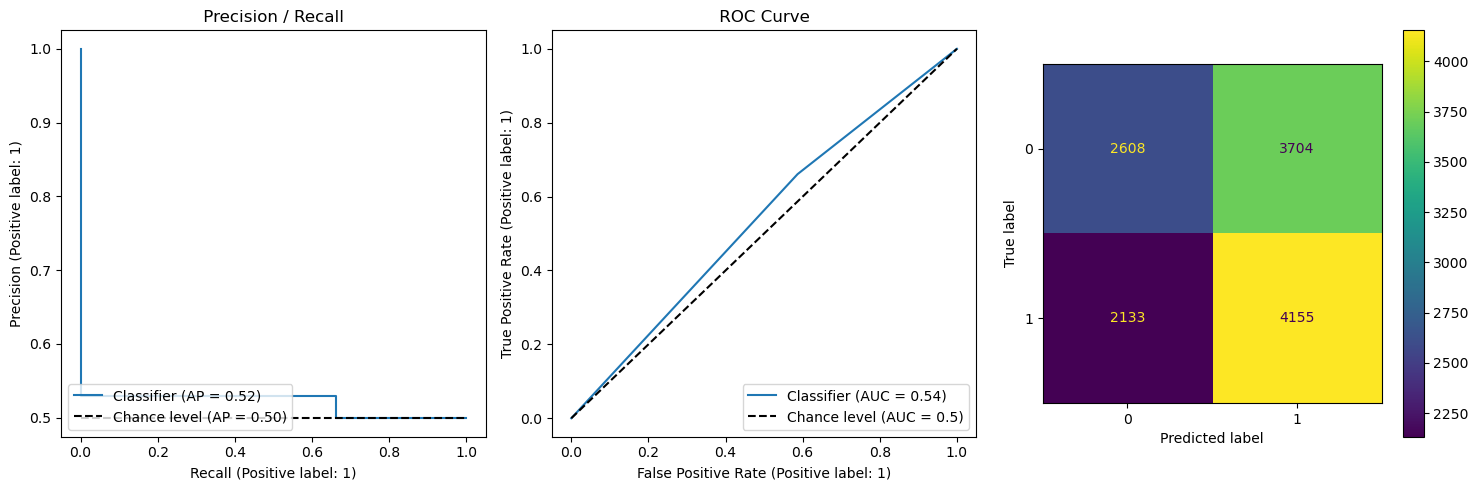

In [69]:
plots_from_predictions(TEST_Y, y_pred)
# plots_from_predictions(bal_test_y, bal_y_pred)

# **[SVM](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html)**

Intuitively, the `gamma` parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The `gamma`parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The `C`parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words`C` behaves as a regularization parameter in the SVM.

In [79]:
svc = SVC(random_state =42, max_iter = 10000, tol = 1e-5, cache_size = 400, class_weight='balanced')

## Parameters

In [80]:
svm_grid_parameters_0 = [
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['linear']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'kernel': ['rbf']},
  {'C': [0.01, 0.1, 1, 10, 100, 200, 400, 1000], 'gamma': [100,10,1,1e-1,1e-2, 1e-3], 'kernel': ['rbf']},
 ]

# svm_grid_parameters_1 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel' : ['linear'] }
# svm_grid_parameters_1 = {'C': [1], 'gamma': [1e-1], 'kernel' : ['linear'] }

# svm_grid_parameters_2 = {'C': [1, 10], 'kernel': ['linear']}
# svm_grid_parameters_2 = {'C': [1, 10], 'gamma': [1,1e-1], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [1, 10, 100],'gamma': [10,1,1e-1,1e-2]}
# svm_grid_parameters_3 = { 'C': [1, 10, 100], 'kernel': ['rbf']}

# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1, 1.0e-1, 1.0e-2, ]}
# svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [  1.0e-3, 1.0e-4, 1.0e-5, ]}
svm_grid_parameters_3 = { 'C': [10], 'kernel': ['rbf'],'gamma': [1.0e-6, 1.0e-7, 1.0e-8,]}
svm_grid_parameters_3 = {'C': [0.1, 1, 10, 100, 200], 'kernel': ['rbf']}
svm_grid_parameters_3 = {'C': [100, 500, 1000], 'kernel': ['rbf']}

## Training

In [81]:
PARM_SET = svm_grid_parameters_3

In [99]:
del X_DATA, Y_DATA
# train_y.head()

In [100]:
NUM_JOBS = 5
X_DATA = train_x.iloc[:, 1:]    ## bal_train_X
Y_DATA = train_y.iloc[:, 0] ## bal_train_y


In [122]:
X_DATA

Cells_AreaShape_BoundingBoxMaximum_X  Cells_AreaShape_Center_X  Cells_AreaShape_Center_Y  Cells_AreaShape_Compactness  \
0                                  -0.422301                 -0.414977                  0.296784                     0.352499   
1                                  -0.634604                 -0.623231                 -1.604601                     1.556609   
2                                   0.510761                  0.556297                 -0.224569                     0.064905   
3                                  -1.832139                 -1.829487                  1.057670                    -0.193737   
4                                  -1.167907                 -1.244004                  0.685477                     0.346317   
...                                      ...                       ...                       ...                          ...   
277195                             -0.084395                 -0.002513                 -0.185704                    -0.287740   
277196                             -0.543744                 -0.509286                 -0.168635                     0.084203   
277197                             -1.379825                 -1.462928                 -1.051015                     0.710750   
277198                              0.560076                  0.596412                  1.796055                    -0.491293   
277199                              1.216171                  1.212295                 -0.961529                     1.165591   

        Cells_AreaShape_Eccentricity  Cells_AreaShape_EulerNumber  Cells_AreaShape_Extent  Cells_AreaShape_MajorAxisLength  \
0                          -0.098035                     0.684400                0.087884                         0.314826   
1                           1.229354                     0.991301               -2.159390                        -0.222254   
2                          -0.326477                    -0.091838               -0.289178                        -0.276995   
3                          -0.485366                    -1.987315                0.516659                        -0.306041   
4                           1.788158                    -0.596517               -0.806163                         0.875543   
...                              ...                          ...                     ...                              ...   
277195                     -0.099358                    -0.058082                0.131313                        -0.181117   
277196                     -0.585224                    -0.015510                0.175776                        -0.106084   
277197                      0.604528                     0.181762               -0.578815                         1.178558   
277198                     -0.346014                     0.163590                0.936329                        -0.466165   
277199                      0.048198                     0.520771                0.007233                        -0.068774   

        Cells_AreaShape_MedianRadius  Cells_AreaShape_MinorAxisLength  ...  Nuclei_Texture_SumAverage_DNA_10_01_256  \
0                           0.368505                         0.557306  ...                                 0.443768   
1                          -1.807152                        -1.510269  ...                                 1.705322   
2                          -0.439694                        -0.303454  ...                                -0.408875   
3                          -0.054500                        -0.082623  ...                                -0.438654   
4                          -0.278969                        -0.196213  ...                                 0.683232   
...                              ...                              ...  ...                                      ...   
277195                     -0.146545                        -0.187826  ...                                 0.3706

In [101]:
# vt_svm = model_selection(svc, PARM_SET, X_DATA, Y_DATA, scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)
vt_svm = model_selection(svc, PARM_SET, train_x.iloc[:, 1:], train_y.iloc[:,0], scoring = 'roc_auc', cv=4, GridSearch = True, n_jobs=NUM_JOBS,  verbose = 3)

 verbose is 3
 params_grid: {'C': [100, 500, 1000], 'kernel': ['rbf']}
 scoring    : roc_auc     cv:  4   n_jobs: 5   gridsearch: True    n_iter: 20   refit: True   
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/py

[CV 3/4] END ................C=100, kernel=rbf;, score=0.524 total time=127.0min
[CV 2/4] END ................C=500, kernel=rbf;, score=0.523 total time=152.4min
[CV 4/4] END ................C=100, kernel=rbf;, score=0.525 total time=135.2min
[CV 3/4] END ................C=500, kernel=rbf;, score=0.516 total time=151.3min
[CV 1/4] END ................C=500, kernel=rbf;, score=0.523 total time=142.8min
[CV 2/4] END ...............C=1000, kernel=rbf;, score=0.523 total time=149.5min


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 2/4] END ................C=100, kernel=rbf;, score=0.515 total time=140.9min
[CV 4/4] END ................C=500, kernel=rbf;, score=0.518 total time=128.8min
[CV 3/4] END ...............C=1000, kernel=rbf;, score=0.516 total time=115.0min
[CV 1/4] END ................C=100, kernel=rbf;, score=0.518 total time=141.1min
[CV 1/4] END ...............C=1000, kernel=rbf;, score=0.523 total time=136.5min
[CV 4/4] END ...............C=1000, kernel=rbf;, score=0.518 total time=113.1min
Best parameters set found on development set: {'C': 100, 'kernel': 'rbf'}
Best score: 0.5206481679392156
Grid scores on development set:

0.52065 (+/-0.008) for {'C': 100, 'kernel': 'rbf'}
0.52019 (+/-0.006) for {'C': 500, 'kernel': 'rbf'}
0.52019 (+/-0.006) for {'C': 1000, 'kernel': 'rbf'}


/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Metric results

In [ ]:
# Best parameters set found on development set: {'C': 10, 'kernel': 'rbf'}
# Best score: 0.5378465362878473
# Grid scores on development set:

# 0.50235 (+/-0.031) for {'C': 1, 'kernel': 'rbf'}
# 0.53181 (+/-0.010) for {'C': 5, 'kernel': 'rbf'}
### 0.53785 (+/-0.008) for {'C': 10, 'kernel': 'rbf'}
### 0.53836 (+/-0.009) for {'C': 10, 'kernel': 'rbf'}
# 0.52558 (+/-0.010) for {'C': 15, 'kernel': 'rbf'}
# 0.51977 (+/-0.027) for {'C': 20, 'kernel': 'rbf'}
# 0.52734 (+/-0.028) for {'C': 25, 'kernel': 'rbf'}
# 0.53087 (+/-0.011) for {'C': 30, 'kernel': 'rbf'}
### 0.53761 (+/-0.014) for {'C': 30, 'kernel': 'rbf'}
# 0.53227 (+/-0.014) for {'C': 50, 'kernel': 'rbf'}
# 0.51949 (+/-0.011) for {'C': 70, 'kernel': 'rbf'}
# 0.53222 (+/-0.006) for {'C': 90, 'kernel': 'rbf'}
# 0.52077 (+/-0.022) for {'C': 100, 'kernel': 'rbf'}

# Best parameters set found on development set: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# Best score: 0.5263117855594914
# Grid scores on development set:

# 0.48997 (+/-0.005) for {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
# 0.48441 (+/-0.002) for {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
# 0.52631 (+/-0.016) for {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
# 0.52721 (+/-0.007) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.53590 (+/-0.010) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
# 0.54687 (+/-0.011) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
# 0.54837 (+/-0.010) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
### 0.54872 (+/-0.011) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
# 0.54796 (+/-0.012) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
 


In [102]:
vt_svm
vt_svm.best_estimator_
vt_svm.best_index_
vt_svm.best_params_
vt_svm.best_score_
vt_svm.classes_
vt_svm.cv
vt_svm.cv_results_
vt_svm.decision_function
vt_svm.error_score
vt_svm.estimator
vt_svm.fit
vt_svm.get_metadata_routing()
print('-'*40)
print(f"vt_svm parameters: ")
print('-'*40)
vt_svm.get_params()
# vt_svm.inverse_transform

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)

0

{'C': 100, 'kernel': 'rbf'}

0.5206481679392156

array([0, 1])

4

{'mean_fit_time': array([5757.92751664, 6085.78602648, 5331.98594248]),
 'std_fit_time': array([280.74944815, 313.80681882, 681.00438973]),
 'mean_score_time': array([2403.93330908, 2543.19809723, 2378.25758946]),
 'std_score_time': array([175.33515139, 253.55859205, 241.57646086]),
 'param_C': masked_array(data=[100, 500, 1000],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 100, 'kernel': 'rbf'},
  {'C': 500, 'kernel': 'rbf'},
  {'C': 1000, 'kernel': 'rbf'}],
 'split0_test_score': array([0.51836483, 0.52253492, 0.52253492]),
 'split1_test_score': array([0.5149519 , 0.52328049, 0.52328049]),
 'split2_test_score': array([0.52409834, 0.51649005, 0.51649005]),
 'split3_test_score': array([0.5251776 , 0.51847124, 0.51847124]),
 'mean_test_score': array([0.52064817, 0.52019418

<bound method BaseSearchCV.decision_function of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

nan

SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
    tol=1e-05)

<bound method BaseSearchCV.fit of GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)>

{'fit': {'groups': None}}

----------------------------------------
vt_svm parameters: 
----------------------------------------


{'cv': 4,
 'error_score': nan,
 'estimator__C': 1.0,
 'estimator__break_ties': False,
 'estimator__cache_size': 400,
 'estimator__class_weight': 'balanced',
 'estimator__coef0': 0.0,
 'estimator__decision_function_shape': 'ovr',
 'estimator__degree': 3,
 'estimator__gamma': 'scale',
 'estimator__kernel': 'rbf',
 'estimator__max_iter': 10000,
 'estimator__probability': False,
 'estimator__random_state': 42,
 'estimator__shrinking': True,
 'estimator__tol': 1e-05,
 'estimator__verbose': False,
 'estimator': SVC(cache_size=400, class_weight='balanced', max_iter=10000, random_state=42,
     tol=1e-05),
 'n_jobs': 5,
 'param_grid': {'C': [100, 500, 1000], 'kernel': ['rbf']},
 'pre_dispatch': 5,
 'refit': True,
 'return_train_score': False,
 'scoring': 'roc_auc',
 'verbose': 3}

### Persist Model

In [48]:
FILENAME = 'PFP_SVM_estimator_RawProfiles_20241030_0700.pkl'

In [49]:
# save_to_pickle(vt_svm, '', FILENAME, verbose = True)

### Load Model

In [50]:
svm_estimators = load_from_pickle('', FILENAME)

In [54]:
svm_estimators
print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print()
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print(f"best_index_  :       {svm_estimators.best_index_}")
print(f"best_params_ :       {svm_estimators.best_params_}")
print(f"best_score_  :       {svm_estimators.best_score_}")
print(f"classes_     :       {svm_estimators.classes_}")
print(f"cv           :       {svm_estimators.cv}")
# print()
print(f"cv_results_  :       {svm_estimators.cv_results_}")
# print()
print(f"error_score  :       {svm_estimators.error_score}")
print(f"estimator    :       {svm_estimators.estimator}")

GridSearchCV(cv=4,
             estimator=SVC(cache_size=400, class_weight='balanced',
                           max_iter=10000, random_state=42, tol=1e-05),
             n_jobs=5, param_grid={'C': [100, 500, 1000], 'kernel': ['rbf']},
             pre_dispatch=5, scoring='roc_auc', verbose=3)

parameters   :

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)
best_index_  :       0
best_params_ :       {'C': 100, 'kernel': 'rbf'}
best_score_  :       0.5206481679392156
classes_     :       [0 1]
cv           :       4
cv_results_  :       {'mean_fit_time': array([5757.92751664, 6085.78602648, 5331.98594248]), 'std_fit_time': array([280.74944815, 313.80681882, 681.00438973]), 'mean_score_time': array([2403.93330908, 2543.19809723, 2378.25758946]), 'std_score_time': array([175.33515139, 253.55859205, 241.57646086]), 'param_C': masked_array(data=[100, 500, 1000],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['rbf', 'rbf', 'rbf'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 100, 'kernel': 'rbf'}, {'C': 500, 'kernel': 'rbf'}, {'C': 1000, 'kernel': 'rbf'}], 'split0_test_

## Metrics - `svm_estimators_1`

In [118]:
# FILENAME = 'SVM_estimators_SNNL_1_BALANCED_RATIO_1.pkl'
FILENAME = 'PFP_SVM_estimator_RawProfiles_20241030_0700.pkl'
svm_estimators = load_from_pickle('', FILENAME)

In [55]:
# print(f"parameters   :")
# pp.pprint(svm_estimators.get_params())
print(f"best_estimator_  :   {svm_estimators.best_estimator_}")
print()
 

best_estimator_  :   SVC(C=100, cache_size=400, class_weight='balanced', max_iter=10000,
    random_state=42, tol=1e-05)



In [56]:
TEST_X = test_x.iloc[:, 1:]    ## bal_train_X
TEST_Y = test_y.iloc[:, 0] ## bal_train_y


In [57]:
y_pred = svm_estimators.best_estimator_.predict(TEST_X)
y_pred.shape

(12600,)

In [648]:
# bal_y_pred = svm_estimators.best_estimator_.predict(bal_test_X)
# bal_y_pred.shape

(8328,)

In [64]:
# label_counts( [("Ground Truth", test_y), ("Predictions", y_pred), ("Balanced Ground Truth", bal_test_y), ("Balanced Predictions", bal_test_y)])
label_counts( [("Ground Truth", TEST_Y), ("Predictions", y_pred)])

 Ground Truth
 Total samples: 12600
 Label 0:   6,312      % 50.10 
 Label 1:   6,288      % 49.90 

 Predictions
 Total samples: 12600
 Label 0:   9,532      % 75.65 
 Label 1:   3,068      % 24.35 



In [66]:
compute_metrics(TEST_Y, y_pred)

 Accuracy: 0.50651     Precision: 0.51141     Recall: 0.24952     F1: 0.33540 

 True + labels:          6288     ratio to total:  0.49905
 Predicted + labels:     3068     ratio to total:  0.24349
 True/Predicted Match:   6382     ratio to total:  0.50651


In [67]:
# compute_metrics(bal_test_y, bal_y_pred, " 1:1 Balanced test file")

In [68]:
# plots_from_estimator(svm_estimators.best_estimator_, test_X, y_pred)
# plots_from_estimator(svm_estimators.best_estimator_, bal_test_X, bal_y_pred)

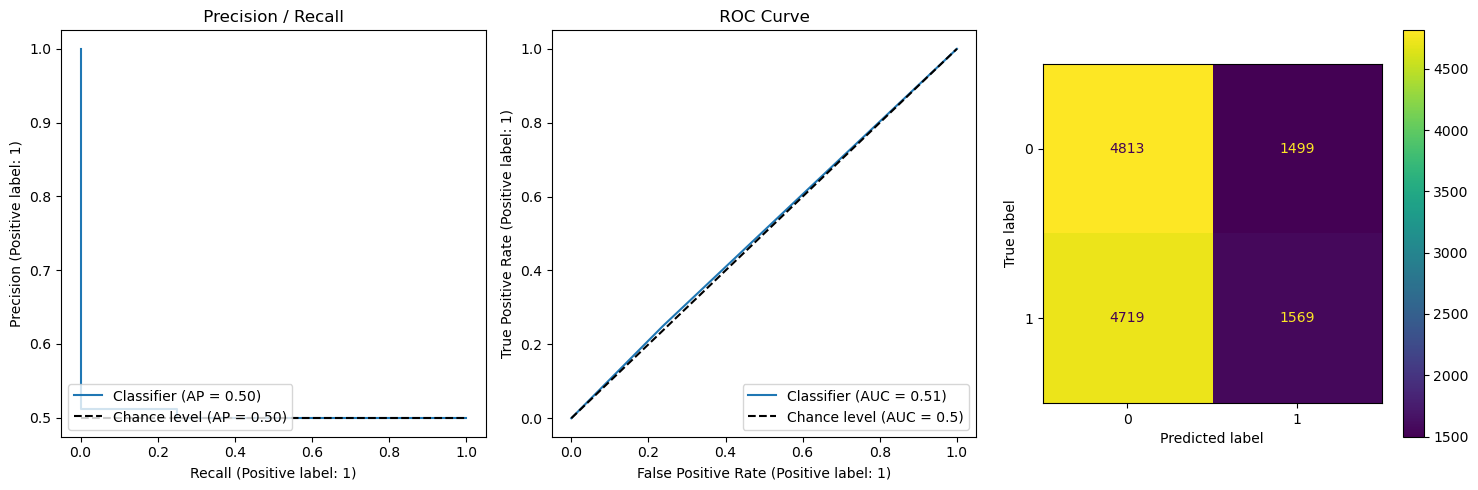

In [69]:
plots_from_predictions(TEST_Y, y_pred)
# plots_from_predictions(bal_test_y, bal_y_pred)

# **[kNN](https://scikit-learn.org/stable/modules/neighbors.html)** 

* **algorithm**  {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
Algorithm used to compute the nearest neighbors:

    `ball_tree` will use BallTree
  
    `kd_tree` will use KDTree

    `brute` will use a brute-force search.

    `auto` will attempt to decide the most appropriate algorithm based on the values passed to fit method.

    Note: fitting on sparse input will override the setting of this parameter, using brute force.

*  **leaf_size** int, default=30  -- Leaf size passed to BallTree or KDTree.

      This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

*  **p**   float, default=2 -- Power parameter for the Minkowski metric.

      When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary p, minkowski_distance (l_p) is used. This parameter is expected to be positive.


*  **metric**  str or callable, default=’minkowski’ -- Metric to use for distance computation.

      Default is `minkowski`, which results in the standard Euclidean distance when p = 2. See the documentation of scipy.spatial.distance and the metrics listed in distance_metrics for valid metric values.

      If metric is `precomputed`, X is assumed to be a distance matrix and must be square during fit. X may be a sparse graph, in which case only “nonzero” elements may be considered neighbors. 

      If metric is a callable function, it takes two arrays representing 1D vectors as inputs and must return one value indicating the distance between those vectors. This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.

*  **metric_params**   dict, default=None -- Additional keyword arguments for the metric function.

*  **n_jobs**  int, default=None -- The number of parallel jobs to run for neighbors search.

    None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. Doesn’t affect fit method.   

In [166]:
# del knn_clf, knn_estimators, knn_grid_parameters_des, knn_grid_parameters_fp, knn_grid_parameters_fpcounts

In [26]:
# classification

knn_clf = KNeighborsClassifier()

## Parameters

In [85]:
knn_grid_parameters = {'n_neighbors': [3, 6, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'p': [1,2]}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 23, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto']}

knn_grid_parameters = {'n_neighbors': [5, 9, 15, 19, 25, 35, 45, 55, 71],
                       'weights': ['distance'],
                       'metric' : ['hamming', 'canberra', 'braycurtis']}

knn_grid_parameters = {'n_neighbors': [57],
                       'weights': ['distance'],
                       'metric' : ['jaccard', 'dice', 'rogerstanimoto', 'hamming', 'canberra', 'braycurtis']}

# knn_grid_parameters_des = {'n_neighbors': [3, 6, 9, 12, 15], 'weights': ['distance'], 'p': [1]}
knn_grid_parameters = {'n_neighbors': [105, 120,  135, 150 ],
                       'weights': ['distance'],
                       'metric' : ['minkowski'],'p': [2]}


In [86]:
%%time
## returns :  a: labeled_features, b: ublabeled_features, c: labeled_Y, d: df_labled.indicies, e: df_unlabeled.indicies
# a,b,c,d,e = prepare_input(train_labels, train_ecfp6_bits, target = 'verytoxic', encoder = encoder_verytoxic)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.78 µs


## Training

In [87]:
# PARM_SET = knn_grid_parameters_des
PARM_SET = knn_grid_parameters

In [104]:
print(PARM_SET)

{'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}


In [106]:
NUM_JOBS = 4

In [107]:
vt_knn_ecfp6bits = model_selection(knn_clf, PARM_SET, train_X, train_y, scoring='roc_auc',
                                   cv=5, GridSearch=True, n_jobs=NUM_JOBS, verbose=4)

 verbose is 4
 params_grid: {'n_neighbors': [105, 120, 135, 150], 'weights': ['distance'], 'metric': ['minkowski'], 'p': [2]}
 scoring    : roc_auc     cv:  5   n_jobs: 4   gridsearch: True    n_iter: 20   refit: True   
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters set found on development set: {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
Best score: 0.5878363154701123
Grid scores on development set:

0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}


In [ ]:

# 0.53766 (+/-0.007) for {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
# 0.54873 (+/-0.008) for {'n_neighbors': 6, 'p': 1, 'weights': 'distance'}
# 0.55621 (+/-0.007) for {'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
# 0.56121 (+/-0.008) for {'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
# 0.56505 (+/-0.010) for {'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
# 0.57179 (+/-0.011) for {'n_neighbors': 24, 'p': 1, 'weights': 'distance'}
# 0.57694 (+/-0.012) for {'n_neighbors': 32, 'p': 1, 'weights': 'distance'}
# 0.57842 (+/-0.013) for {'n_neighbors': 36, 'p': 1, 'weights': 'distance'}
# 0.57964 (+/-0.013) for {'n_neighbors': 42, 'p': 1, 'weights': 'distance'}
# 0.58258 (+/-0.012) for {'n_neighbors': 57, 'p': 1, 'weights': 'distance'}
# 0.58379 (+/-0.011) for {'metric': 'minkowski', 'n_neighbors': 57, 'p': 2, 'weights': 'distance'}
# 0.58498 (+/-0.012) for {'metric': 'minkowski', 'n_neighbors': 69, 'p': 2, 'weights': 'distance'}
# 0.58603 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 81, 'p': 2, 'weights': 'distance'}
# 0.58645 (+/-0.013) for {'metric': 'minkowski', 'n_neighbors': 90, 'p': 2, 'weights': 'distance'}
# 0.58720 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 105, 'p': 2, 'weights': 'distance'}
# 0.58766 (+/-0.015) for {'metric': 'minkowski', 'n_neighbors': 120, 'p': 2, 'weights': 'distance'}
# 0.58784 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
# 0.58775 (+/-0.014) for {'metric': 'minkowski', 'n_neighbors': 150, 'p': 2, 'weights': 'distance'}

In [140]:
vt_knn_ecfp6bits
print(f"parameters   :")
pp.pprint(vt_knn_ecfp6bits.get_params())

print(f"best_estimator_  :   {vt_knn_ecfp6bits.best_estimator_}")
print(f"best_index_  :       {vt_knn_ecfp6bits.best_index_}")
print(f"best_params_ :       {vt_knn_ecfp6bits.best_params_}")
print(f"best_score_  :       {vt_knn_ecfp6bits.best_score_}")
print(f"classes_     :       {vt_knn_ecfp6bits.classes_}")
print(f"cv           :       {vt_knn_ecfp6bits.cv}")
print()
print(f"cv_results_  :       {vt_knn_ecfp6bits.cv_results_}")
print()
print(f"error_score  :       {vt_knn_ecfp6bits.error_score}")
print(f"estimator    :       {vt_knn_ecfp6bits.estimator}")

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [105, 120, 135, 150],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 4}
best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')
best_index_  :       2
best_params_ :       {'metric': 'minkowski', 'n_neighbors': 135, 'p': 2, 'weights': 'distance'}
best_score_  :       0.5878363154701123
classes_     :       [0. 1.]
cv           :       5

cv_results_  :   

In [83]:
bcnt = np.bincount(test_y.astype(np.int64))
print(f"{bcnt[0]/bcnt.sum():4f}")

0.879451


In [112]:
y_pred = vt_knn_ecfp6bits.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [163]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f"Test Accuracy: {test_accuracy:4f}")
print(f"Precision: {precision:.5f}   Recall: {recall:.5f}   F1: {f1:.5f} "
      f"  True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}  "
      f"Match: {(y_pred == test_y).sum()}   {(y_pred == test_y).sum()/test_y.shape[0]:.6f}" )

Test Accuracy: 0.879567
Precision: 0.70000   Recall: 0.00168   F1: 0.00335   True + labels: 4164.0  Predicted + labels: 10.0  Match: 30382   0.879567


### Persist Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [143]:
save_to_pickle(vt_knn_ecfp6bits, '', FILENAME, verbose = True)

 save_to_pickle(): save data to KNN_estimators_2.pkl


### Load Model

In [142]:
FILENAME = 'KNN_estimators_2.pkl'

In [144]:
knn_estimators = load_from_pickle('', FILENAME)

In [165]:
knn_estimators
print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

parameters   :
{   'cv': 5,
    'error_score': nan,
    'estimator': KNeighborsClassifier(),
    'estimator__algorithm': 'auto',
    'estimator__leaf_size': 30,
    'estimator__metric': 'minkowski',
    'estimator__metric_params': None,
    'estimator__n_jobs': None,
    'estimator__n_neighbors': 5,
    'estimator__p': 2,
    'estimator__weights': 'uniform',
    'n_jobs': 4,
    'param_grid': {   'metric': ['minkowski'],
                      'n_neighbors': [57, 69, 81, 90],
                      'p': [2],
                      'weights': ['distance']},
    'pre_dispatch': '2*n_jobs',
    'refit': True,
    'return_train_score': False,
    'scoring': 'roc_auc',
    'verbose': 1}

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


## Metrics - `KNN_estimators_1`

In [303]:
FILENAME = 'KNN_estimators_1.pkl'

In [304]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [57, 69, 81, 90], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=1)

best_estimator_  :   KNeighborsClassifier(n_neighbors=90, weights='distance')


In [307]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [309]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,532      % 99.97 
 Label 1:      10      % 0.03 



In [311]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879567
 Precision: 0.70000     Recall: 0.00168     F1: 0.00335 
 True + labels: 4164.0  Predicted + labels: 10.0     Match: 30382 


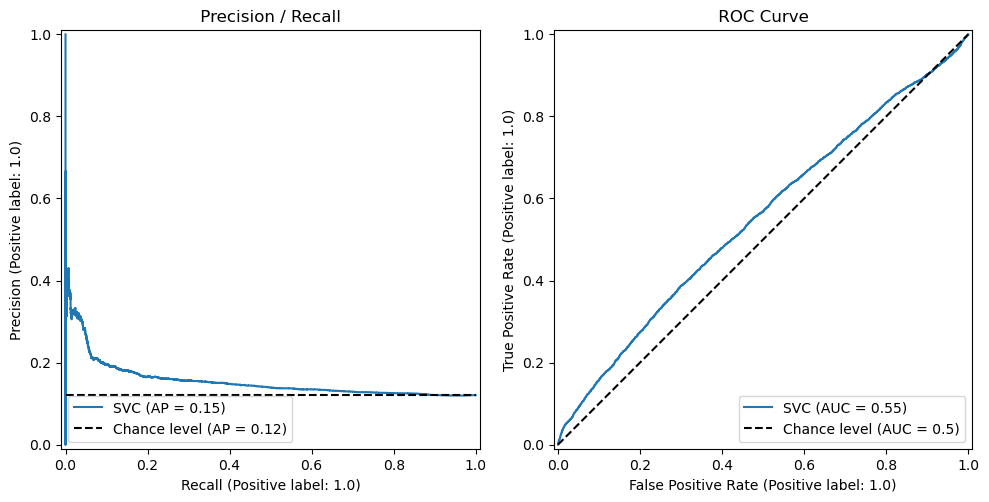

In [313]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

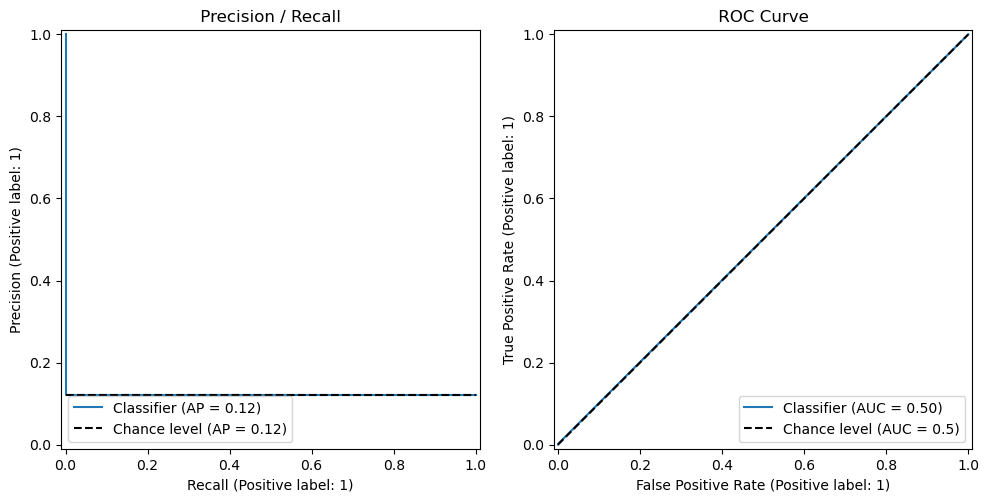

In [314]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

## Metrics - `KNN_estimators_2`

In [315]:
FILENAME = 'KNN_estimators_2.pkl'

In [316]:
knn_estimators = load_from_pickle('', FILENAME)
knn_estimators
# print(f"parameters   :")
# pp.pprint(knn_estimators.get_params())
# print()
print(f"best_estimator_  :   {knn_estimators.best_estimator_}")
 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=4,
             param_grid={'metric': ['minkowski'],
                         'n_neighbors': [105, 120, 135, 150], 'p': [2],
                         'weights': ['distance']},
             scoring='roc_auc', verbose=4)

best_estimator_  :   KNeighborsClassifier(n_neighbors=135, weights='distance')


In [317]:
y_pred = knn_estimators.best_estimator_.predict(test_X)
y_pred.shape

(34542,)

In [318]:
for grp_name, labels in [("Ground Truth", test_y), ("Predictions", y_pred)]:
    bcnt = np.bincount(labels.astype(np.int64))
    print(f" {grp_name}")
    print(f" Total samples: {bcnt.sum():7,d}")
    print(f" Label 0: {bcnt[0]:7,d}      % {bcnt[0]*100/bcnt.sum():2.2f} ")
    print(f" Label 1: {bcnt[1]:7,d}      % {bcnt[1]*100/bcnt.sum():2.2f} ")
    print("")

 Ground Truth
 Total samples:  34,542
 Label 0:  30,378      % 87.95 
 Label 1:   4,164      % 12.05 

 Predictions
 Total samples:  34,542
 Label 0:  34,534      % 99.98 
 Label 1:       8      % 0.02 



In [320]:
test_accuracy = skm.accuracy_score(test_y, y_pred)
precision, recall, f1, support = skm.precision_recall_fscore_support(test_y, y_pred, average='binary', zero_division=0)

print(f" Test Accuracy: {test_accuracy:4f}")
print(f" Precision: {precision:.5f}     Recall: {recall:.5f}     F1: {f1:.5f} "
      f"\n True + labels: {test_y.sum()}  Predicted + labels: {y_pred.sum()}     Match: {(y_pred == test_y).sum()} " )

 Test Accuracy: 0.879625
 Precision: 0.87500     Recall: 0.00168     F1: 0.00336 
 True + labels: 4164.0  Predicted + labels: 8.0     Match: 30384 


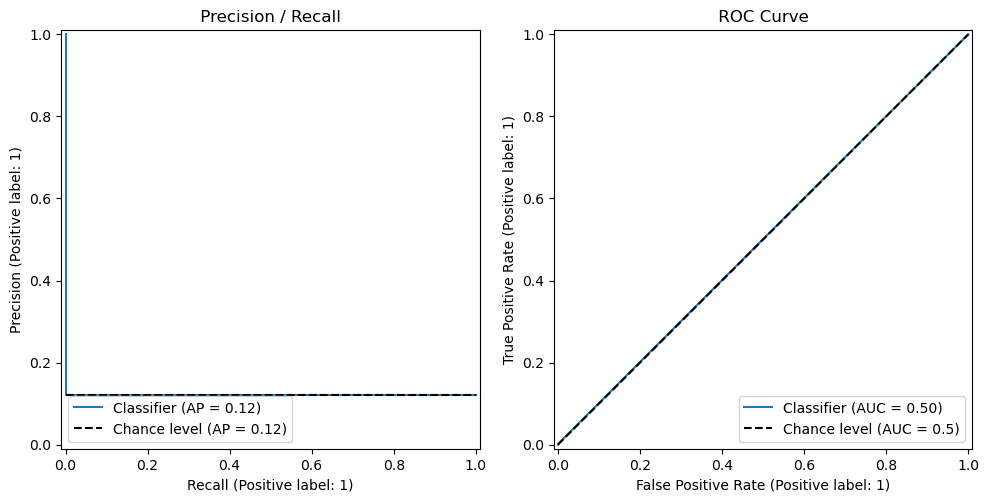

In [321]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_predictions(test_y, y_pred, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_predictions(test_y, y_pred, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()

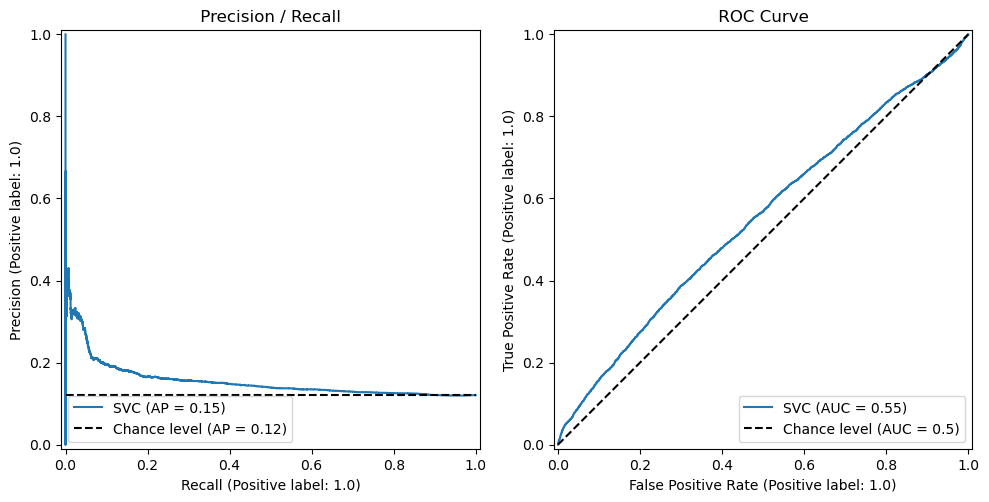

In [322]:
rows = 1
cols=2
fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True, figsize=(cols *5,5) )
_ = skm.PrecisionRecallDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level = True, ax = axs[0])
_ = skm.RocCurveDisplay.from_estimator(vt_svm.best_estimator_, test_X, test_y, plot_chance_level= True, ax = axs[1])
_ = axs[0].set_title(" Precision / Recall ")
_ = axs[1].set_title(" ROC Curve ")
plt.show()